In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%%capture
!pip install ffmpeg

In [ ]:
%%capture
!unzip "/content/gdrive/My Drive/EmotiW_2018.zip"

In [ ]:
%%capture
# !unzip "/content/gdrive/MyDrive/TFM_MUSI/Audio_Speech_Actors_01-24.zip"

In [ ]:
import ffmpeg
import glob, os,shutil

import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
from numpy import save
from numpy.random import seed

import librosa                    
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile
from scipy.fftpack import dct
from scipy import signal

import operator
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications
from keras.models import load_model
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,CSVLogger
import tensorflow as tf


from sklearn.model_selection import train_test_split
import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import itertools
import shutil

import csv
from csv import DictWriter
from datetime import datetime
from packaging import version
from pathlib import Path

In [ ]:
#Set seed
seed(42)
tf.random.set_seed(42)

In [ ]:
dict_xy_afew={}
train_set_path='EmotiW_2018/Train_AFEW/'
test_set_path='EmotiW_2018/Val_AFEW/'

os.remove(train_set_path+'Train_6.xml')
os.remove(train_set_path+'AlignedFaces_LBPTOP_Points.zip')
os.remove(test_set_path+'Val_6.xml')
os.remove(test_set_path+'AlignedFaces_LBPTOP_Points_Val.zip')

emotions=sorted(os.listdir(train_set_path))
print(emotions)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [ ]:
num_emotions=7
emo_dict={}
for emo,i in zip(emotions, range(num_emotions+1)):
  emo_dict[emo]=i
print(emo_dict)

emo_dict_reversed = {v: k for k, v in emo_dict.items()}
print(emo_dict_reversed)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


In [ ]:
#Convert a video set into audio format
def convert_to_audio_ne(set_path,set_name):
  f = open("convert_to_audio.sh", "w")
  path_afew_set=set_path
  urls_afew = glob.glob(pathname=path_afew_set + '*')
  print(urls_afew)
  print("-------------------")
  for url_emo in urls_afew:
    urls_emotion = glob.glob(pathname=url_emo + '/*')
    # print(urls_emotion)
    emo=os.path.basename(url_emo)
    new_dir=set_name+'_audio_ne/'
    if not os.path.exists(set_name+'_audio_ne'):
      os.makedirs(set_name+'_audio_ne')
    print(emo)
    for video_file in urls_emotion:
      file_name=os.path.splitext(os.path.basename(video_file))
      f.write("ffmpeg -i "+video_file+" -vn -ac 1 "+new_dir+file_name[0]+".wav"+'\n')
      dict_xy_afew[file_name[0]]=emo
  f.close()

In [ ]:
%%capture
#Extract audio from the videos
!rm -rf Train_audio_ne
convert_to_audio_ne(train_set_path,'Train')
! bash convert_to_audio.sh
!rm -rf Test_audio_ne
convert_to_audio_ne(test_set_path,'Test')
! bash convert_to_audio.sh

In [ ]:
train_path='Train_audio_ne/'
test_path='Test_audio_ne/'

urls_afew_train = glob.glob(pathname=train_path + '*')
urls_afew_test = glob.glob(pathname=test_path + '*')
urls_afew_test[0]

'Test_audio_ne/005806334.wav'

In [ ]:
print("number of train samples:",len(urls_afew_train))
print("number of test samples:",len(urls_afew_test))

number of train samples: 773
number of test samples: 381


emotion:  Angry
number of audios:  197
-----
emotion:  Disgust
number of audios:  113
-----
emotion:  Fear
number of audios:  127
-----
emotion:  Happy
number of audios:  213
-----
emotion:  Neutral
number of audios:  205
-----
emotion:  Sad
number of audios:  177
-----
emotion:  Surprise
number of audios:  120
-----


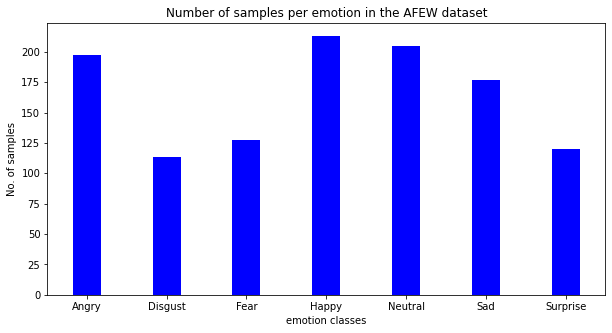

In [ ]:
emotions=[]
num_samples=[]
for emo in emo_dict.keys():
  samples=list(dict_xy_afew.values()).count(emo)
  num_samples.append(samples)
  emotions.append(emo)
  print("emotion: ", emo)
  print("number of audios: ",samples)
  print("-----")

#Está desbalanceado. Graficamos la distribución por clases:

fig = plt.figure(figsize = (10, 5))
plt.bar(emotions, num_samples, 
        0.35,label="number of samples",color ='blue')
plt.xlabel("emotion classes")
plt.ylabel("No. of samples")
plt.title("Number of samples per emotion in the AFEW dataset")
plt.show()

In [ ]:
def get_categorical_label(file_id):
  emo=dict_xy_afew[file_id]
  categorical_label=tf.keras.utils.to_categorical(emo_dict[emo], num_classes=num_classes)
  return categorical_label

def get_emo_label(categorical_label):
  emo=dict_xy_afew[file_id]
  return emo

def get_emo_from_categorical(label):
  idx=list(label).index(1)
  return emo_dict_reversed[idx]

def plot_model(history,title):
  fig=plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)
  plt.show()

def save_plot(history,title,filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results/"):
  fig = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  plt.show()
  new_filename  = Path(filename +'/'+title+'.jpg')
  fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)

def plot_conf_matrix(x_test,y_test,modelo,path,title,standard_format=True,percentages=True,save_plot=True):

  labels=[key for key in emo_dict.keys()]
  predictions=modelo.predict(x_test)

  ypred=[round(list(i).index(np.max(i))) for i in predictions]
  y_true=[np.argmax(y) for y in y_test]

  print(confusion_matrix(y_true, ypred)[:,:])
  print("")
  f1=f1_score(y_true, ypred,average=None)
  f1_w=f1_score(y_true, ypred,average='weighted')
  ac=accuracy_score(y_true, ypred)
  print("accuracy: ",ac)
  print("f1 score:",f1)
  print("f1 score weighted:",f1_w)
  print("---------------------------------------------------------")
  print(title)
  if standard_format:
    cm = confusion_matrix(y_true, ypred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')
    if save_plot:
      plt.savefig(path+".png")
    plt.show()
  print("")
  if percentages:
    cm = confusion_matrix(y_true, ypred,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='.2f')
    plt.show()
    if save_plot:
      plt.savefig(path+"_perctg.png")
    plt.show()
  print("")

In [ ]:
# get len min of audio sets
urls=urls_afew_train[:]
urls.extend(urls_afew_test)
audios_len=[]
max=0
for audio_sample in urls:
  # print(urls_afew_train)
  audio,sr = librosa.load(audio_sample,sr=22050)
  audios_len.append(audio.shape[0])
  if audio.shape[0]>max:
    max=audio.shape[0]
    print("new max",max)
    print(audio_sample)
    print("----------------")

new max 53979
Train_audio_ne/003910920.wav
----------------
new max 64563
Train_audio_ne/010003880.wav
----------------
new max 107957
Train_audio_ne/004242574.wav
----------------
new max 116954
Train_audio_ne/002927520.wav
----------------
new max 117483
Train_audio_ne/003853320.wav
----------------
new max 131771
Train_audio_ne/012904560.wav
----------------
new max 137063
Test_audio_ne/003353294.wav
----------------


In [ ]:
print("maximum audio length: ", np.max(audios_len), "is from audio:",urls[audios_len.index(np.max(audios_len))] )
print("minimum audio length: ",np.min(audios_len), "is from audio:",urls[audios_len.index(np.min(audios_len))])
print("mean audio length : ",np.mean(audios_len))

maximum audio length:  137063 is from audio: Test_audio_ne/003353294.wav
minimum audio length:  8997 is from audio: Train_audio_ne/011603980.wav
mean audio length :  54136.53466204506


In [ ]:
#Analizamos como son el audio más corto y más largo del dataset:

0.40802721088435373
22050


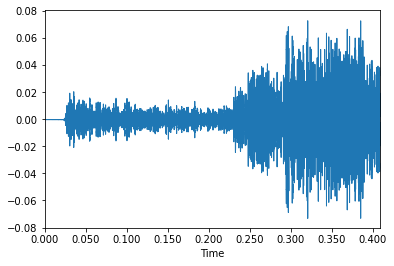

In [ ]:
#Audio más corto
audio,sr = librosa.load("Train_audio_ne/011603980.wav")
librosa.get_duration(audio)
librosa.display.waveplot(audio)
print(librosa.get_duration(audio))
print(sr)
ipd.Audio("Train_audio_ne/011603980.wav")

Test_audio_ne/010904207.wav
6.216009070294785
22050


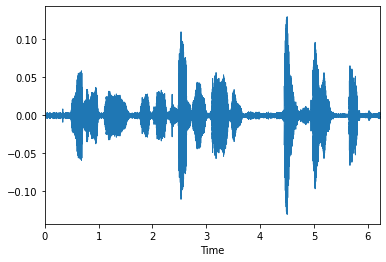

In [ ]:
#Audio más largo:
len(urls)
print(urls[934])
audio,sr = librosa.load("Test_audio_ne/003353294.wav")
librosa.display.waveplot(audio, sr=sr)
print(librosa.get_duration(audio))
audio.shape[0]
print(sr)
ipd.Audio("Test_audio_ne/003353294.wav")

Test_audio_ne/010904207.wav
5.328027210884354
22050


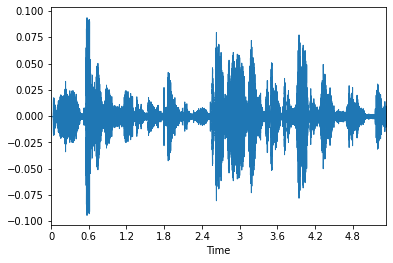

In [ ]:
#Audio más largo del set de entrenamiento
len(urls)
print(urls[934])
audio,sr = librosa.load("Train_audio_ne/003853320.wav")
librosa.display.waveplot(audio, sr=sr)
print(librosa.get_duration(audio))
audio.shape[0]
print(sr)
ipd.Audio("Train_audio_ne/003853320.wav")

In [ ]:
#resize audios to a new standard size shortening or padding with zeros
def standarize_audios_len(audio_file,desired_len):
  len=asarray(audio_file).shape
  # print(len)
  # print("dif=", abs(len[0]-desired_len))
  if len[0] < desired_len:
    # print("short")
    zeros=np.zeros(abs(len[0]-desired_len))
    new_audio=np.append(audio_file,zeros)
  else:
    new_audio=audio_file[0:desired_len]
  
  return new_audio

In [ ]:
#function to preprocess audio:
# standarizes the audio lenght to the maximum audio len padding with 0s so all audios have the same dimensions
# Applies a preemphasis filter if set
# Computes de log-mel-spectrogram and normalizes it if set

def preprocess_audio(audio_file, desired_audio_len=137063, frame_size=0.025, stride=0.01,normalize=False,preemphasis=True,norm_waveform=False):
  #normalize waveform
  if norm_waveform==True:
    audio_file = (audio_file - audio_file.mean()) / audio_file.std() + 1e-10

  y,sr = librosa.load(audio_file) 
  # shortened_audio=y[0:8997]
  y=standarize_audios_len(y,desired_audio_len) #standarize the len of the audios padding with 0s:

  if preemphasis==True: 
    y=librosa.effects.preemphasis(y, coef=0.97) #Apply a pre-emphasis filter

  #frame size mejor potencia de 2?  
  frame_size=int(round(frame_size*sr)) #frame_size en samples dim
  stride_size= int(round(stride*sr))  #stride_size en samples dim
  mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=frame_size,window=scipy.signal.hamming, hop_length=stride_size, n_mels=40)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  
  if normalize==True:
    mean = np.mean(log_mel_spectrogram, axis=0)
    std = np.std(log_mel_spectrogram, axis=0)
    log_mel_spectrogram = (log_mel_spectrogram - mean) / std + 1e-10

  return log_mel_spectrogram,sr

In [ ]:
def create_set(url_list, dict_set, desired_audio_len=137063, normalize=False, preemphasis=True):
  x_data,y_data=[],[]
  mean=[]
  spec_values=[]
  i=0
  for audio_file in url_list:
    file_id=os.path.splitext(os.path.basename(audio_file))[0]
    melSpec_dB,sr = preprocess_audio(audio_file,desired_audio_len=137063, frame_size=0.025, stride=0.01,normalize=normalize,preemphasis=preemphasis)
    mean.extend(np.mean(melSpec_dB,axis=0))
    spec_values.extend(melSpec_dB)
    
    #   #check
    #   plt.figure(figsize=(10, 5))
    #   librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    #   plt.colorbar(format='%+1.0f dB')
    #   plt.title("MelSpectrogram")
    #   plt.tight_layout()
    #   plt.show()

    label=get_categorical_label(file_id)
    dict_set[audio_file]=label
    x_data.append(melSpec_dB)
    y_data.append(label)
  return x_data,y_data,mean,spec_values


In [ ]:
normalize=False # alerta amb Nans
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

#Dictionaries containing audio id and label
train_data={}
test_data={}

x_data_train,y_data_train,mean,spec_values = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)

In [ ]:
x_data_test,y_data_test,_,_ = create_set(urls_afew_test,test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
# a=[ [[2,3],[3,5],[5,6]],[[2,3],[3,5],[5,6]] ]
# n=np.mean(a,axis=2)
# print(n)
# f=np.mean(n,axis=0)
# print(f)

[[2.5 4.  5.5]
 [2.5 4.  5.5]]
[2.5 4.  5.5]


In [ ]:
#calculamos la media del conjunto de entrenamiento
#Nos interesa calcular la media por mel band más que por slot temporal
#También se ha probado con el array aplanado 

xtr=asarray(x_data_train)
print(xtr.shape)

temp_mean=np.mean(xtr,axis=2)
temp_std=np.std(xtr,axis=2)

print(temp_mean.shape)
print(temp_std.shape)
train_mean=np.mean(temp_mean,axis=0)
train_std=np.std(temp_std,axis=0)

print(train_mean.shape)
print(train_std.shape)

(773, 40, 624)
(773, 40)
(773, 40)
(40,)
(40,)


In [ ]:
train_mean

array([-83.16532122, -81.69043476, -80.83720059, -80.39513628,
       -80.13517377, -80.05706775, -80.14985933, -80.30770979,
       -80.3052014 , -80.3182261 , -80.36935641, -80.43278763,
       -80.49320246, -80.50353838, -80.53183148, -80.42386975,
       -80.24993468, -80.04886473, -79.95573886, -79.88458231,
       -79.86285887, -79.78355141, -79.63518435, -79.64035709,
       -79.76723436, -79.91248863, -79.95061566, -80.01417609,
       -80.15126072, -80.33001315, -80.63495596, -80.91597004,
       -81.12495327, -81.23543217, -81.4277069 , -81.71745782,
       -82.07907377, -82.53164072, -83.06644467, -84.26581219])

In [ ]:
train_std

array([4.50899485, 4.13753691, 3.88603162, 3.69156887, 3.60794329,
       3.59886418, 3.59239053, 3.66535848, 3.65768662, 3.64992143,
       3.65946933, 3.56413364, 3.48793974, 3.51942221, 3.577275  ,
       3.56670693, 3.51826647, 3.55411467, 3.57244728, 3.52319282,
       3.49199847, 3.53436735, 3.54392652, 3.50292482, 3.46409702,
       3.40955618, 3.42474453, 3.41692   , 3.39648421, 3.3922196 ,
       3.3805732 , 3.37328995, 3.4448974 , 3.56967612, 3.58236923,
       3.51180612, 3.51626753, 3.48789136, 3.63709269, 3.58383639])

In [ ]:
xtr[0]

array([[-99.71630301, -99.01340231, -54.7964097 , ..., -99.71630301,
        -99.71630301, -99.71630301],
       [-99.71630301, -96.60402015, -54.85746645, ..., -99.71630301,
        -99.71630301, -99.71630301],
       [-99.71630301, -95.59366699, -51.66270095, ..., -99.71630301,
        -99.71630301, -99.71630301],
       ...,
       [-94.7320286 , -87.48158779, -77.08019461, ..., -99.71630301,
        -99.71630301, -99.71630301],
       [-94.84188895, -86.71019016, -77.62260671, ..., -99.71630301,
        -99.71630301, -99.71630301],
       [-95.87017617, -89.0610997 , -79.67948883, ..., -99.71630301,
        -99.71630301, -99.71630301]])

In [ ]:
xtr[0].shape

(40, 624)

In [ ]:
a=(xtr[0].T-train_mean)/train_std+1e-10
print(a.shape)
print(a)
print(a.T.shape)
print(a.T)

(624, 40)
[[-3.67065884 -4.35666645 -4.85819577 ... -3.49792658 -3.23759807
  -3.23797259]
 [-3.51477028 -3.60445978 -3.79730991 ... -1.4191804  -1.00182915
  -1.33803193]
 [ 6.29162651  6.48525171  7.50753017 ...  1.56296328  1.49675535
   1.27972453]
 ...
 [-3.67065884 -4.35666645 -4.85819577 ... -4.92694884 -4.57779324
  -4.31115965]
 [-3.67065884 -4.35666645 -4.85819577 ... -4.92694884 -4.57779324
  -4.31115965]
 [-3.67065884 -4.35666645 -4.85819577 ... -4.92694884 -4.57779324
  -4.31115965]]
(40, 624)
[[-3.67065884 -3.51477028  6.29162651 ... -3.67065884 -3.67065884
  -3.67065884]
 [-4.35666645 -3.60445978  6.48525171 ... -4.35666645 -4.35666645
  -4.35666645]
 [-4.85819577 -3.79730991  7.50753017 ... -4.85819577 -4.85819577
  -4.85819577]
 ...
 [-3.49792658 -1.4191804   1.56296328 ... -4.92694884 -4.92694884
  -4.92694884]
 [-3.23759807 -1.00182915  1.49675535 ... -4.57779324 -4.57779324
  -4.57779324]
 [-3.23797259 -1.33803193  1.27972453 ... -4.31115965 -4.31115965
  -4.3111596

In [ ]:
new_data_train=[]

for spec in x_data_train:
  norm_spec=(spec.T-train_mean)/train_std+1e-10
  new_data_train.append(norm_spec.T) 

print(asarray(new_data_train).shape)
print(new_data_train[0])


(773, 40, 624)
[[-3.67065884 -3.51477028  6.29162651 ... -3.67065884 -3.67065884
  -3.67065884]
 [-4.35666645 -3.60445978  6.48525171 ... -4.35666645 -4.35666645
  -4.35666645]
 [-4.85819577 -3.79730991  7.50753017 ... -4.85819577 -4.85819577
  -4.85819577]
 ...
 [-3.49792658 -1.4191804   1.56296328 ... -4.92694884 -4.92694884
  -4.92694884]
 [-3.23759807 -1.00182915  1.49675535 ... -4.57779324 -4.57779324
  -4.57779324]
 [-3.23797259 -1.33803193  1.27972453 ... -4.31115965 -4.31115965
  -4.31115965]]


In [ ]:
new_data_test=[]
for spec in x_data_test:
  norm_spec=(spec.T-train_mean)/train_std+1e-10
  new_data_test.append(norm_spec.T)

print(asarray(new_data_test).shape)
print(new_data_test[0])

(381, 40, 624)
[[-2.66839411 -2.66839411  5.41935496 ... -2.66839411 -2.66839411
  -2.66839411]
 [-3.26442085 -3.26442085  4.92764119 ... -3.26442085 -3.26442085
  -3.26442085]
 [-3.69525967 -3.69525967  4.62774695 ... -3.69525967 -3.69525967
  -3.69525967]
 ...
 [-3.28502948 -0.9285029   2.59932635 ... -3.63126442 -3.63126442
  -3.63126442]
 [-2.78721097 -1.2055743   2.35322358 ... -3.33526057 -3.33526057
  -3.33526057]
 [-2.73102678 -1.27639516  1.87778611 ... -3.05016277 -3.05016277
  -3.05016277]]


In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(new_data_train[0]).shape
# input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
print("input shape: ",input_shape)
epochs=50
batch_size=16
lr=0.0001

input shape:  [40, 624, 1]


In [ ]:
#Fayek model
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))


    model.add(Conv2D(filters=32,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
   
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))


    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()
audio_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 16, 308, 16)       1616      
_________________________________________________________________
batch_normalization_80 (Batc (None, 16, 308, 16)       64        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 4, 150, 32)        51232     
_________________________________________________________________
batch_normalization_81 (Batc (None, 4, 150, 32)        128       
_________________________________________________________________
flatten_16 (Flatten)         (None, 19200)             0         
_________________________________________________________________
dense_64 (Dense)             (None, 716)               13747916  
_________________________________________________________________
batch_normalization_82 (Batc (None, 716)             

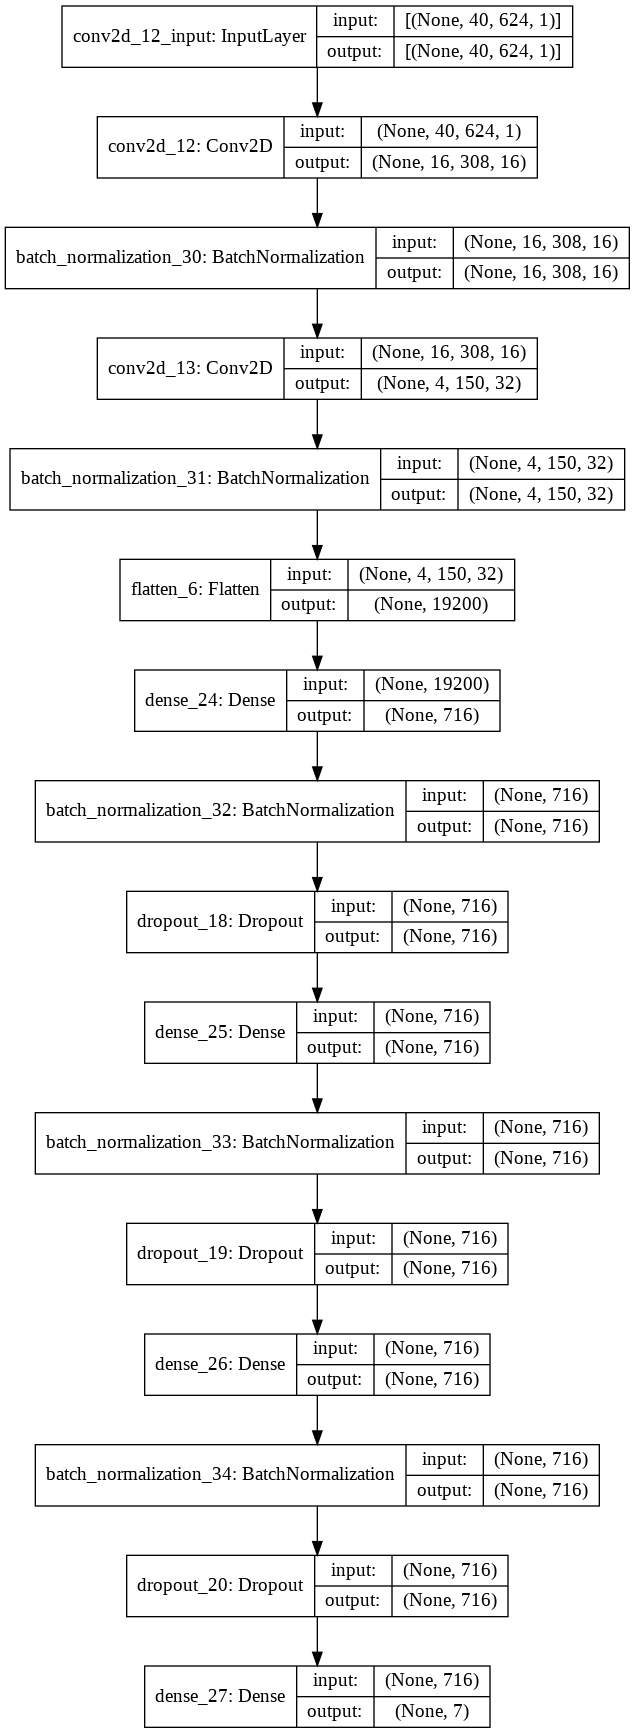

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(audio_model,to_file='audio_model1_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

xtrain = tf.expand_dims(X_tr_arr, axis=-1)
xtest= tf.expand_dims(X_te_arr, axis=-1)

print(xtrain.shape)
print(xtest.shape)
print(y_train_arr.shape)
print(y_te_arr.shape)

(773, 40, 624, 1)
(381, 40, 624, 1)
(773, 7)
(381, 7)


-------------------------------------
learnig rate:  0.0001
batch size:  8
normalized audio?:  False


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
97/97 [==============================] - 5s 30ms/step - loss: 2.1575 - categorical_accuracy: 0.1889 - accuracy: 0.1889 - val_loss: 2.1510 - val_categorical_accuracy: 0.1102 - val_accuracy: 0.1102
Epoch 2/50
97/97 [==============================] - 3s 26ms/step - loss: 2.1224 - categorical_accuracy: 0.2005 - accuracy: 0.2005 - val_loss: 2.1351 - val_categorical_accuracy: 0.1417 - val_accuracy: 0.1417
Epoch 3/50
97/97 [==============================] - 2s 25ms/step - loss: 2.0946 - categorical_accuracy: 0.2329 - accuracy: 0.2329 - val_loss: 2.1162 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
97/97 [==============================] - 2s 25ms/step - loss: 2.0678 - categorical_accuracy: 0.2471 - accuracy: 0.2471 - val_loss: 2.0982 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 5/50
97/97 [==============================] - 2s 25ms/step - loss: 2.0409 - categorical_accuracy: 0.2523 - accuracy: 0.2523 - val_loss: 2.0860 - val_categorical_accur

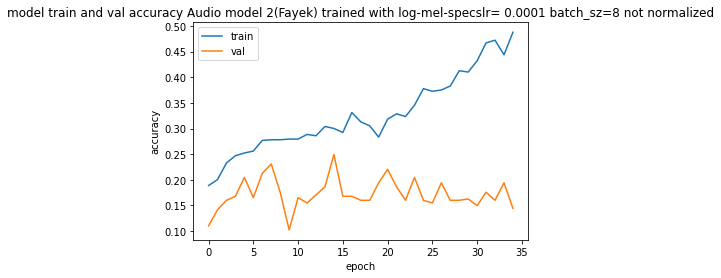

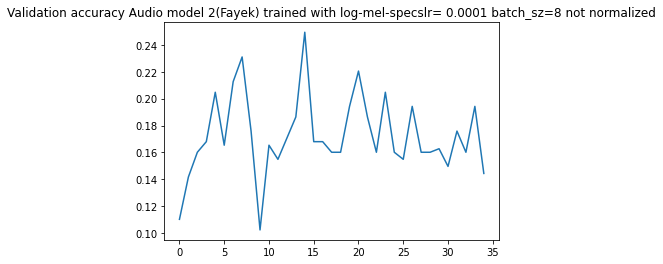

[[26  0  0 15 19  3  1]
 [ 0  1  1  4 32  2  0]
 [13  1  0 16 15  1  0]
 [ 5  0  0 16 36  6  0]
 [ 2  1  0  5 49  4  0]
 [ 9  0  0  8 41  3  0]
 [ 7  0  0 10 28  1  0]]

accuracy:  0.24934383202099739
f1 score: [0.41269841 0.04651163 0.         0.23357664 0.34875445 0.07407407
 0.        ]
f1 score weighted: 0.1805276426954395
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=8 not normalized


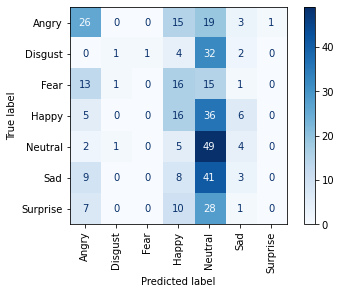

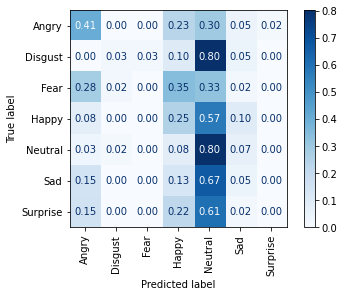

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 5s 30ms/step - loss: 2.1526 - categorical_accuracy: 0.1746 - accuracy: 0.1746 - val_loss: 2.1440 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 2/50
97/97 [==============================] - 3s 26ms/step - loss: 2.1236 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1247 - val_categorical_accuracy: 0.1496 - val_accuracy: 0.1496
Epoch 3/50
97/97 [==============================] - 2s 26ms/step - loss: 2.0927 - categorical_accuracy: 0.2186 - accuracy: 0.2186 - val_loss: 2.1039 - val_categorical_accuracy: 0.1837 - val_accuracy: 0.1837
Epoch 4/50
97/97 [==============================] - 3s 27ms/step - loss: 2.0636 - categorical_accuracy: 0.2290 - accuracy: 0.2290 - val_loss: 2.0918 - val_categorical_accuracy: 0.2730 - val_accuracy: 0.2730
Epoch 5/50
97/97 [==============================] - 3s 26ms/step - loss

<Figure size 432x288 with 0 Axes>

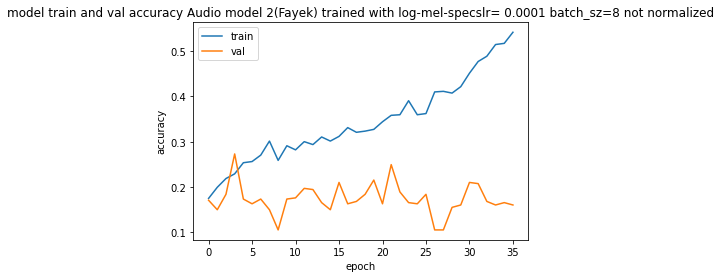

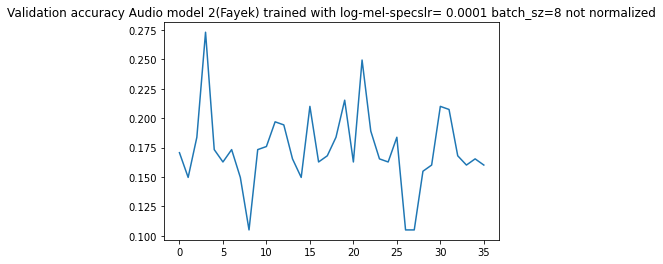

[[38  3  7  1  2 13  0]
 [15  1  1  2  3 18  0]
 [24  1  9  0  1 11  0]
 [28  2  2  0  5 26  0]
 [20  2  2  2  1 34  0]
 [24  2  1  0  3 31  0]
 [18  1  3  1  1 22  0]]

accuracy:  0.2099737532808399
f1 score: [0.32900433 0.03846154 0.25352113 0.         0.02597403 0.28703704
 0.        ]
f1 score weighted: 0.14002725792493267
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=8 not normalized


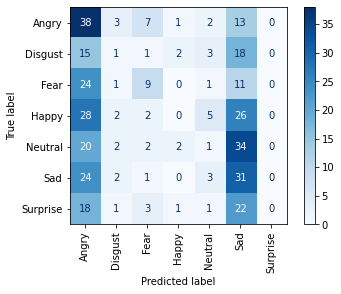

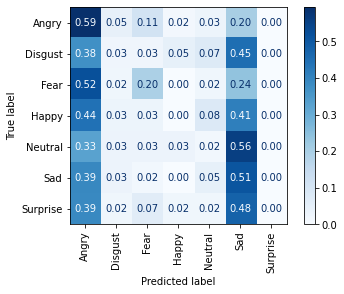

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 4s 41ms/step - loss: 2.1735 - categorical_accuracy: 0.1669 - accuracy: 0.1669 - val_loss: 2.1564 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 2/50
49/49 [==============================] - 2s 32ms/step - loss: 2.1277 - categorical_accuracy: 0.2057 - accuracy: 0.2057 - val_loss: 2.1409 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 3/50
49/49 [==============================] - 2s 32ms/step - loss: 2.0992 - categorical_accuracy: 0.2393 - accuracy: 0.2393 - val_loss: 2.1392 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 4/50
49/49 [==============================] - 2s 33ms/step - loss: 2.0943 - categorical_accuracy: 0.2303 - accuracy: 0.2303 - val_loss: 2.1246 - val_categorical_accuracy: 0.1759 - val_accuracy: 0.1759
Epoch 5/50
49/49 [==============================] - 2s 32ms/step - lo

<Figure size 432x288 with 0 Axes>

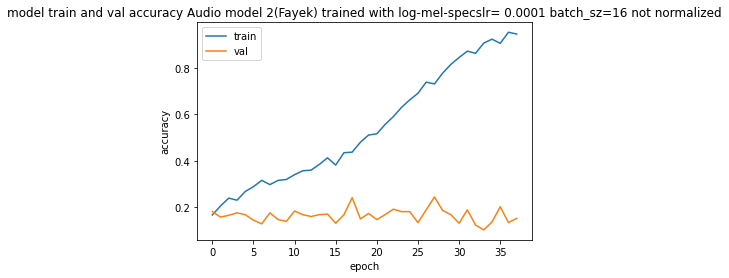

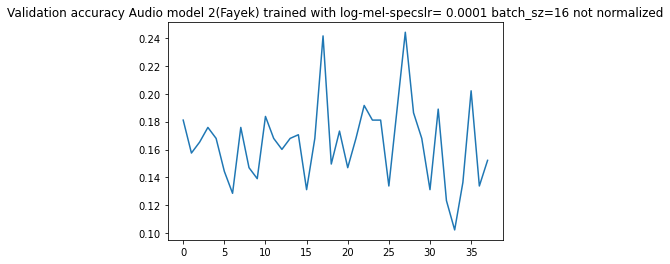

[[31  1  0 21  3  8  0]
 [ 4  0  0 19 11  6  0]
 [13  0  0 28  4  1  0]
 [ 9  0  0 40 10  4  0]
 [ 5  0  0 36 15  5  0]
 [16  0  0 27 12  6  0]
 [ 9  0  0 29  6  2  0]]

accuracy:  0.24146981627296588
f1 score: [0.41059603 0.         0.         0.30418251 0.24590164 0.12903226
 0.        ]
f1 score weighted: 0.17929819300829145
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=16 not normalized


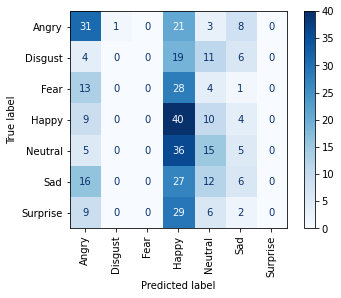

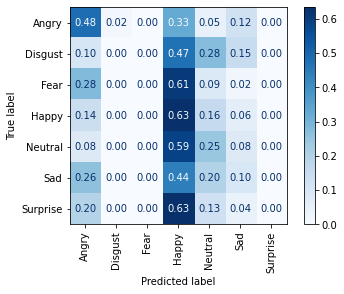

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 4s 39ms/step - loss: 2.1768 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1618 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
49/49 [==============================] - 2s 33ms/step - loss: 2.1378 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1538 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 3/50
49/49 [==============================] - 2s 32ms/step - loss: 2.1085 - categorical_accuracy: 0.2484 - accuracy: 0.2484 - val_loss: 2.1416 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 4/50
49/49 [==============================] - 2s 32ms/step - loss: 2.0949 - categorical_accuracy: 0.2613 - accuracy: 0.2613 - val_loss: 2.1256 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 5/50
49/49 [==============================] - 2s 32ms/step - los

<Figure size 432x288 with 0 Axes>

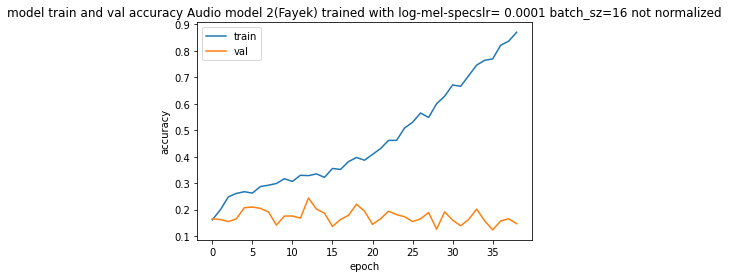

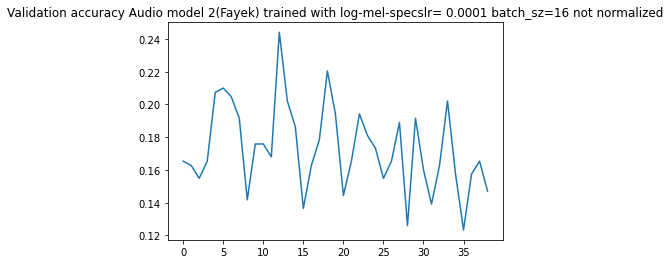

[[35  3  0 23  3  0  0]
 [ 9  2  0 22  7  0  0]
 [18  1  0 25  1  1  0]
 [11  5  1 38  7  1  0]
 [11  1  0 38  8  2  1]
 [14  1  0 35 10  1  0]
 [ 9  1  0 32  4  0  0]]

accuracy:  0.2204724409448819
f1 score: [0.40935673 0.07407407 0.         0.27536232 0.15841584 0.03030303
 0.        ]
f1 score weighted: 0.1522873245259704
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=16 not normalized


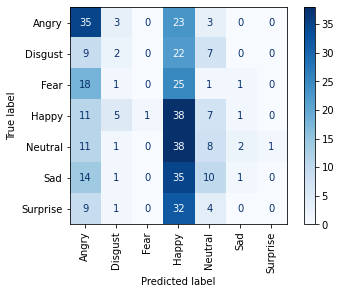

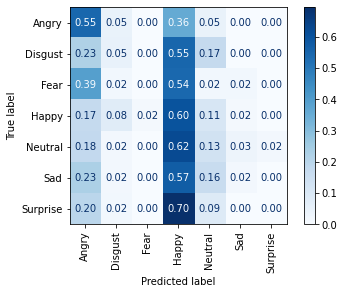

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 57ms/step - loss: 2.1751 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1648 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 2/50
25/25 [==============================] - 1s 40ms/step - loss: 2.1604 - categorical_accuracy: 0.1902 - accuracy: 0.1902 - val_loss: 2.1570 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 3/50
25/25 [==============================] - 1s 40ms/step - loss: 2.1380 - categorical_accuracy: 0.2173 - accuracy: 0.2173 - val_loss: 2.1485 - val_categorical_accuracy: 0.1312 - val_accuracy: 0.1312
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.0989 - categorical_accuracy: 0.2471 - accuracy: 0.2471 - val_loss: 2.1381 - val_categorical_accuracy: 0.1864 - val_accuracy: 0.1864
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - lo

<Figure size 432x288 with 0 Axes>

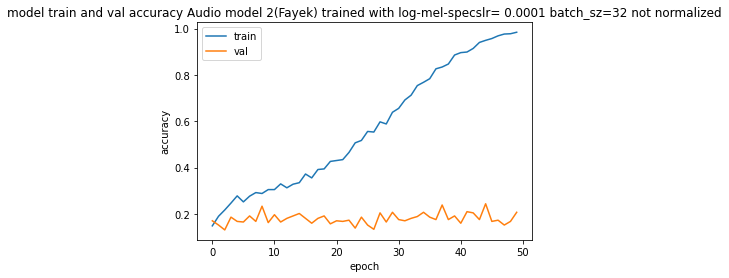

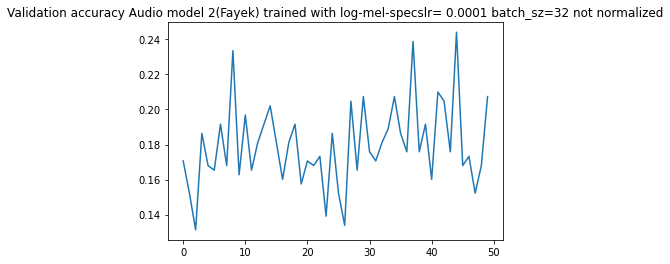

[[ 0  1  8 43  7  5  0]
 [ 0  0  0 18 13  8  1]
 [ 1  0  8 26  6  4  1]
 [ 0  0  0 42 14  5  2]
 [ 0  0  0 32 16 12  1]
 [ 0  0  1 30 16 12  2]
 [ 0  0  3 26  9  7  1]]

accuracy:  0.2073490813648294
f1 score: [0.         0.         0.24242424 0.3        0.22535211 0.21052632
 0.03703704]
f1 score weighted: 0.1531333411853443
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=32 not normalized


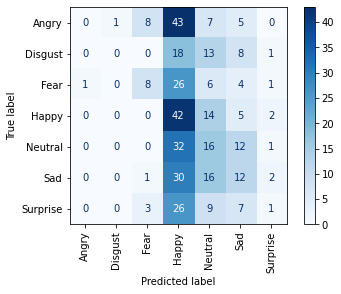

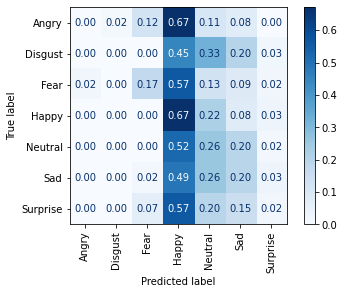

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 54ms/step - loss: 2.1621 - categorical_accuracy: 0.1604 - accuracy: 0.1604 - val_loss: 2.1590 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
25/25 [==============================] - 1s 39ms/step - loss: 2.1493 - categorical_accuracy: 0.2199 - accuracy: 0.2199 - val_loss: 2.1474 - val_categorical_accuracy: 0.1470 - val_accuracy: 0.1470
Epoch 3/50
25/25 [==============================] - 1s 40ms/step - loss: 2.1083 - categorical_accuracy: 0.2432 - accuracy: 0.2432 - val_loss: 2.1362 - val_categorical_accuracy: 0.1759 - val_accuracy: 0.1759
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.0997 - categorical_accuracy: 0.2251 - accuracy: 0.2251 - val_loss: 2.1264 - val_categorical_accuracy: 0.1942 - val_accuracy: 0.1942
Epoch 5/50
25/25 [==============================] - 1s 41ms/step - los

<Figure size 432x288 with 0 Axes>

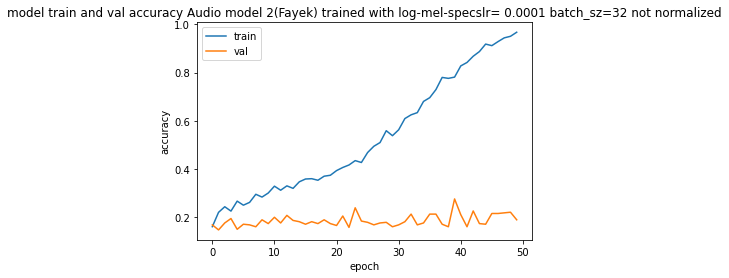

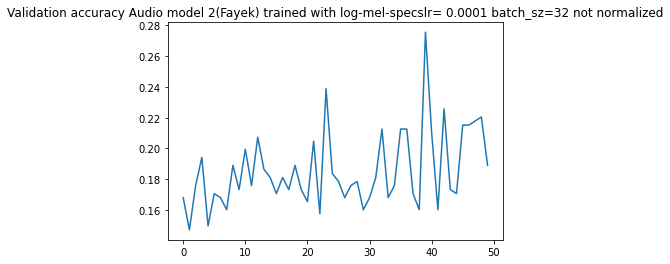

[[ 0  0  0 56  8  0  0]
 [ 0  0  0 28 12  0  0]
 [ 0  0  0 43  3  0  0]
 [ 0  0  1 53  9  0  0]
 [ 0  0  0 42 19  0  0]
 [ 0  0  0 43 18  0  0]
 [ 0  0  0 38  8  0  0]]

accuracy:  0.1889763779527559
f1 score: [0.         0.         0.         0.28961749 0.27536232 0.
 0.        ]
f1 score weighted: 0.0919763860593691
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=32 not normalized


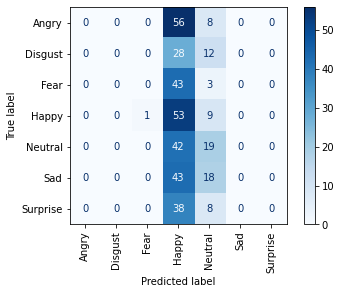

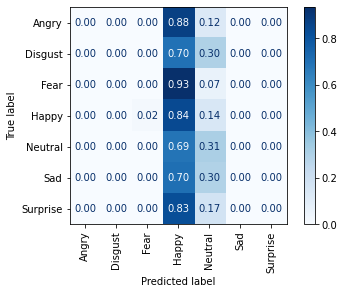

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 4s 100ms/step - loss: 2.1951 - categorical_accuracy: 0.1565 - accuracy: 0.1565 - val_loss: 2.1712 - val_categorical_accuracy: 0.1207 - val_accuracy: 0.1207
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1639 - categorical_accuracy: 0.2005 - accuracy: 0.2005 - val_loss: 2.1641 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 3/50
13/13 [==============================] - 1s 63ms/step - loss: 2.1318 - categorical_accuracy: 0.2160 - accuracy: 0.2160 - val_loss: 2.1594 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 4/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1237 - categorical_accuracy: 0.2264 - accuracy: 0.2264 - val_loss: 2.1554 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
13/13 [==============================] - 1s 66ms/step - l

<Figure size 432x288 with 0 Axes>

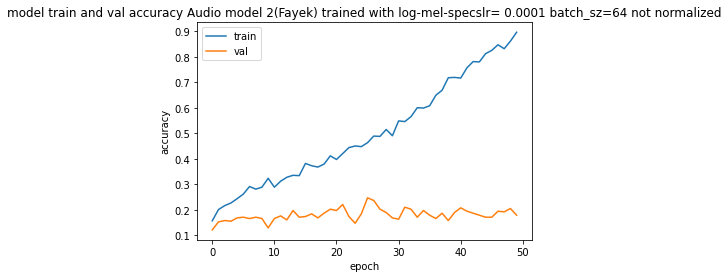

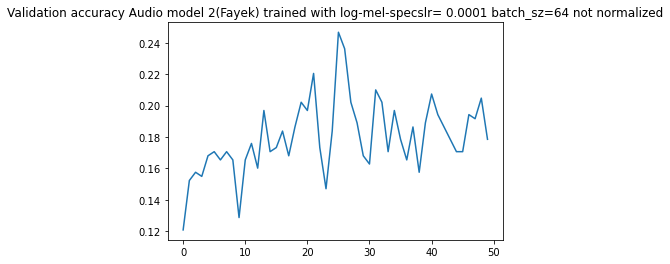

[[ 2  0  0 58  3  1  0]
 [ 0  0  0 36  2  2  0]
 [ 1  0  2 39  2  2  0]
 [ 1  0  0 54  8  0  0]
 [ 0  0  0 50  9  2  0]
 [ 1  0  0 51  8  1  0]
 [ 0  0  0 38  8  0  0]]

accuracy:  0.1784776902887139
f1 score: [0.05797101 0.         0.08333333 0.27763496 0.17821782 0.02898551
 0.        ]
f1 score weighted: 0.09888158504542127
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=64 not normalized


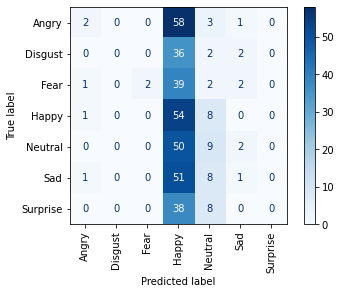

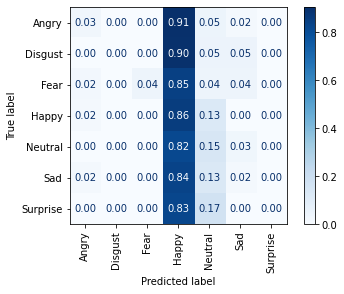

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 3s 96ms/step - loss: 2.1849 - categorical_accuracy: 0.1591 - accuracy: 0.1591 - val_loss: 2.1712 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1549 - categorical_accuracy: 0.1785 - accuracy: 0.1785 - val_loss: 2.1698 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 3/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1524 - categorical_accuracy: 0.2044 - accuracy: 0.2044 - val_loss: 2.1718 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 4/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1542 - categorical_accuracy: 0.2135 - accuracy: 0.2135 - val_loss: 2.1686 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
13/13 [==============================] - 1s 64ms/step - los

<Figure size 432x288 with 0 Axes>

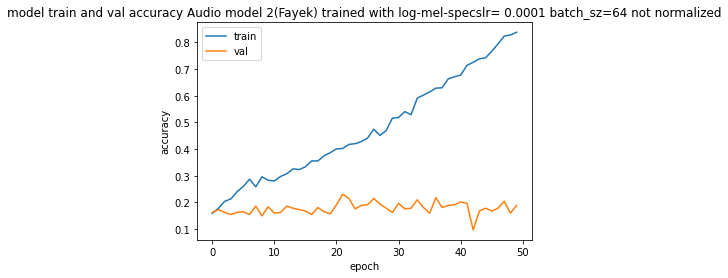

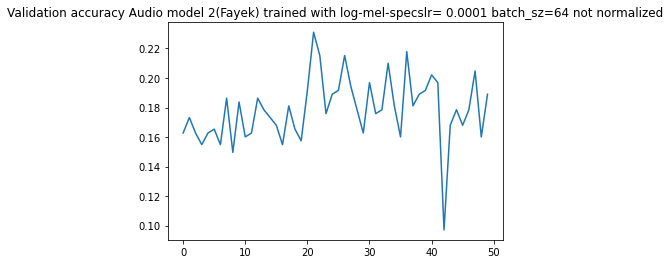

[[ 0  0  0 12 44  7  1]
 [ 0  0  0  2 37  1  0]
 [ 0  1  0 14 30  0  1]
 [ 0  0  0  9 52  2  0]
 [ 0  0  0  1 60  0  0]
 [ 0  1  0  4 53  3  0]
 [ 0  0  0  5 39  2  0]]

accuracy:  0.1889763779527559
f1 score: [0.         0.         0.         0.16363636 0.31914894 0.07894737
 0.        ]
f1 score weighted: 0.09079518501091365
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=64 not normalized


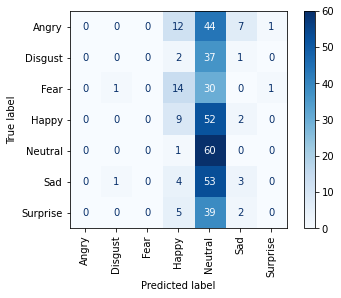

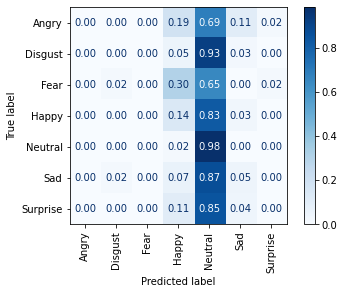

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  8
normalized audio?:  False
Epoch 1/50
97/97 [==============================] - 6s 34ms/step - loss: 2.1776 - categorical_accuracy: 0.1552 - accuracy: 0.1552 - val_loss: 2.1696 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1580 - categorical_accuracy: 0.2109 - accuracy: 0.2109 - val_loss: 2.1597 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 3/50
97/97 [==============================] - 3s 31ms/step - loss: 2.1389 - categorical_accuracy: 0.2173 - accuracy: 0.2173 - val_loss: 2.1525 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 4/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1217 - categorical_accuracy: 0.2238 - accuracy: 0.2238 - val_loss: 2.1477 - val_categorical_accuracy: 0.1969 - val_accuracy: 0.1969
Epoch 5/50
97/97 [==============================] - 3s 30ms/step - loss

<Figure size 432x288 with 0 Axes>

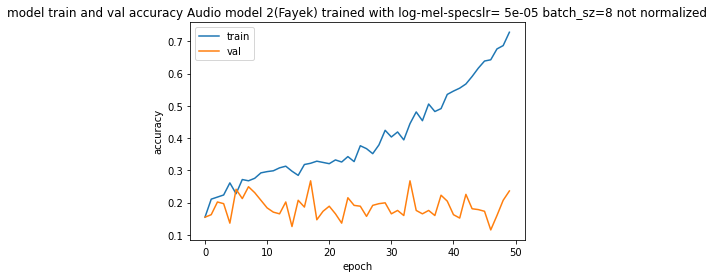

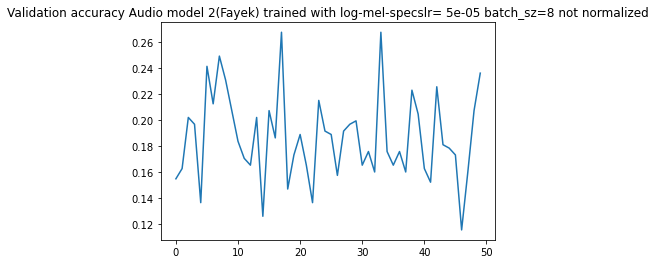

[[ 5  2  3  6 22 25  1]
 [ 0  0  0  6 12 22  0]
 [ 0  2  1  5 11 25  2]
 [ 0  0  0 12 21 29  1]
 [ 0  0  1  4 27 28  1]
 [ 0  0  0  4 10 45  2]
 [ 0  1  0  7  8 30  0]]

accuracy:  0.23622047244094488
f1 score: [0.14492754 0.         0.03921569 0.22429907 0.31395349 0.33962264
 0.        ]
f1 score weighted: 0.17080910480770736
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=8 not normalized


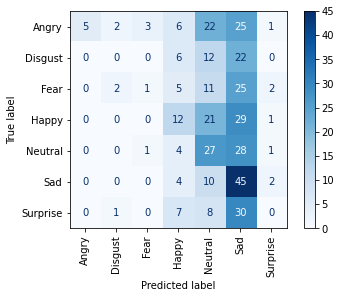

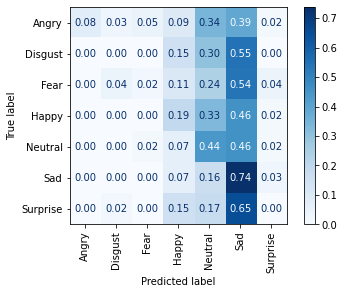

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 6s 35ms/step - loss: 2.1794 - categorical_accuracy: 0.1630 - accuracy: 0.1630 - val_loss: 2.1634 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1501 - categorical_accuracy: 0.1928 - accuracy: 0.1928 - val_loss: 2.1533 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 3/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1228 - categorical_accuracy: 0.2238 - accuracy: 0.2238 - val_loss: 2.1396 - val_categorical_accuracy: 0.2047 - val_accuracy: 0.2047
Epoch 4/50
97/97 [==============================] - 3s 31ms/step - loss: 2.1130 - categorical_accuracy: 0.2238 - accuracy: 0.2238 - val_loss: 2.1350 - val_categorical_accuracy: 0.2126 - val_accuracy: 0.2126
Epoch 5/50
97/97 [==============================] - 3s 29ms/step - loss:

<Figure size 432x288 with 0 Axes>

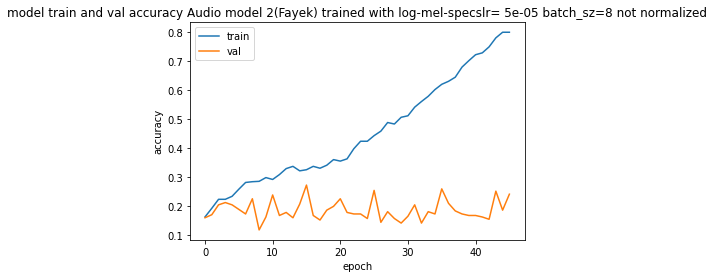

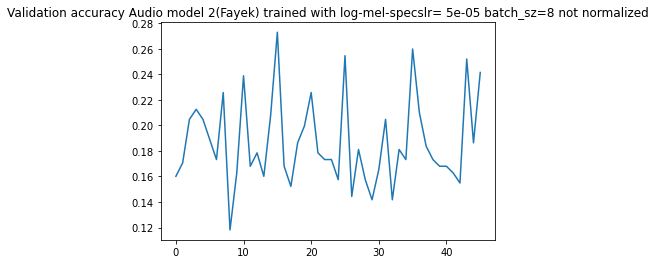

[[38  1  1 19  4  1  0]
 [ 9  1  0 16  8  6  0]
 [13  0  0 29  3  1  0]
 [11  0  0 37  8  7  0]
 [11  0  0 29 14  7  0]
 [13  0  0 26 15  7  0]
 [ 6  0  0 30  8  2  0]]

accuracy:  0.2545931758530184
f1 score: [0.46060606 0.04761905 0.         0.29718876 0.23140496 0.15217391
 0.        ]
f1 score weighted: 0.19292585964515976
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=8 not normalized


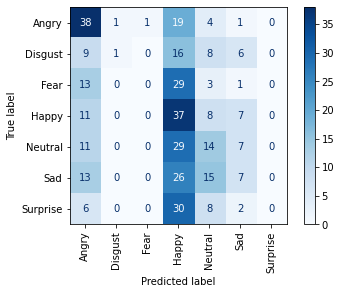

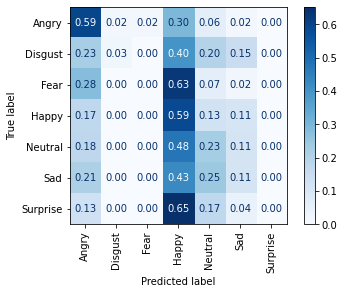

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 4s 43ms/step - loss: 2.1768 - categorical_accuracy: 0.1539 - accuracy: 0.1539 - val_loss: 2.1681 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1552 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1591 - val_categorical_accuracy: 0.1365 - val_accuracy: 0.1365
Epoch 3/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1480 - categorical_accuracy: 0.1915 - accuracy: 0.1915 - val_loss: 2.1496 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 4/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1121 - categorical_accuracy: 0.2238 - accuracy: 0.2238 - val_loss: 2.1418 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 5/50
49/49 [==============================] - 2s 34ms/step - los

<Figure size 432x288 with 0 Axes>

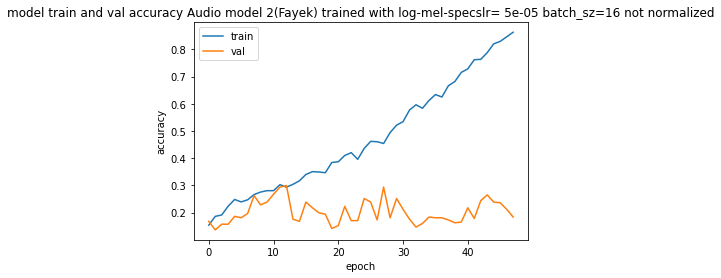

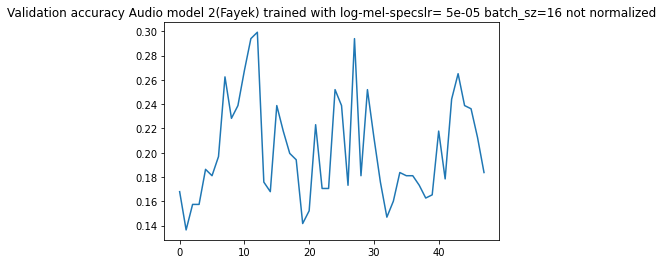

[[35  0  2 13 14  0  0]
 [ 6  0  1  4 26  3  0]
 [16  0  2 13 13  2  0]
 [ 9  0  2 21 28  3  0]
 [ 4  1  0  4 51  1  0]
 [ 8  0  0 11 39  3  0]
 [ 6  0  1 11 26  2  0]]

accuracy:  0.29396325459317585
f1 score: [0.47297297 0.         0.07407407 0.3        0.39534884 0.08
 0.        ]
f1 score weighted: 0.21410487335287434
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=16 not normalized


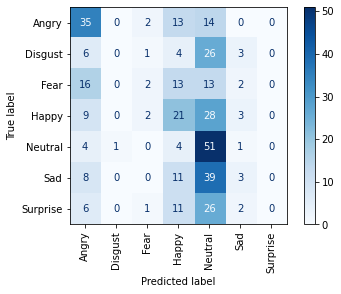

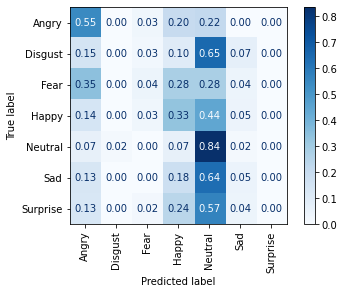

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 4s 44ms/step - loss: 2.1845 - categorical_accuracy: 0.1604 - accuracy: 0.1604 - val_loss: 2.1589 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 2/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1547 - categorical_accuracy: 0.1591 - accuracy: 0.1591 - val_loss: 2.1465 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 3/50
49/49 [==============================] - 2s 36ms/step - loss: 2.1182 - categorical_accuracy: 0.1940 - accuracy: 0.1940 - val_loss: 2.1373 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1140 - categorical_accuracy: 0.2005 - accuracy: 0.2005 - val_loss: 2.1263 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 5/50
49/49 [==============================] - 2s 34ms/step - loss

<Figure size 432x288 with 0 Axes>

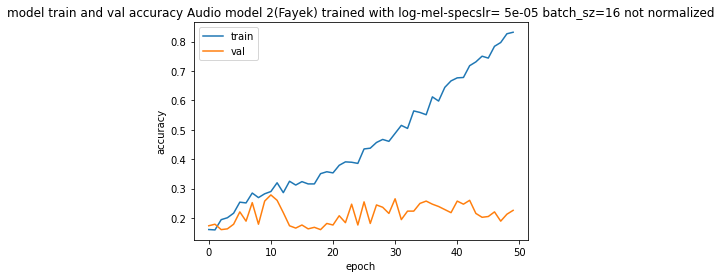

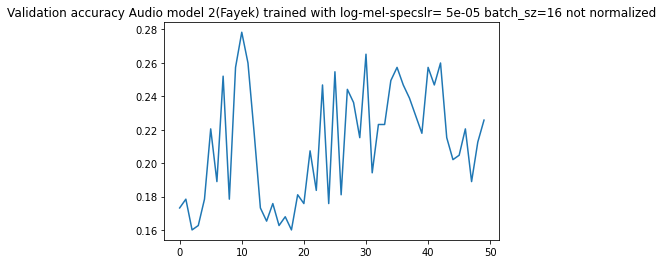

[[10  0  2 29  1 21  1]
 [ 2  0  0 14  5 18  1]
 [ 2  0  0 31  2 10  1]
 [ 1  0  1 35 12 14  0]
 [ 0  0  0 25 15 20  1]
 [ 2  0  1 19 13 26  0]
 [ 1  0  0 22  7 16  0]]

accuracy:  0.22572178477690288
f1 score: [0.24390244 0.         0.         0.29411765 0.25862069 0.27956989
 0.        ]
f1 score weighted: 0.17577111121284145
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=16 not normalized


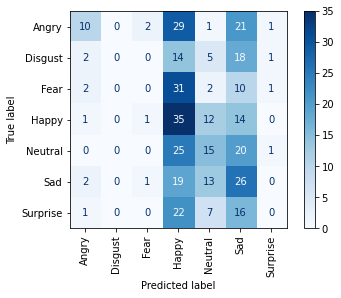

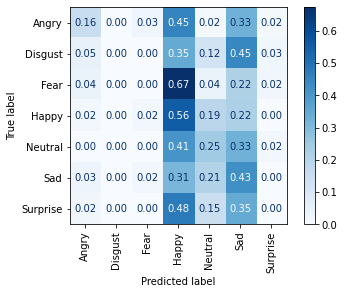

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 61ms/step - loss: 2.1927 - categorical_accuracy: 0.1371 - accuracy: 0.1371 - val_loss: 2.1698 - val_categorical_accuracy: 0.1339 - val_accuracy: 0.1339
Epoch 2/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1633 - categorical_accuracy: 0.1798 - accuracy: 0.1798 - val_loss: 2.1655 - val_categorical_accuracy: 0.1391 - val_accuracy: 0.1391
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1494 - categorical_accuracy: 0.1837 - accuracy: 0.1837 - val_loss: 2.1598 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1277 - categorical_accuracy: 0.2225 - accuracy: 0.2225 - val_loss: 2.1549 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 5/50
25/25 [==============================] - 1s 42ms/step - los

<Figure size 432x288 with 0 Axes>

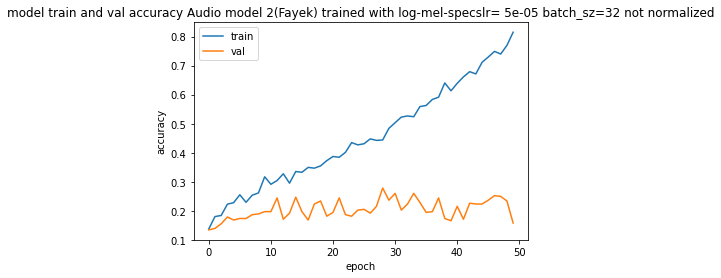

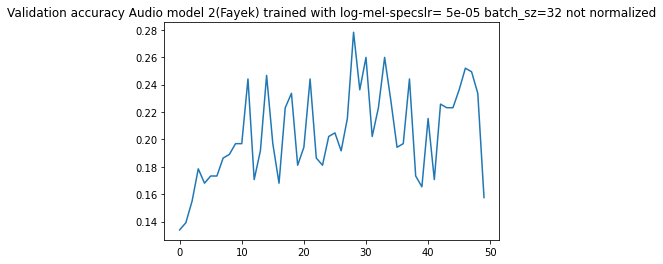

[[ 0  0  0  6 57  1  0]
 [ 0  0  0  1 39  0  0]
 [ 0  0  0  2 44  0  0]
 [ 0  0  0  1 62  0  0]
 [ 0  1  0  0 59  1  0]
 [ 0  0  0  1 60  0  0]
 [ 0  0  0  2 44  0  0]]

accuracy:  0.15748031496062992
f1 score: [0.         0.         0.         0.02631579 0.27699531 0.
 0.        ]
f1 score weighted: 0.04869975945371543
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=32 not normalized


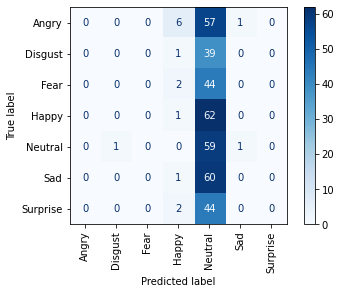

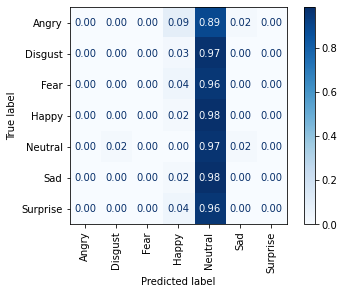

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 59ms/step - loss: 2.1864 - categorical_accuracy: 0.1320 - accuracy: 0.1320 - val_loss: 2.1726 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1641 - categorical_accuracy: 0.1902 - accuracy: 0.1902 - val_loss: 2.1680 - val_categorical_accuracy: 0.1391 - val_accuracy: 0.1391
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1482 - categorical_accuracy: 0.1953 - accuracy: 0.1953 - val_loss: 2.1639 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1378 - categorical_accuracy: 0.2109 - accuracy: 0.2109 - val_loss: 2.1597 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 5/50
25/25 [==============================] - 1s 42ms/step - loss

<Figure size 432x288 with 0 Axes>

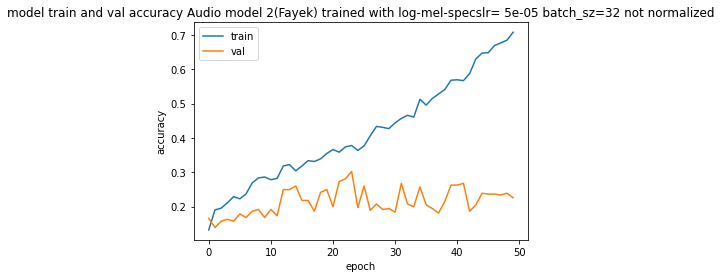

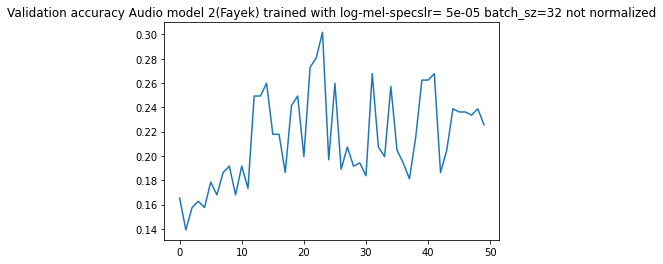

[[43  0  1 15  3  2  0]
 [20  0  0 11  3  6  0]
 [24  0  3 13  0  6  0]
 [23  0  4 25  3  8  0]
 [28  0  0 23  3  7  0]
 [23  0  2 19  4 12  1]
 [21  0  3 11  3  8  0]]

accuracy:  0.22572178477690288
f1 score: [0.3495935  0.         0.10169492 0.27777778 0.075      0.21818182
 0.        ]
f1 score weighted: 0.16387412270504784
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=32 not normalized


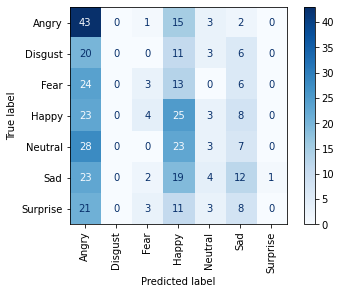

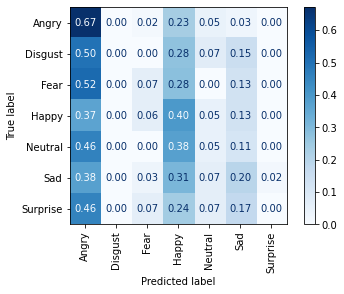

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 4s 94ms/step - loss: 2.1969 - categorical_accuracy: 0.1539 - accuracy: 0.1539 - val_loss: 2.1702 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
13/13 [==============================] - 1s 63ms/step - loss: 2.1645 - categorical_accuracy: 0.1798 - accuracy: 0.1798 - val_loss: 2.1671 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 3/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1473 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1644 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 4/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1439 - categorical_accuracy: 0.2005 - accuracy: 0.2005 - val_loss: 2.1615 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 5/50
13/13 [==============================] - 1s 57ms/step - los

<Figure size 432x288 with 0 Axes>

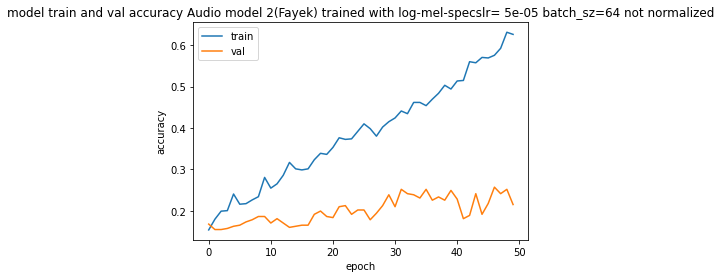

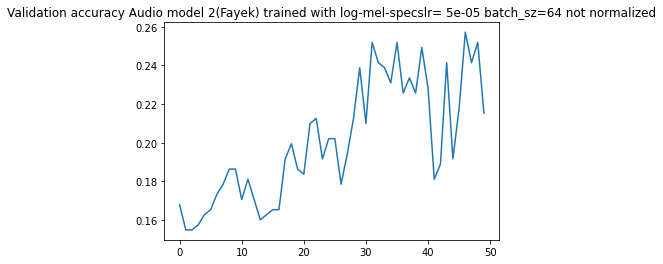

[[46  0  2 14  1  1  0]
 [18  0  0 15  1  6  0]
 [29  0  0 14  2  1  0]
 [25  0  1 28  3  6  0]
 [21  0  1 31  2  6  0]
 [28  0  0 26  1  6  0]
 [22  0  1 20  1  2  0]]

accuracy:  0.2152230971128609
f1 score: [0.36363636 0.         0.         0.26540284 0.05555556 0.13483146
 0.        ]
f1 score weighted: 0.1354506939886068
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=64 not normalized


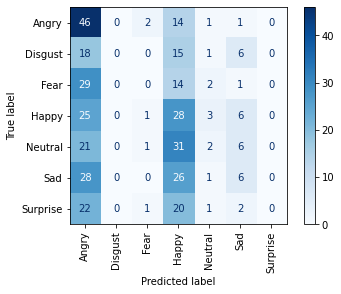

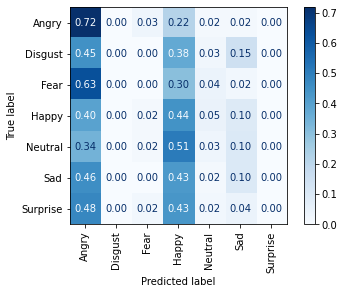

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 4s 95ms/step - loss: 2.1835 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1714 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1745 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1684 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1562 - categorical_accuracy: 0.2057 - accuracy: 0.2057 - val_loss: 2.1669 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
13/13 [==============================] - 1s 57ms/step - loss: 2.1522 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1648 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 5/50
13/13 [==============================] - 1s 59ms/step - loss

<Figure size 432x288 with 0 Axes>

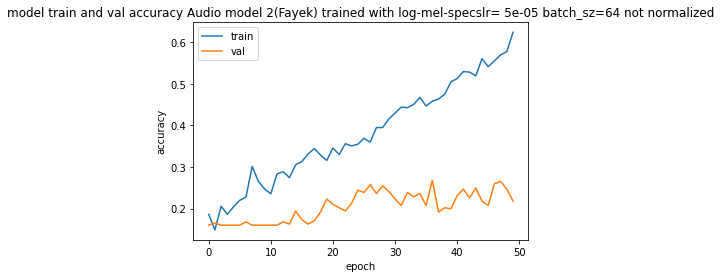

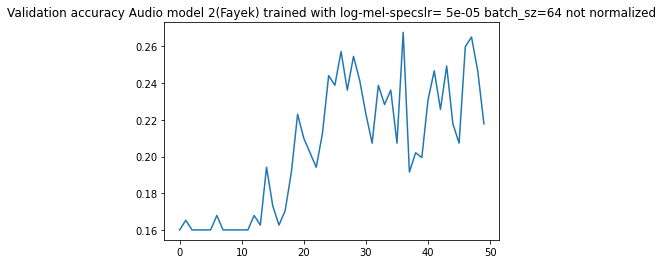

[[ 4  0  0 28 26  6  0]
 [ 0  1  0  4 35  0  0]
 [ 0  0  0 28 17  1  0]
 [ 0  0  0 24 35  4  0]
 [ 0  0  0 10 49  2  0]
 [ 0  0  0 11 45  5  0]
 [ 1  0  0 15 29  1  0]]

accuracy:  0.2178477690288714
f1 score: [0.11594203 0.04878049 0.         0.26229508 0.32996633 0.125
 0.        ]
f1 score weighted: 0.1408111434623311
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=64 not normalized


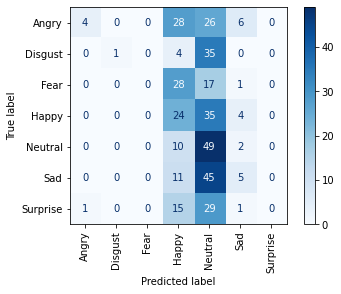

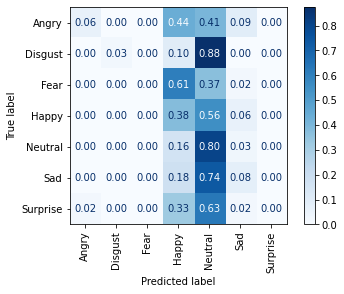

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  8
normalized audio?:  False
Epoch 1/50
97/97 [==============================] - 5s 33ms/step - loss: 2.1827 - categorical_accuracy: 0.1449 - accuracy: 0.1449 - val_loss: 2.1725 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 2/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1724 - categorical_accuracy: 0.1695 - accuracy: 0.1695 - val_loss: 2.1685 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 3/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1738 - categorical_accuracy: 0.1449 - accuracy: 0.1449 - val_loss: 2.1638 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 4/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1672 - categorical_accuracy: 0.1643 - accuracy: 0.1643 - val_loss: 2.1604 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 5/50
97/97 [==============================] - 3s 29ms/step - loss

<Figure size 432x288 with 0 Axes>

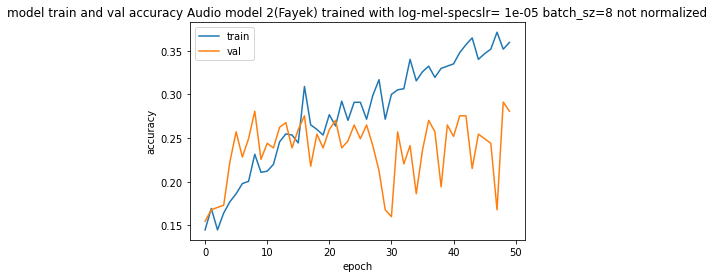

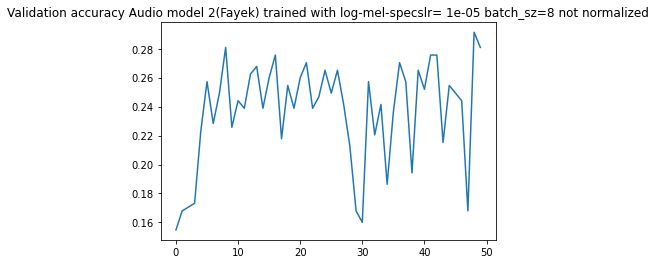

[[41  1  0  6 12  2  2]
 [ 5  0  0  4 29  2  0]
 [21  0  0 14  9  1  1]
 [ 8  0  0 24 26  5  0]
 [ 3  2  0 15 38  3  0]
 [11  0  0  9 37  4  0]
 [10  0  0 13 21  2  0]]

accuracy:  0.28083989501312334
f1 score: [0.50306748 0.         0.         0.32432432 0.32618026 0.1
 0.        ]
f1 score weighted: 0.20636679044354814
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=8 not normalized


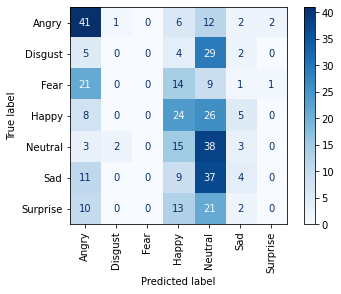

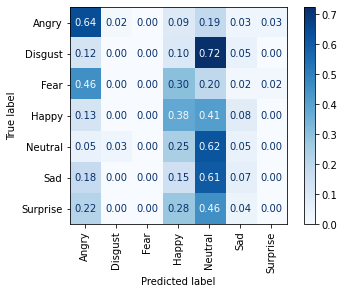

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 6s 34ms/step - loss: 2.1922 - categorical_accuracy: 0.1436 - accuracy: 0.1436 - val_loss: 2.1744 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1748 - categorical_accuracy: 0.1591 - accuracy: 0.1591 - val_loss: 2.1726 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 3/50
97/97 [==============================] - 3s 30ms/step - loss: 2.1774 - categorical_accuracy: 0.1669 - accuracy: 0.1669 - val_loss: 2.1699 - val_categorical_accuracy: 0.1995 - val_accuracy: 0.1995
Epoch 4/50
97/97 [==============================] - 3s 31ms/step - loss: 2.1731 - categorical_accuracy: 0.1682 - accuracy: 0.1682 - val_loss: 2.1676 - val_categorical_accuracy: 0.2178 - val_accuracy: 0.2178
Epoch 5/50
97/97 [==============================] - 3s 30ms/step - loss:

<Figure size 432x288 with 0 Axes>

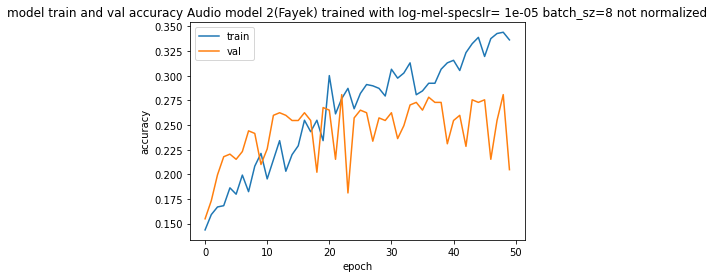

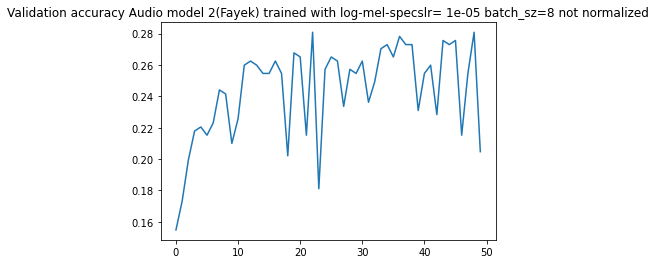

[[53  1  0  6  4  0  0]
 [25  0  0  8  3  4  0]
 [40  0  0  5  1  0  0]
 [36  0  0 19  3  5  0]
 [37  0  0 17  3  4  0]
 [37  1  0 17  3  3  0]
 [30  0  0 14  1  1  0]]

accuracy:  0.2047244094488189
f1 score: [0.32919255 0.         0.         0.25503356 0.07594937 0.07692308
 0.        ]
f1 score weighted: 0.12194397942267442
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=8 not normalized


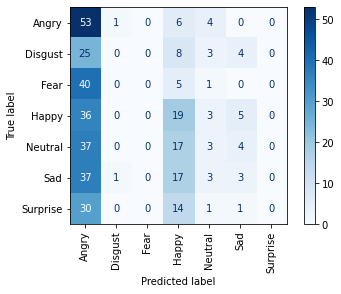

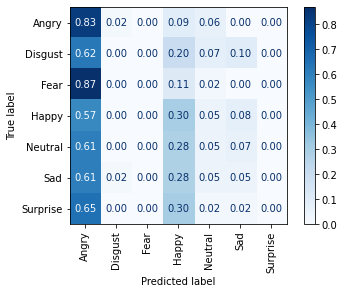

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 4s 43ms/step - loss: 2.1906 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1758 - val_categorical_accuracy: 0.1496 - val_accuracy: 0.1496
Epoch 2/50
49/49 [==============================] - 2s 36ms/step - loss: 2.1869 - categorical_accuracy: 0.1785 - accuracy: 0.1785 - val_loss: 2.1741 - val_categorical_accuracy: 0.1470 - val_accuracy: 0.1470
Epoch 3/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1586 - categorical_accuracy: 0.1902 - accuracy: 0.1902 - val_loss: 2.1725 - val_categorical_accuracy: 0.1339 - val_accuracy: 0.1339
Epoch 4/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1670 - categorical_accuracy: 0.1772 - accuracy: 0.1772 - val_loss: 2.1707 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 5/50
49/49 [==============================] - 2s 35ms/step - los

<Figure size 432x288 with 0 Axes>

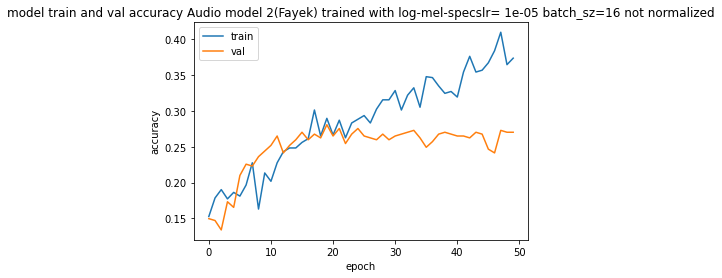

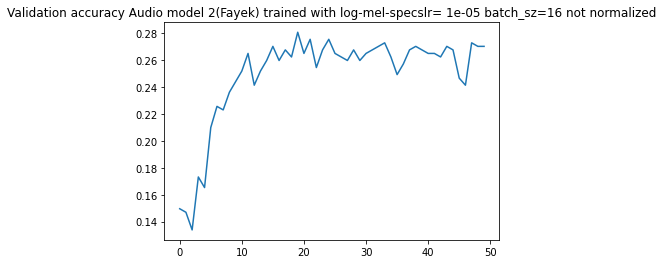

[[42  0  1 11  7  3  0]
 [ 8  0  0  7 22  3  0]
 [23  1  3 11  8  0  0]
 [12  0  1 24 22  4  0]
 [ 8  2  0 19 31  1  0]
 [13  0  1 12 32  3  0]
 [11  1  1 19 13  1  0]]

accuracy:  0.27034120734908135
f1 score: [0.4640884  0.         0.11320755 0.28915663 0.31632653 0.07894737
 0.        ]
f1 score weighted: 0.20272383186164178
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=16 not normalized


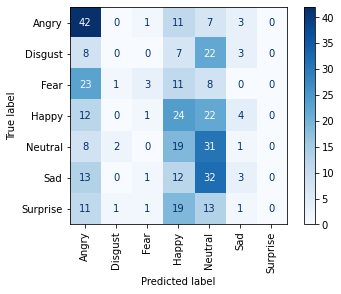

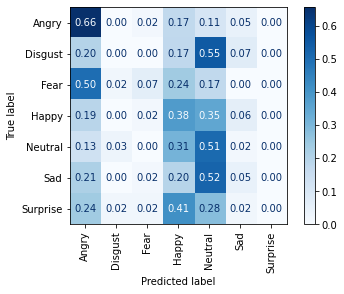

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 5s 44ms/step - loss: 2.1840 - categorical_accuracy: 0.1501 - accuracy: 0.1501 - val_loss: 2.1744 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1823 - categorical_accuracy: 0.1501 - accuracy: 0.1501 - val_loss: 2.1712 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 3/50
49/49 [==============================] - 2s 38ms/step - loss: 2.1756 - categorical_accuracy: 0.1669 - accuracy: 0.1669 - val_loss: 2.1679 - val_categorical_accuracy: 0.1969 - val_accuracy: 0.1969
Epoch 4/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1700 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 2.1648 - val_categorical_accuracy: 0.1969 - val_accuracy: 0.1969
Epoch 5/50
49/49 [==============================] - 2s 35ms/step - loss

<Figure size 432x288 with 0 Axes>

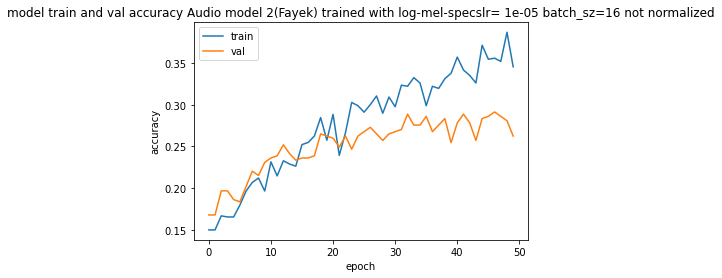

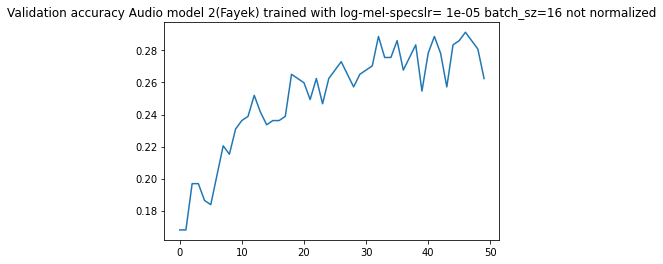

[[36  0  2 16  9  1  0]
 [ 4  0  0 15 18  3  0]
 [16  0  2 19  9  0  0]
 [ 9  0  2 26 21  5  0]
 [ 2  0  0 24 32  3  0]
 [10  0  2 14 31  4  0]
 [ 9  1  2 21 12  1  0]]

accuracy:  0.26246719160104987
f1 score: [0.48       0.         0.07142857 0.26262626 0.33160622 0.1025641
 0.        ]
f1 score weighted: 0.2021930665674291
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=16 not normalized


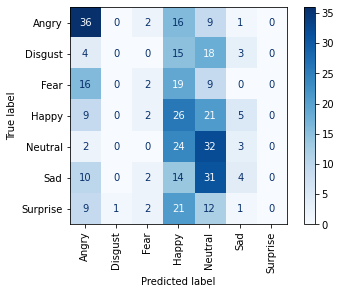

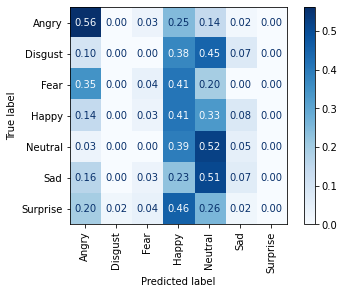

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 58ms/step - loss: 2.1965 - categorical_accuracy: 0.1294 - accuracy: 0.1294 - val_loss: 2.1744 - val_categorical_accuracy: 0.1444 - val_accuracy: 0.1444
Epoch 2/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1870 - categorical_accuracy: 0.1514 - accuracy: 0.1514 - val_loss: 2.1732 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1830 - categorical_accuracy: 0.1514 - accuracy: 0.1514 - val_loss: 2.1721 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1698 - categorical_accuracy: 0.1591 - accuracy: 0.1591 - val_loss: 2.1710 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
25/25 [==============================] - 1s 41ms/step - los

<Figure size 432x288 with 0 Axes>

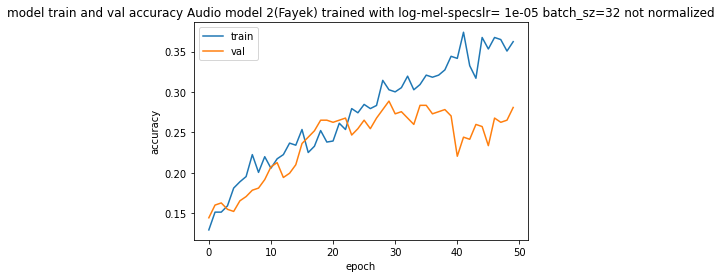

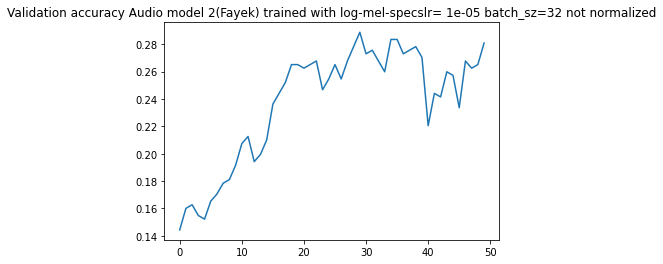

[[40  1  0 15  6  2  0]
 [ 4  1  0 10 25  0  0]
 [16  0  2 17 10  0  1]
 [ 8  0  1 27 27  0  0]
 [ 5  1  0 17 36  2  0]
 [11  0  1 13 35  1  0]
 [ 7  0  1 22 15  1  0]]

accuracy:  0.28083989501312334
f1 score: [0.51612903 0.04651163 0.07843137 0.29347826 0.33488372 0.02985075
 0.        ]
f1 score weighted: 0.20797506365345136
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=32 not normalized


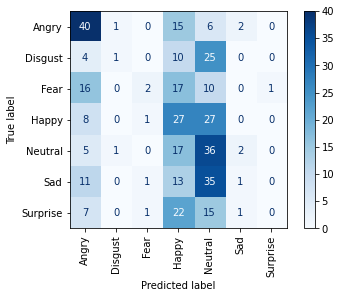

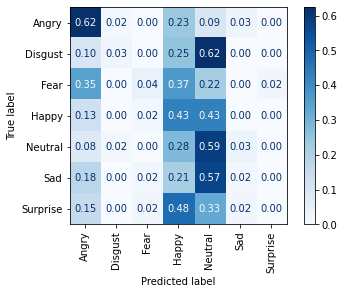

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 62ms/step - loss: 2.1922 - categorical_accuracy: 0.1332 - accuracy: 0.1332 - val_loss: 2.1772 - val_categorical_accuracy: 0.1496 - val_accuracy: 0.1496
Epoch 2/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1902 - categorical_accuracy: 0.1514 - accuracy: 0.1514 - val_loss: 2.1769 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1869 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1762 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1660 - categorical_accuracy: 0.1708 - accuracy: 0.1708 - val_loss: 2.1756 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 5/50
25/25 [==============================] - 1s 44ms/step - loss

<Figure size 432x288 with 0 Axes>

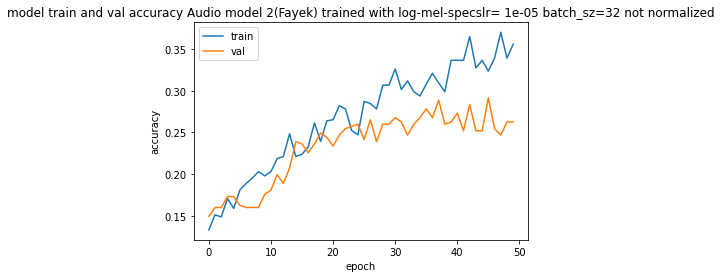

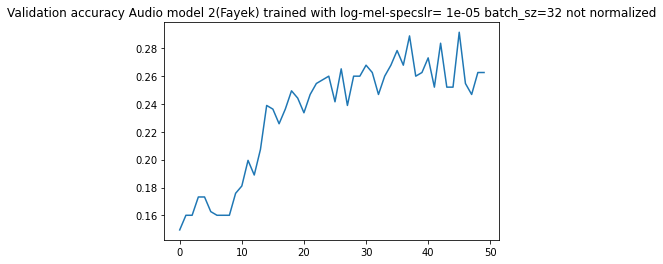

[[48  0  3 10  3  0  0]
 [15  0  1 10 12  2  0]
 [28  0  2 12  3  1  0]
 [15  0  1 30  9  7  1]
 [12  1  0 29 15  4  0]
 [17  0  0 22 17  5  0]
 [14  0  0 23  5  4  0]]

accuracy:  0.26246719160104987
f1 score: [0.45070423 0.         0.0754717  0.30150754 0.24       0.11904762
 0.        ]
f1 score weighted: 0.1921618062257726
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=32 not normalized


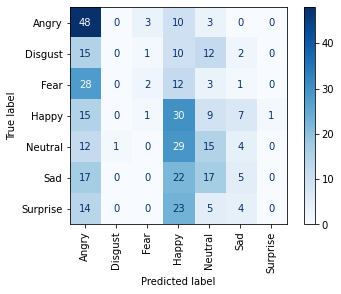

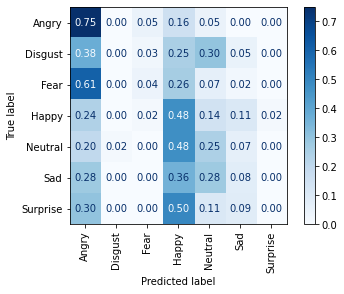

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 3s 95ms/step - loss: 2.2002 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1764 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1815 - categorical_accuracy: 0.1332 - accuracy: 0.1332 - val_loss: 2.1753 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 3/50
13/13 [==============================] - 1s 63ms/step - loss: 2.1922 - categorical_accuracy: 0.1397 - accuracy: 0.1397 - val_loss: 2.1741 - val_categorical_accuracy: 0.1470 - val_accuracy: 0.1470
Epoch 4/50
13/13 [==============================] - 1s 57ms/step - loss: 2.1828 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1731 - val_categorical_accuracy: 0.1391 - val_accuracy: 0.1391
Epoch 5/50
13/13 [==============================] - 1s 62ms/step - los

<Figure size 432x288 with 0 Axes>

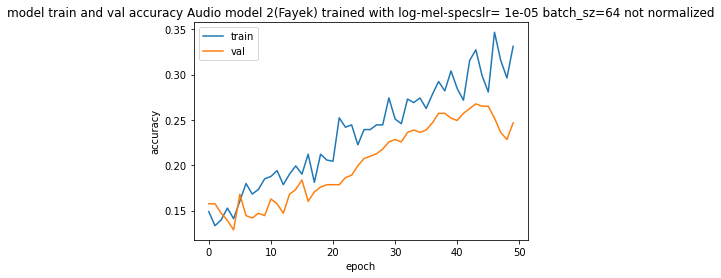

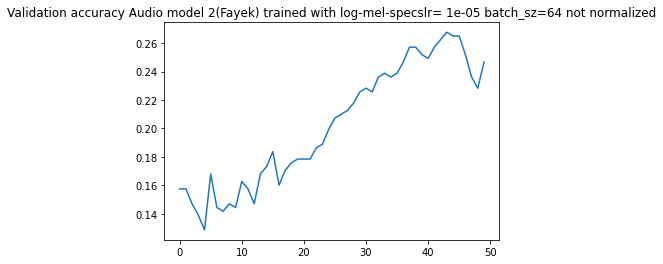

[[38  0  0 18  7  0  1]
 [ 9  0  0 13 15  3  0]
 [17  0  1 20  7  1  0]
 [15  0  1 29 15  3  0]
 [12  0  0 24 23  2  0]
 [15  0  0 21 22  3  0]
 [12  1  0 24  9  0  0]]

accuracy:  0.24671916010498687
f1 score: [0.41758242 0.         0.04166667 0.27358491 0.28930818 0.08219178
 0.        ]
f1 score weighted: 0.179893143886668
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=64 not normalized


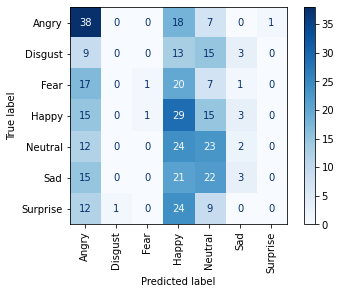

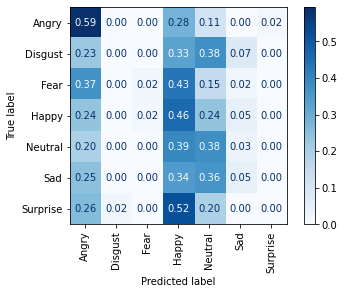

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 4s 99ms/step - loss: 2.1938 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1783 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1790 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1774 - val_categorical_accuracy: 0.1260 - val_accuracy: 0.1260
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1883 - categorical_accuracy: 0.1539 - accuracy: 0.1539 - val_loss: 2.1768 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
13/13 [==============================] - 1s 62ms/step - loss: 2.1790 - categorical_accuracy: 0.1436 - accuracy: 0.1436 - val_loss: 2.1765 - val_categorical_accuracy: 0.1759 - val_accuracy: 0.1759
Epoch 5/50
13/13 [==============================] - 1s 62ms/step - loss

<Figure size 432x288 with 0 Axes>

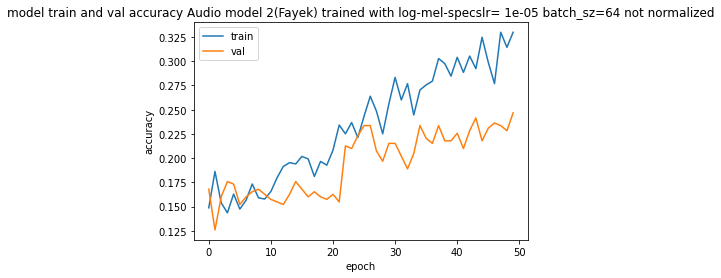

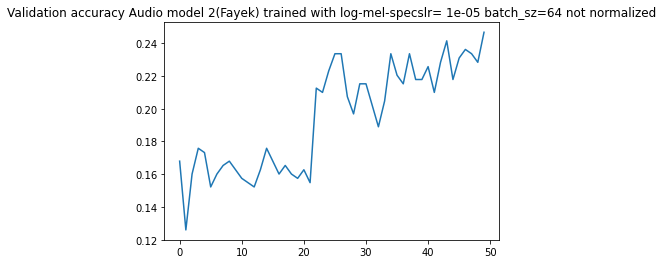

[[34  0  3 13  9  5  0]
 [ 4  0  0 12 19  5  0]
 [16  0  1 14 11  2  2]
 [ 9  1  2 23 25  3  0]
 [ 5  0  0 22 33  1  0]
 [ 9  1  1 19 29  2  0]
 [10  0  2 17 14  2  1]]

accuracy:  0.24671916010498687
f1 score: [0.45033113 0.         0.03636364 0.25136612 0.32835821 0.04938272
 0.04081633]
f1 score weighted: 0.18700717150962484
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=64 not normalized


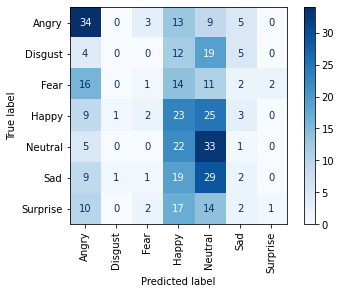

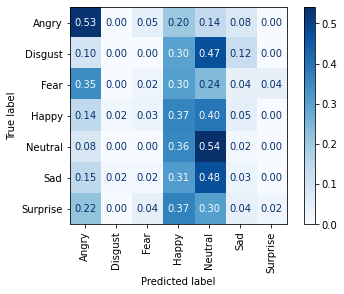

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
# X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

# xtrain = tf.expand_dims(X_tr_arr, axis=-1)
# xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=16
lr=0.0001

lr_rates=[0.0001,0.00005,0.00001]
batch_szs=[8,16,32,64]
norm=[0,1]

for lr in lr_rates:
  for batch_size in batch_szs:
    for normalized in norm:
      print("-------------------------------------")
      print("learnig rate: ",lr)
      print("batch size: ",batch_size)
      print("normalized audio?: ",normalized==1)
      if normalized==1:
        X_tr_arr=asarray(new_data_train)
        X_te_arr=asarray(new_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="normalized"
      else:
        X_tr_arr=asarray(x_data_train)
        X_te_arr=asarray(x_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="not normalized"

      audio_model2_fayek = Classifier()
      optimizer = tf.keras.optimizers.RMSprop(lr=lr)
      audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

      E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=20,verbose=1,mode="auto",restore_best_weights=True)
      callbacks_list=[E_stopping]

      history=audio_model2_fayek.fit(xtrain, y_train_arr,
                        epochs=epochs,
                        validation_data=(xtest, y_te_arr),
                        batch_size=batch_size,
                      #  class_weight=class_weight_dict,
                        callbacks=callbacks_list)
      path=""
      title="Audio model 2(Fayek) trained with log-mel-specs"+"lr= "+str(lr)+" batch_sz="+str(batch_size)+" "+norm_str
      plot_model(history,title)
      plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
      plt.figure()

-------------------------------------
learnig rate:  0.0001
batch size:  8
normalized audio?:  False


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
97/97 [==============================] - 5s 29ms/step - loss: 2.1539 - categorical_accuracy: 0.1552 - accuracy: 0.1552 - val_loss: 2.1352 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
97/97 [==============================] - 2s 26ms/step - loss: 2.0915 - categorical_accuracy: 0.2135 - accuracy: 0.2135 - val_loss: 2.1119 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
97/97 [==============================] - 2s 25ms/step - loss: 2.0665 - categorical_accuracy: 0.2329 - accuracy: 0.2329 - val_loss: 2.1053 - val_categorical_accuracy: 0.1444 - val_accuracy: 0.1444
Epoch 4/50
97/97 [==============================] - 2s 26ms/step - loss: 2.0485 - categorical_accuracy: 0.2471 - accuracy: 0.2471 - val_loss: 2.1484 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 5/50
97/97 [==============================] - 3s 26ms/step - loss: 2.0125 - categorical_accuracy: 0.2510 - accuracy: 0.2510 - val_loss: 2.1524 - val_categorical_accur

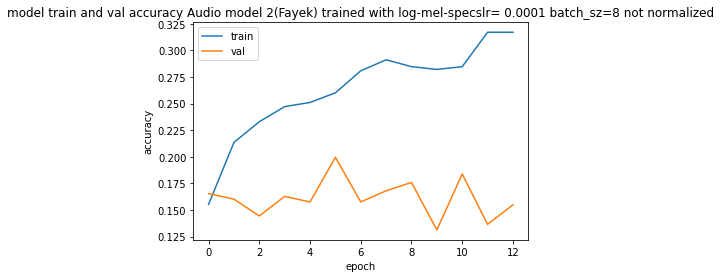

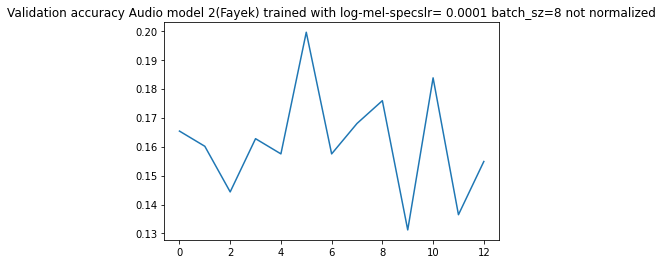

[[14  0  0  4 46  0  0]
 [12  0  0  5 23  0  0]
 [ 5  0  0  6 34  1  0]
 [17  0  0  7 39  0  0]
 [17  0  0 10 34  0  0]
 [14  0  0  6 41  0  0]
 [11  0  0  9 26  0  0]]

accuracy:  0.14435695538057744
f1 score: [0.18181818 0.         0.         0.12727273 0.22368421 0.
 0.        ]
f1 score weighted: 0.08739969106732472
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=8 not normalized


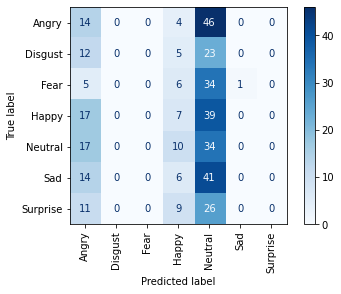

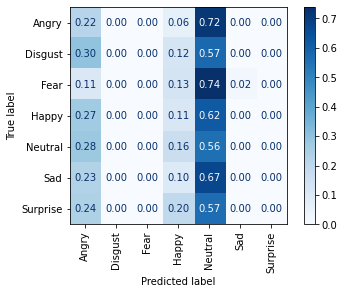

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 6s 31ms/step - loss: 2.1474 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1369 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
97/97 [==============================] - 2s 26ms/step - loss: 2.1061 - categorical_accuracy: 0.2070 - accuracy: 0.2070 - val_loss: 2.1202 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
97/97 [==============================] - 3s 27ms/step - loss: 2.0681 - categorical_accuracy: 0.2354 - accuracy: 0.2354 - val_loss: 2.1025 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 4/50
97/97 [==============================] - 2s 26ms/step - loss: 2.0571 - categorical_accuracy: 0.2367 - accuracy: 0.2367 - val_loss: 2.0899 - val_categorical_accuracy: 0.1916 - val_accuracy: 0.1916
Epoch 5/50
97/97 [==============================] - 3s 26ms/step - loss

<Figure size 432x288 with 0 Axes>

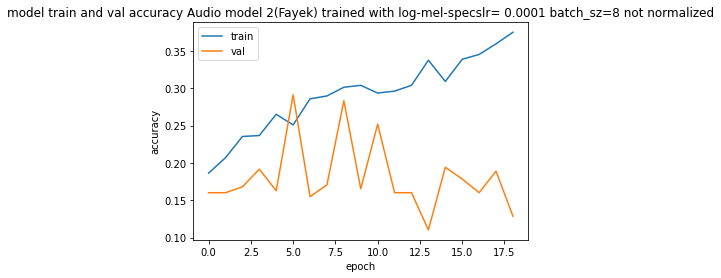

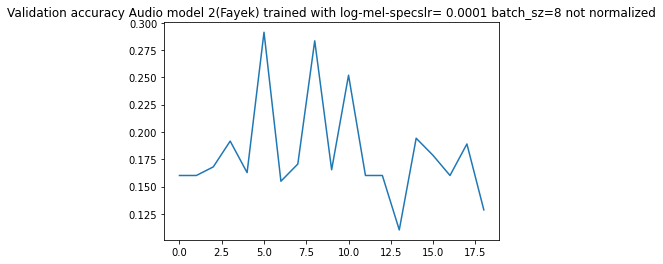

[[50  0  0  8  4  2  0]
 [12  0  0 14 11  3  0]
 [28  1  0 12  3  2  0]
 [13  1  0 29 13  7  0]
 [ 9  1  0 24 22  5  0]
 [16  0  0 20 18  7  0]
 [15  0  0 22  7  2  0]]

accuracy:  0.28346456692913385
f1 score: [0.48309179 0.         0.         0.30208333 0.31654676 0.15730337
 0.        ]
f1 score weighted: 0.2069658334175811
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=8 not normalized


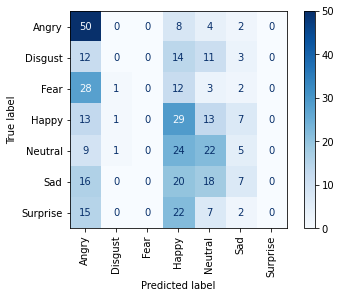

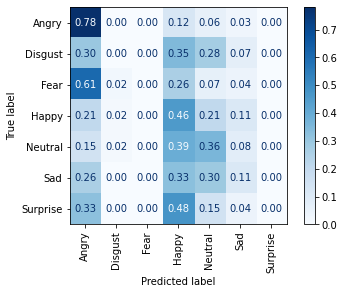

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 4s 39ms/step - loss: 2.1634 - categorical_accuracy: 0.1643 - accuracy: 0.1643 - val_loss: 2.1491 - val_categorical_accuracy: 0.1391 - val_accuracy: 0.1391
Epoch 2/50
49/49 [==============================] - 2s 31ms/step - loss: 2.1366 - categorical_accuracy: 0.1682 - accuracy: 0.1682 - val_loss: 2.1282 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 3/50
49/49 [==============================] - 2s 32ms/step - loss: 2.0910 - categorical_accuracy: 0.2316 - accuracy: 0.2316 - val_loss: 2.1139 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 4/50
49/49 [==============================] - 2s 31ms/step - loss: 2.0585 - categorical_accuracy: 0.2743 - accuracy: 0.2743 - val_loss: 2.1021 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 5/50
49/49 [==============================] - 2s 31ms/step - lo

<Figure size 432x288 with 0 Axes>

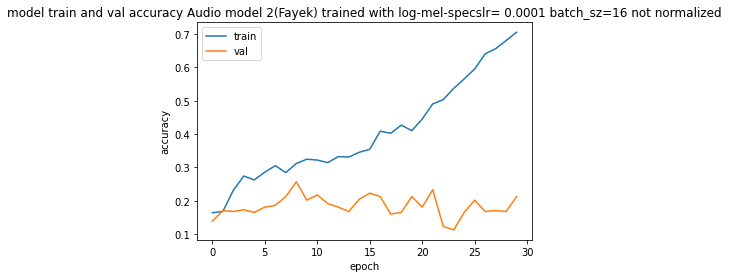

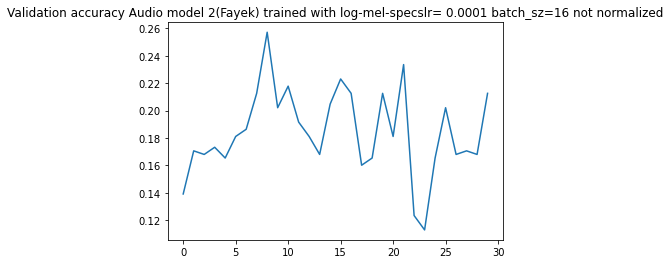

[[15  0  2 47  0  0  0]
 [ 3  1  1 33  0  2  0]
 [ 4  0  2 40  0  0  0]
 [ 2  1  0 59  0  1  0]
 [ 1  1  0 58  0  1  0]
 [ 2  1  0 54  0  4  0]
 [ 2  0  0 42  0  2  0]]

accuracy:  0.2125984251968504
f1 score: [0.32258065 0.04545455 0.07843137 0.2979798  0.         0.11267606
 0.        ]
f1 score weighted: 0.13574055893728687
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=16 not normalized


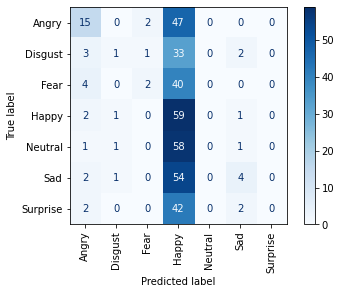

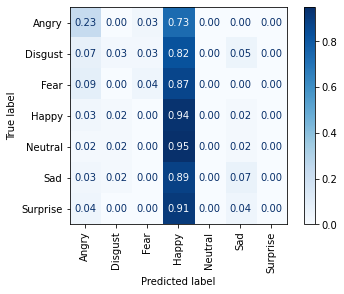

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 4s 40ms/step - loss: 2.1792 - categorical_accuracy: 0.1669 - accuracy: 0.1669 - val_loss: 2.1703 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
49/49 [==============================] - 2s 32ms/step - loss: 2.1572 - categorical_accuracy: 0.1824 - accuracy: 0.1824 - val_loss: 2.1623 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
49/49 [==============================] - 2s 37ms/step - loss: 2.1244 - categorical_accuracy: 0.2329 - accuracy: 0.2329 - val_loss: 2.1664 - val_categorical_accuracy: 0.1365 - val_accuracy: 0.1365
Epoch 4/50
49/49 [==============================] - 2s 32ms/step - loss: 2.1246 - categorical_accuracy: 0.2342 - accuracy: 0.2342 - val_loss: 2.1539 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 5/50
49/49 [==============================] - 2s 33ms/step - los

<Figure size 432x288 with 0 Axes>

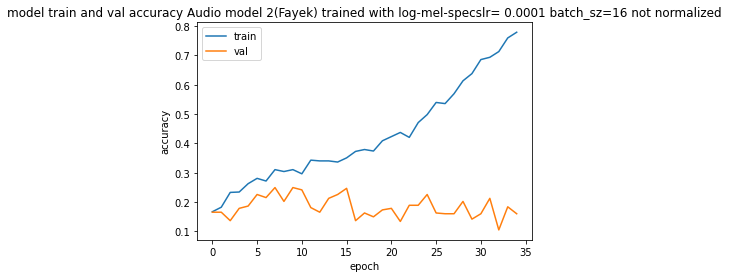

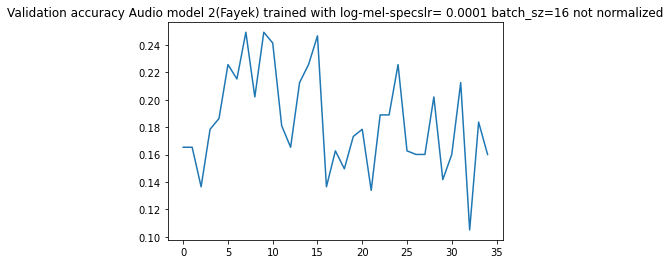

[[36  1  1 22  2  1  1]
 [ 9  0  0 25  0  6  0]
 [21  0  0 25  0  0  0]
 [22  0  0 38  0  3  0]
 [18  0  0 33  1  9  0]
 [12  0  1 37  0 11  0]
 [10  0  0 31  0  5  0]]

accuracy:  0.22572178477690288
f1 score: [0.375      0.         0.         0.27737226 0.03125    0.22916667
 0.        ]
f1 score weighted: 0.15055083785147294
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=16 not normalized


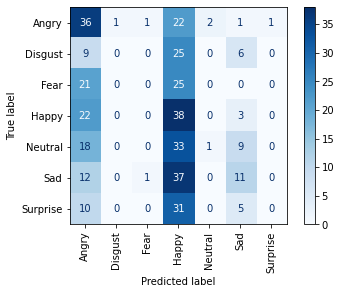

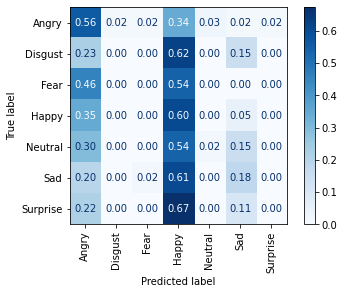

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 61ms/step - loss: 2.1873 - categorical_accuracy: 0.1475 - accuracy: 0.1475 - val_loss: 2.1530 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1339 - categorical_accuracy: 0.2057 - accuracy: 0.2057 - val_loss: 2.1352 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1050 - categorical_accuracy: 0.2264 - accuracy: 0.2264 - val_loss: 2.1228 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.0661 - categorical_accuracy: 0.2587 - accuracy: 0.2587 - val_loss: 2.1090 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - lo

<Figure size 432x288 with 0 Axes>

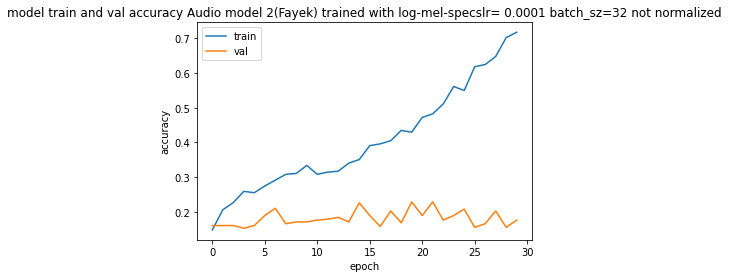

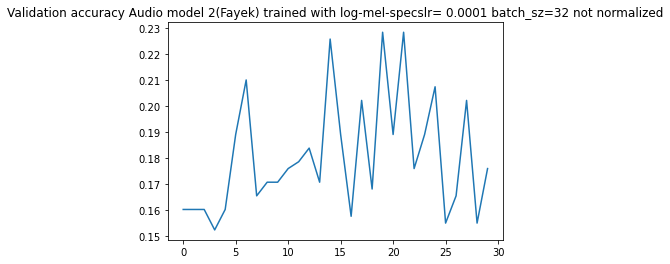

[[17  0  0 25 20  2  0]
 [ 0  0  0  7 29  4  0]
 [ 5  0  0 25 15  1  0]
 [ 1  0  0 28 31  3  0]
 [ 0  0  0 20 39  2  0]
 [ 1  0  0 16 41  3  0]
 [ 2  0  0 22 21  1  0]]

accuracy:  0.2283464566929134
f1 score: [0.37777778 0.         0.         0.27184466 0.30350195 0.07792208
 0.        ]
f1 score weighted: 0.1694773144364838
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=32 not normalized


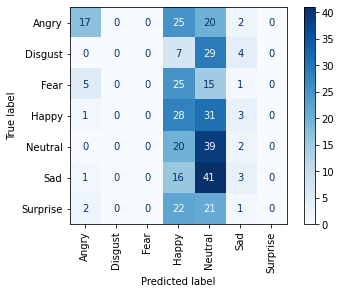

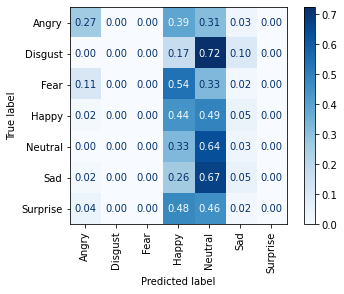

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 59ms/step - loss: 2.1776 - categorical_accuracy: 0.1604 - accuracy: 0.1604 - val_loss: 2.1546 - val_categorical_accuracy: 0.1496 - val_accuracy: 0.1496
Epoch 2/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1328 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1437 - val_categorical_accuracy: 0.1417 - val_accuracy: 0.1417
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1263 - categorical_accuracy: 0.2044 - accuracy: 0.2044 - val_loss: 2.1320 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.0965 - categorical_accuracy: 0.2212 - accuracy: 0.2212 - val_loss: 2.1192 - val_categorical_accuracy: 0.1942 - val_accuracy: 0.1942
Epoch 5/50
25/25 [==============================] - 1s 43ms/step - los

<Figure size 432x288 with 0 Axes>

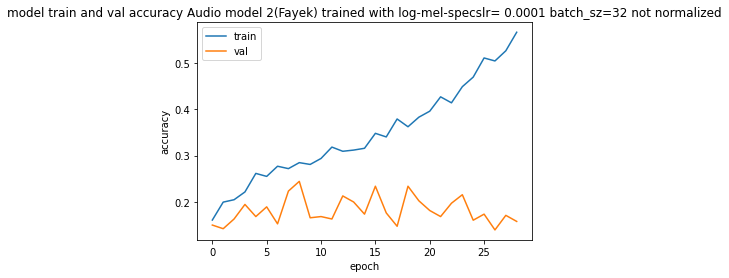

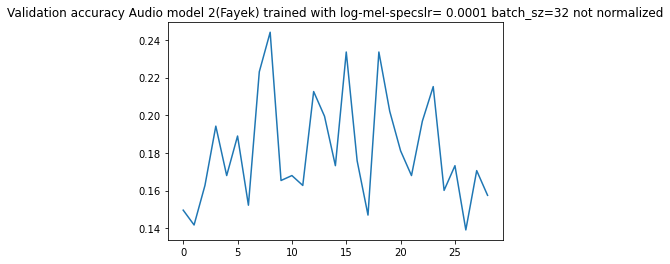

[[35  0  0 25  2  2  0]
 [ 4  0  0 30  4  2  0]
 [10  0  0 35  1  0  0]
 [ 8  0  0 50  4  1  0]
 [10  0  0 47  4  0  0]
 [10  0  0 46  5  0  0]
 [ 8  0  0 37  1  0  0]]

accuracy:  0.2335958005249344
f1 score: [0.46979866 0.         0.         0.3003003  0.09756098 0.
 0.        ]
f1 score weighted: 0.14419226384533798
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=32 not normalized


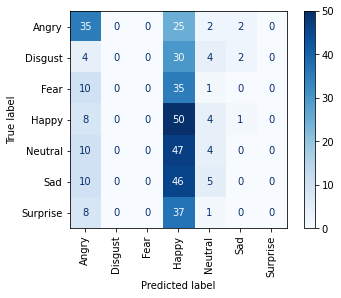

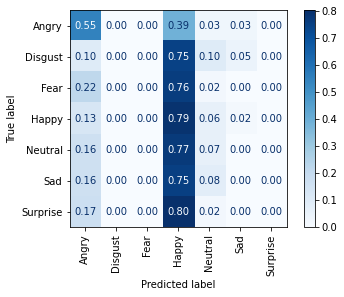

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 4s 99ms/step - loss: 2.1765 - categorical_accuracy: 0.1565 - accuracy: 0.1565 - val_loss: 2.1693 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1617 - categorical_accuracy: 0.1876 - accuracy: 0.1876 - val_loss: 2.1614 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1359 - categorical_accuracy: 0.2290 - accuracy: 0.2290 - val_loss: 2.1565 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 4/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1316 - categorical_accuracy: 0.2290 - accuracy: 0.2290 - val_loss: 2.1524 - val_categorical_accuracy: 0.1942 - val_accuracy: 0.1942
Epoch 5/50
13/13 [==============================] - 1s 60ms/step - lo

<Figure size 432x288 with 0 Axes>

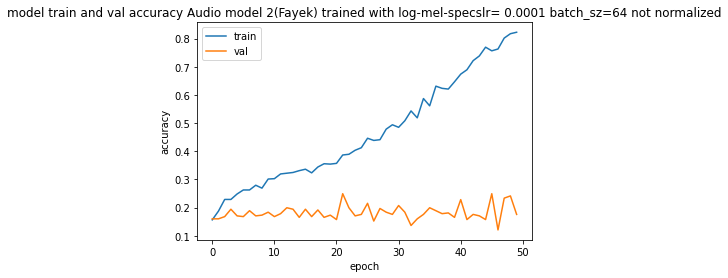

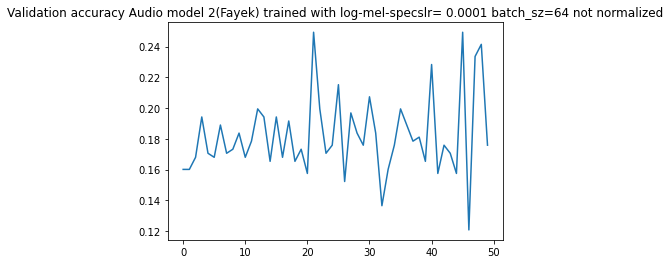

[[ 0  0  0 25 36  3  0]
 [ 0  0  0 13 26  1  0]
 [ 0  0  0 24 19  3  0]
 [ 0  0  1 23 36  3  0]
 [ 0  0  0 18 42  1  0]
 [ 0  0  0 14 45  2  0]
 [ 0  0  0 12 32  2  0]]

accuracy:  0.17585301837270342
f1 score: [0.         0.         0.         0.23958333 0.28282828 0.05263158
 0.        ]
f1 score weighted: 0.09332493849951372
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=64 not normalized


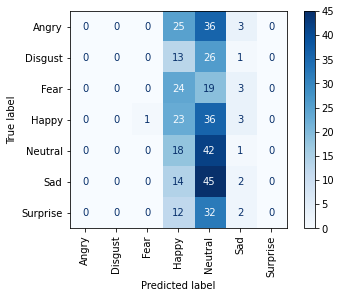

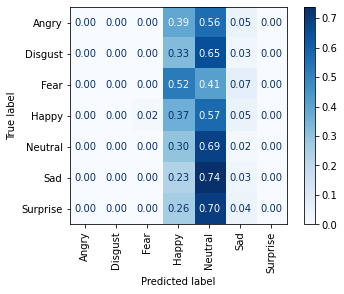

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  0.0001
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 3s 91ms/step - loss: 2.1844 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1680 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 2/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1602 - categorical_accuracy: 0.1850 - accuracy: 0.1850 - val_loss: 2.1638 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
13/13 [==============================] - 1s 63ms/step - loss: 2.1387 - categorical_accuracy: 0.2238 - accuracy: 0.2238 - val_loss: 2.1623 - val_categorical_accuracy: 0.1286 - val_accuracy: 0.1286
Epoch 4/50
13/13 [==============================] - 1s 58ms/step - loss: 2.1371 - categorical_accuracy: 0.1928 - accuracy: 0.1928 - val_loss: 2.1492 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 5/50
13/13 [==============================] - 1s 62ms/step - los

<Figure size 432x288 with 0 Axes>

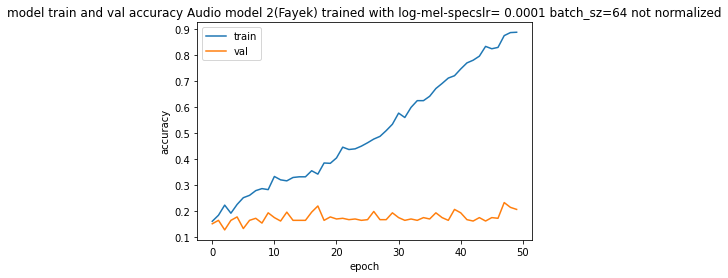

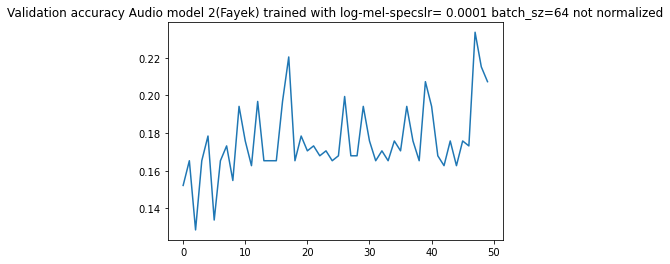

[[12  2  2 35  6  7  0]
 [ 2  4  0 20  6  8  0]
 [ 4  1  8 31  1  1  0]
 [ 4  4  0 41  4 10  0]
 [ 5  1  0 33  5 17  0]
 [ 3  1  1 34 13  9  0]
 [ 3  3  0 22  9  9  0]]

accuracy:  0.2073490813648294
f1 score: [0.24742268 0.14285714 0.28070175 0.29390681 0.0952381  0.14754098
 0.        ]
f1 score weighted: 0.1779193459428182
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 0.0001 batch_sz=64 not normalized


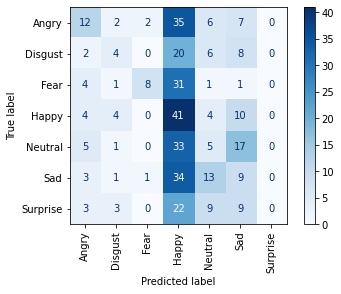

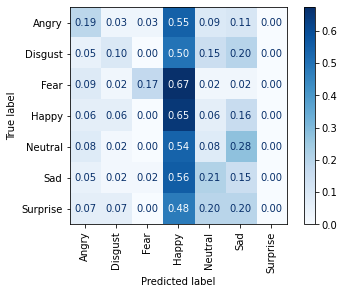

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  8
normalized audio?:  False
Epoch 1/50
97/97 [==============================] - 6s 34ms/step - loss: 2.1735 - categorical_accuracy: 0.1436 - accuracy: 0.1436 - val_loss: 2.1494 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1356 - categorical_accuracy: 0.1772 - accuracy: 0.1772 - val_loss: 2.1281 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 3/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1039 - categorical_accuracy: 0.2096 - accuracy: 0.2096 - val_loss: 2.1119 - val_categorical_accuracy: 0.1890 - val_accuracy: 0.1890
Epoch 4/50
97/97 [==============================] - 3s 29ms/step - loss: 2.0847 - categorical_accuracy: 0.2225 - accuracy: 0.2225 - val_loss: 2.0974 - val_categorical_accuracy: 0.2336 - val_accuracy: 0.2336
Epoch 5/50
97/97 [==============================] - 3s 29ms/step - loss

<Figure size 432x288 with 0 Axes>

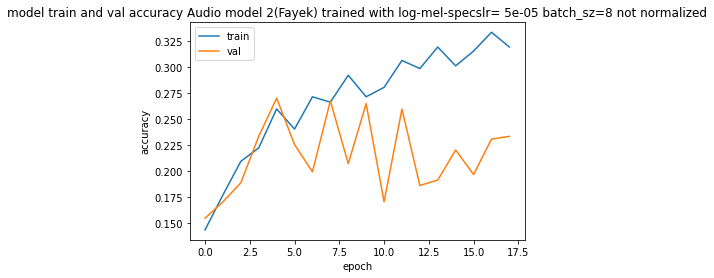

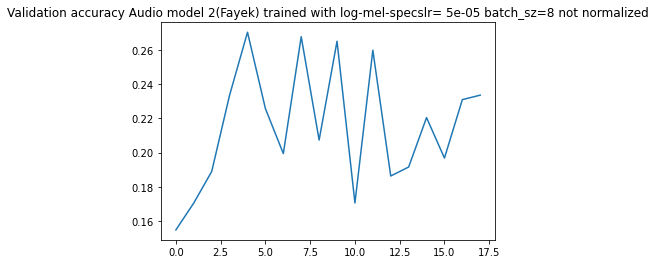

[[42  0  0 14  8  0  0]
 [ 3  2  0 13 22  0  0]
 [19  0  0 17  9  1  0]
 [12  3  0 24 22  2  0]
 [ 6  0  1 23 31  0  0]
 [13  1  0 16 28  3  0]
 [11  0  0 22 12  1  0]]

accuracy:  0.2677165354330709
f1 score: [0.49411765 0.08695652 0.         0.25       0.32124352 0.08823529
 0.        ]
f1 score weighted: 0.19902886652174856
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=8 not normalized


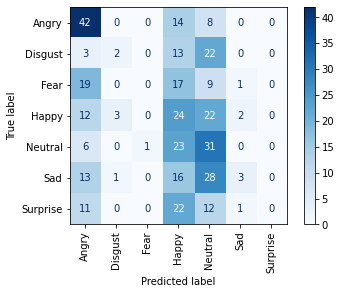

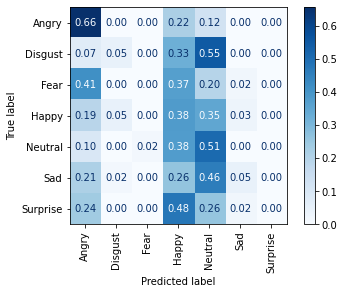

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 6s 35ms/step - loss: 2.1753 - categorical_accuracy: 0.1371 - accuracy: 0.1371 - val_loss: 2.1557 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1451 - categorical_accuracy: 0.1863 - accuracy: 0.1863 - val_loss: 2.1418 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 3/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1262 - categorical_accuracy: 0.2031 - accuracy: 0.2031 - val_loss: 2.1266 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 4/50
97/97 [==============================] - 3s 30ms/step - loss: 2.0872 - categorical_accuracy: 0.2393 - accuracy: 0.2393 - val_loss: 2.1120 - val_categorical_accuracy: 0.2362 - val_accuracy: 0.2362
Epoch 5/50
97/97 [==============================] - 3s 30ms/step - loss:

<Figure size 432x288 with 0 Axes>

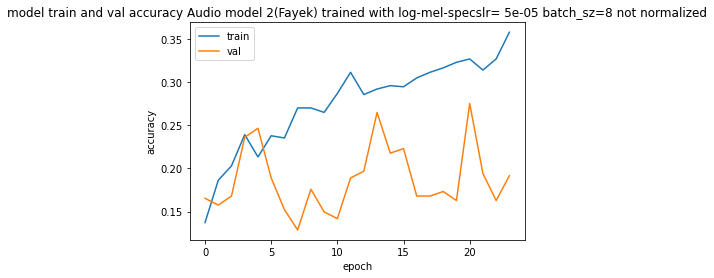

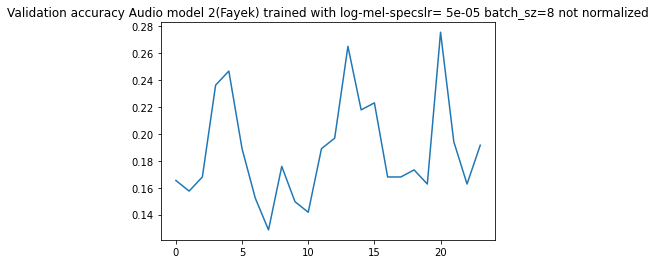

[[36  1  3 16  7  1  0]
 [ 4  1  0 13 18  4  0]
 [17  0  1 22  4  2  0]
 [ 9  1  2 31 16  4  0]
 [ 4  2  2 22 25  6  0]
 [11  0  1 23 19  7  0]
 [ 9  0  1 24 10  2  0]]

accuracy:  0.2650918635170604
f1 score: [0.46753247 0.04444444 0.03571429 0.28971963 0.3125     0.16091954
 0.        ]
f1 score weighted: 0.2112169061557322
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=8 not normalized


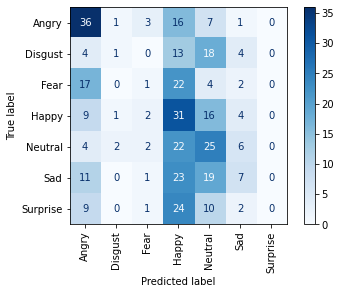

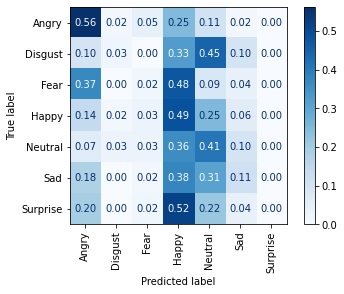

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 4s 44ms/step - loss: 2.1910 - categorical_accuracy: 0.1345 - accuracy: 0.1345 - val_loss: 2.1755 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1657 - categorical_accuracy: 0.1953 - accuracy: 0.1953 - val_loss: 2.1737 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 3/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1661 - categorical_accuracy: 0.1928 - accuracy: 0.1928 - val_loss: 2.1703 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 4/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1423 - categorical_accuracy: 0.1966 - accuracy: 0.1966 - val_loss: 2.1679 - val_categorical_accuracy: 0.1837 - val_accuracy: 0.1837
Epoch 5/50
49/49 [==============================] - 2s 34ms/step - los

<Figure size 432x288 with 0 Axes>

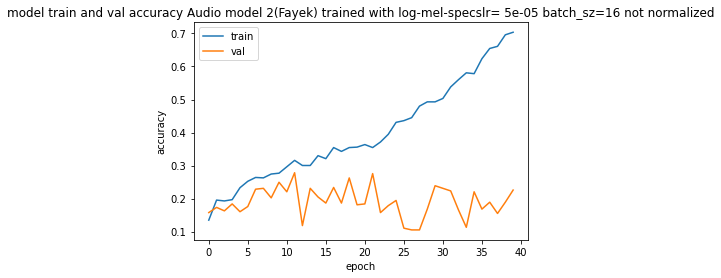

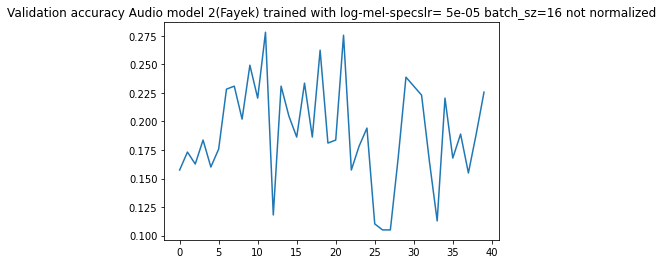

[[24  0  0 17  6 17  0]
 [ 2  1  0  7 21  9  0]
 [17  0  0 17 10  2  0]
 [ 9  0  0 21 22 11  0]
 [ 4  0  0 15 33  9  0]
 [ 8  0  0 10 31 12  0]
 [ 8  0  0 11 20  7  0]]

accuracy:  0.2388451443569554
f1 score: [0.35294118 0.04878049 0.         0.26086957 0.32352941 0.1875
 0.        ]
f1 score weighted: 0.18936228748728476
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=16 not normalized


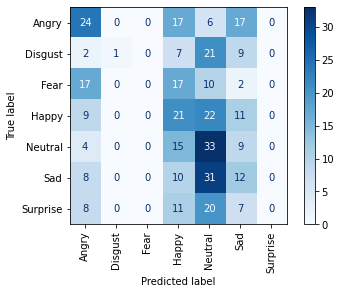

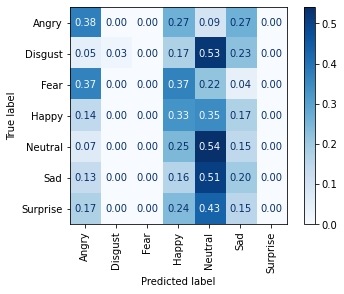

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 4s 43ms/step - loss: 2.1845 - categorical_accuracy: 0.1410 - accuracy: 0.1410 - val_loss: 2.1682 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 2/50
49/49 [==============================] - 2s 33ms/step - loss: 2.1588 - categorical_accuracy: 0.1734 - accuracy: 0.1734 - val_loss: 2.1606 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
49/49 [==============================] - 2s 36ms/step - loss: 2.1316 - categorical_accuracy: 0.2122 - accuracy: 0.2122 - val_loss: 2.1575 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 4/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1266 - categorical_accuracy: 0.2160 - accuracy: 0.2160 - val_loss: 2.1483 - val_categorical_accuracy: 0.1837 - val_accuracy: 0.1837
Epoch 5/50
49/49 [==============================] - 2s 35ms/step - loss

<Figure size 432x288 with 0 Axes>

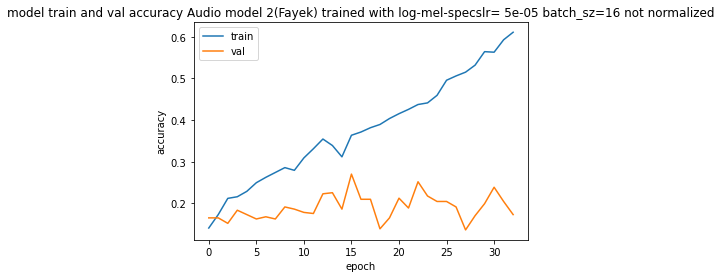

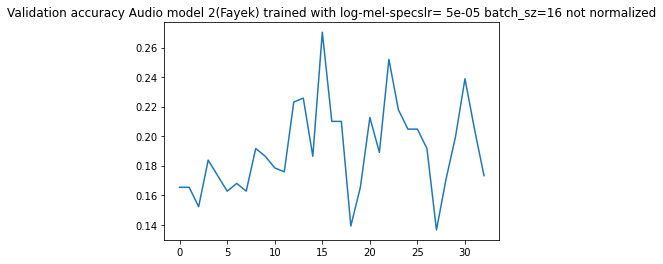

[[40  0  2 17  3  2  0]
 [ 6  1  0 21  9  3  0]
 [15  0  0 28  3  0  0]
 [ 9  0  2 37 12  3  0]
 [ 4  0  0 38 15  4  0]
 [10  0  0 34 14  3  0]
 [ 6  0  1 28  9  2  0]]

accuracy:  0.25196850393700787
f1 score: [0.51948052 0.04878049 0.         0.27819549 0.23809524 0.07692308
 0.        ]
f1 score weighted: 0.18881996263658604
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=16 not normalized


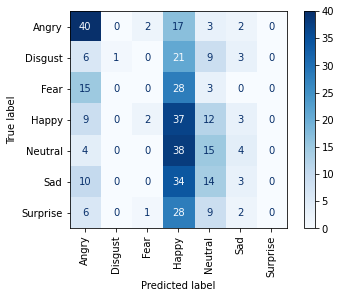

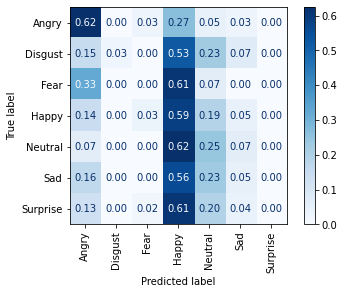

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 55ms/step - loss: 2.1849 - categorical_accuracy: 0.1475 - accuracy: 0.1475 - val_loss: 2.1654 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1556 - categorical_accuracy: 0.1695 - accuracy: 0.1695 - val_loss: 2.1583 - val_categorical_accuracy: 0.1496 - val_accuracy: 0.1496
Epoch 3/50
25/25 [==============================] - 1s 39ms/step - loss: 2.1332 - categorical_accuracy: 0.2199 - accuracy: 0.2199 - val_loss: 2.1518 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1119 - categorical_accuracy: 0.2199 - accuracy: 0.2199 - val_loss: 2.1453 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 5/50
25/25 [==============================] - 1s 40ms/step - los

<Figure size 432x288 with 0 Axes>

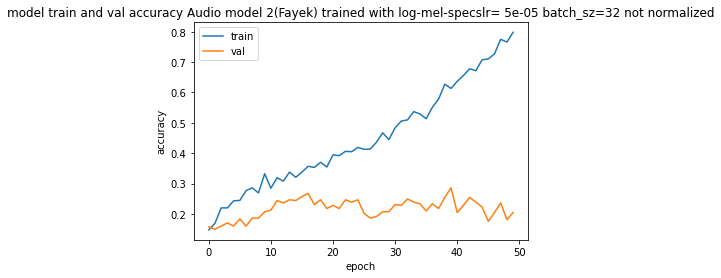

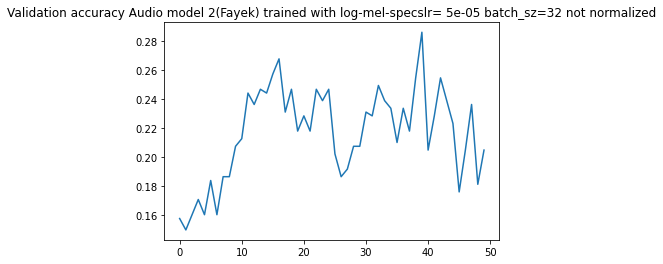

[[28  0  2 18  6  9  1]
 [ 2  1  0 12 17  8  0]
 [12  0  3 17  9  5  0]
 [ 8  1  4 21 22  7  0]
 [ 1  1  1 13 36  9  0]
 [ 6  0  0  9 26 20  0]
 [ 4  0  2 10 22  8  0]]

accuracy:  0.28608923884514437
f1 score: [0.448      0.04651163 0.10344828 0.25766871 0.36180905 0.31496063
 0.        ]
f1 score weighted: 0.24358835911884744
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=32 not normalized


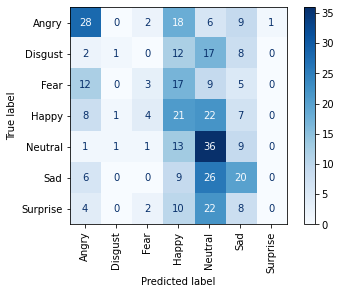

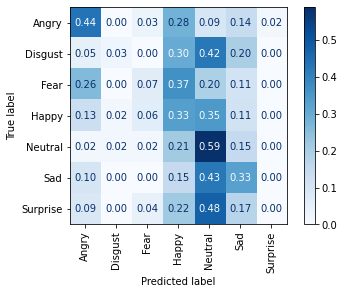

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 61ms/step - loss: 2.1836 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1641 - val_categorical_accuracy: 0.1339 - val_accuracy: 0.1339
Epoch 2/50
25/25 [==============================] - 1s 44ms/step - loss: 2.1749 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 2.1532 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 3/50
25/25 [==============================] - 1s 41ms/step - loss: 2.1291 - categorical_accuracy: 0.2057 - accuracy: 0.2057 - val_loss: 2.1446 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 4/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1272 - categorical_accuracy: 0.1811 - accuracy: 0.1811 - val_loss: 2.1358 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 5/50
25/25 [==============================] - 1s 43ms/step - loss

<Figure size 432x288 with 0 Axes>

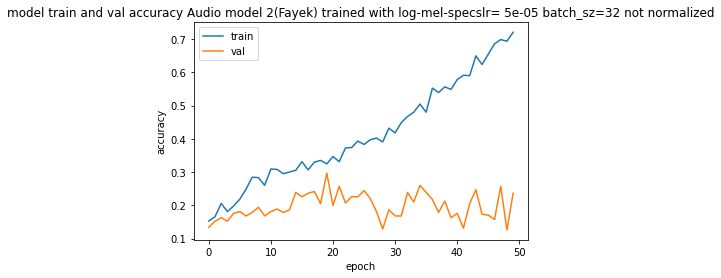

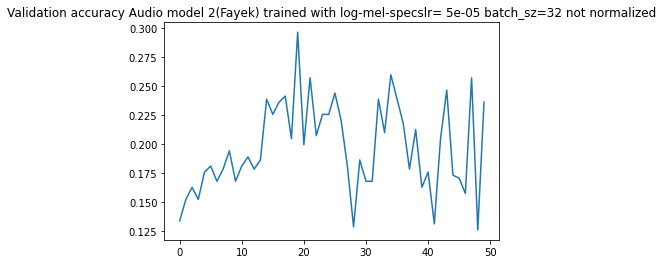

[[17  0  0 36  7  4  0]
 [ 3  0  0 15 16  6  0]
 [10  0  1 28  5  2  0]
 [ 4  0  0 40 14  5  0]
 [ 1  0  0 37 20  3  0]
 [ 5  0  0 24 20 12  0]
 [ 4  0  0 27 13  2  0]]

accuracy:  0.23622047244094488
f1 score: [0.31481481 0.         0.04255319 0.2962963  0.25641026 0.25263158
 0.        ]
f1 score weighted: 0.18851394640456837
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=32 not normalized


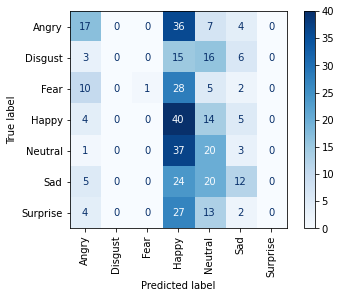

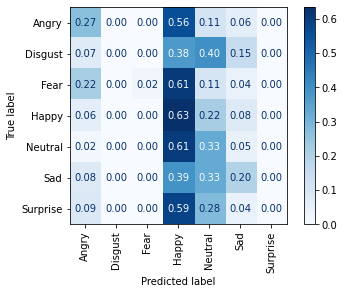

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 4s 99ms/step - loss: 2.1775 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1767 - val_categorical_accuracy: 0.1050 - val_accuracy: 0.1050
Epoch 2/50
13/13 [==============================] - 1s 63ms/step - loss: 2.1771 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1725 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
13/13 [==============================] - 1s 62ms/step - loss: 2.1640 - categorical_accuracy: 0.1940 - accuracy: 0.1940 - val_loss: 2.1702 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 4/50
13/13 [==============================] - 1s 60ms/step - loss: 2.1479 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1683 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 5/50
13/13 [==============================] - 1s 63ms/step - los

<Figure size 432x288 with 0 Axes>

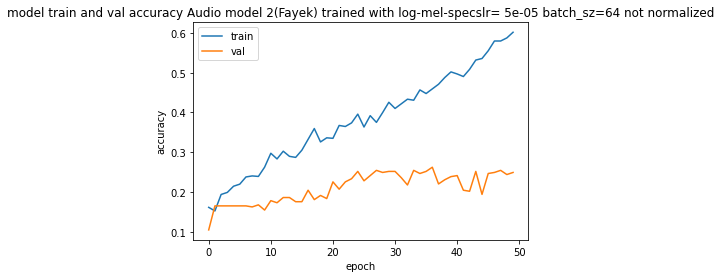

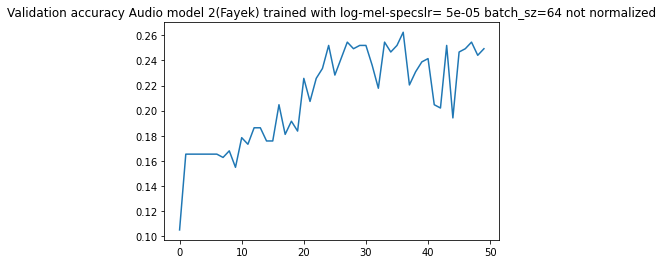

[[24  0  0 21 19  0  0]
 [ 1  0  0  9 29  1  0]
 [ 9  0  0 22 15  0  0]
 [ 3  0  0 22 36  2  0]
 [ 1  0  0 15 44  1  0]
 [ 3  0  0  9 44  5  0]
 [ 3  0  0 12 29  2  0]]

accuracy:  0.24934383202099739
f1 score: [0.44444444 0.         0.         0.25433526 0.31768953 0.13888889
 0.        ]
f1 score weighted: 0.18981325308606578
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=64 not normalized


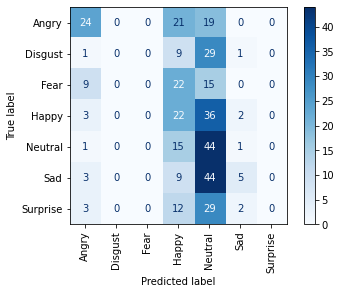

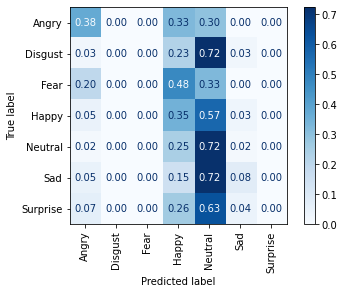

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  5e-05
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 4s 98ms/step - loss: 2.1894 - categorical_accuracy: 0.1475 - accuracy: 0.1475 - val_loss: 2.1761 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1647 - categorical_accuracy: 0.1966 - accuracy: 0.1966 - val_loss: 2.1753 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1595 - categorical_accuracy: 0.2031 - accuracy: 0.2031 - val_loss: 2.1750 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 4/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1455 - categorical_accuracy: 0.2251 - accuracy: 0.2251 - val_loss: 2.1728 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 5/50
13/13 [==============================] - 1s 60ms/step - loss

<Figure size 432x288 with 0 Axes>

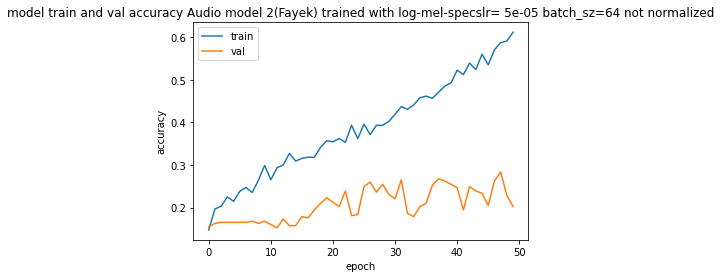

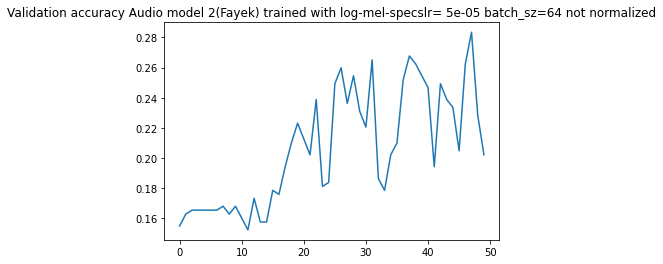

[[51  0  0 11  2  0  0]
 [25  0  0 13  1  1  0]
 [31  0  0 15  0  0  0]
 [36  0  0 25  2  0  0]
 [29  0  0 30  1  1  0]
 [38  0  0 21  2  0  0]
 [25  0  0 19  2  0  0]]

accuracy:  0.2020997375328084
f1 score: [0.34113712 0.         0.         0.25380711 0.02816901 0.
 0.        ]
f1 score weighted: 0.10378197767617693
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 5e-05 batch_sz=64 not normalized


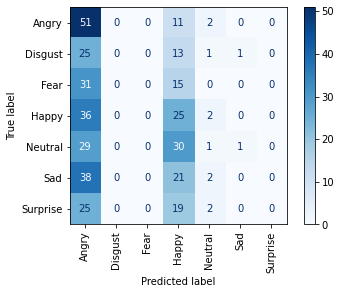

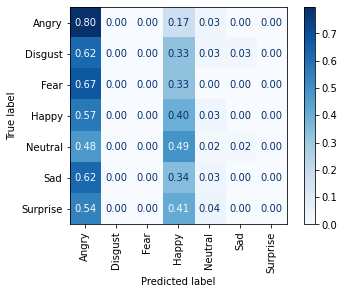

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  8
normalized audio?:  False
Epoch 1/50
97/97 [==============================] - 6s 35ms/step - loss: 2.1834 - categorical_accuracy: 0.1423 - accuracy: 0.1423 - val_loss: 2.1717 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1724 - categorical_accuracy: 0.1695 - accuracy: 0.1695 - val_loss: 2.1661 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 3/50
97/97 [==============================] - 3s 31ms/step - loss: 2.1689 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1608 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 4/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1583 - categorical_accuracy: 0.1682 - accuracy: 0.1682 - val_loss: 2.1556 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 5/50
97/97 [==============================] - 3s 28ms/step - loss

<Figure size 432x288 with 0 Axes>

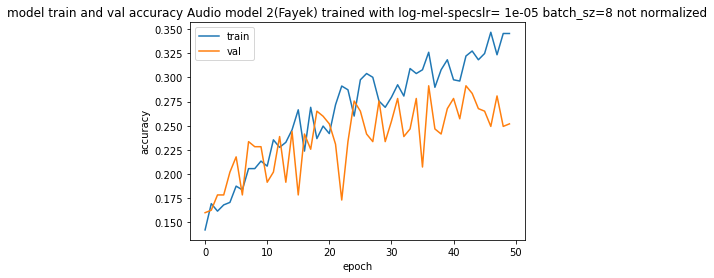

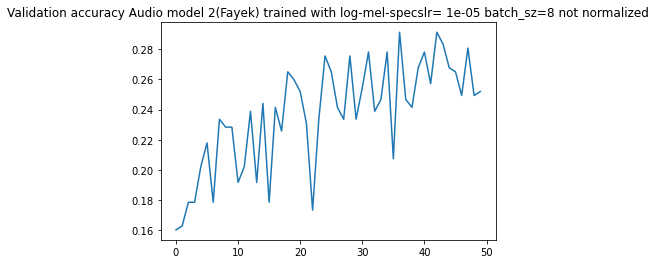

[[28  0  1 18 16  1  0]
 [ 0  0  1  8 30  1  0]
 [12  0  1 19 14  0  0]
 [ 5  1  1 26 27  3  0]
 [ 2  1  0 19 37  2  0]
 [ 7  0  0 12 38  4  0]
 [ 8  0  0 20 17  1  0]]

accuracy:  0.25196850393700787
f1 score: [0.44444444 0.         0.04       0.28108108 0.30833333 0.10958904
 0.        ]
f1 score weighted: 0.19287616113578793
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=8 not normalized


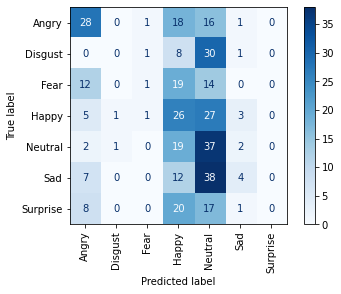

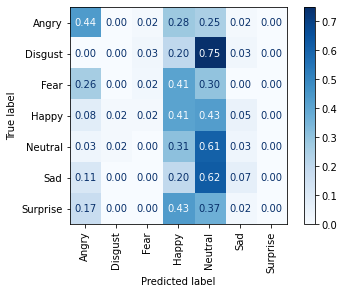

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  8
normalized audio?:  True
Epoch 1/50
97/97 [==============================] - 6s 36ms/step - loss: 2.1902 - categorical_accuracy: 0.1151 - accuracy: 0.1151 - val_loss: 2.1730 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
97/97 [==============================] - 3s 31ms/step - loss: 2.1793 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1676 - val_categorical_accuracy: 0.1522 - val_accuracy: 0.1522
Epoch 3/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1687 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 2.1618 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 4/50
97/97 [==============================] - 3s 29ms/step - loss: 2.1549 - categorical_accuracy: 0.1824 - accuracy: 0.1824 - val_loss: 2.1556 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 5/50
97/97 [==============================] - 3s 29ms/step - loss:

<Figure size 432x288 with 0 Axes>

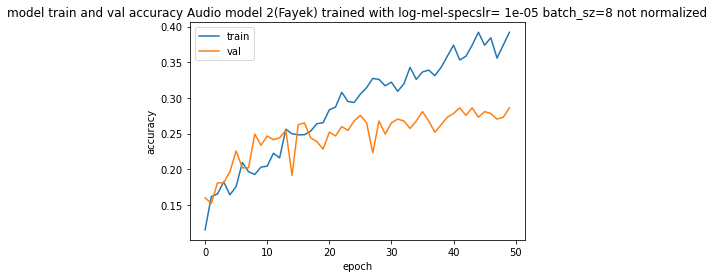

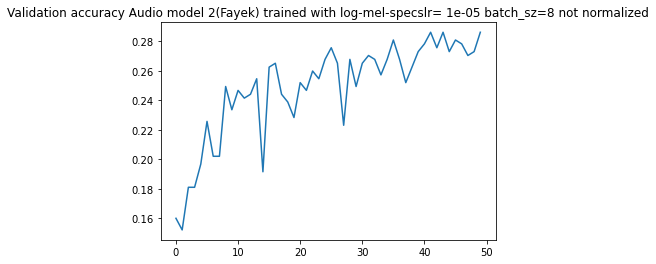

[[41  0  1 15  7  0  0]
 [ 4  1  0 13 19  3  0]
 [18  0  0 22  5  1  0]
 [10  0  0 31 17  5  0]
 [ 6  1  0 21 30  3  0]
 [13  0  0 17 25  6  0]
 [11  0  0 20 13  2  0]]

accuracy:  0.28608923884514437
f1 score: [0.49101796 0.04761905 0.         0.30693069 0.33898305 0.14814815
 0.        ]
f1 score weighted: 0.21622453650251705
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=8 not normalized


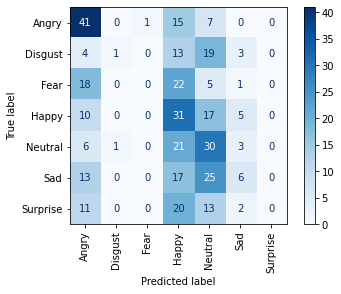

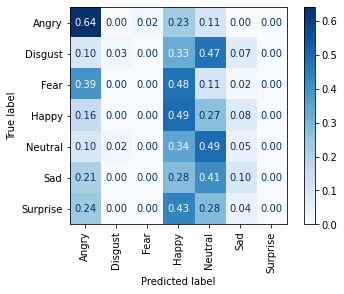

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  16
normalized audio?:  False
Epoch 1/50
49/49 [==============================] - 5s 42ms/step - loss: 2.1934 - categorical_accuracy: 0.1552 - accuracy: 0.1552 - val_loss: 2.1742 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1762 - categorical_accuracy: 0.1578 - accuracy: 0.1578 - val_loss: 2.1711 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 3/50
49/49 [==============================] - 2s 35ms/step - loss: 2.1711 - categorical_accuracy: 0.1811 - accuracy: 0.1811 - val_loss: 2.1680 - val_categorical_accuracy: 0.1759 - val_accuracy: 0.1759
Epoch 4/50
49/49 [==============================] - 2s 36ms/step - loss: 2.1708 - categorical_accuracy: 0.1695 - accuracy: 0.1695 - val_loss: 2.1650 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 5/50
49/49 [==============================] - 2s 35ms/step - los

<Figure size 432x288 with 0 Axes>

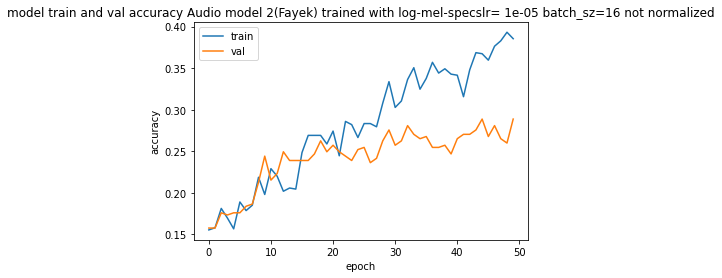

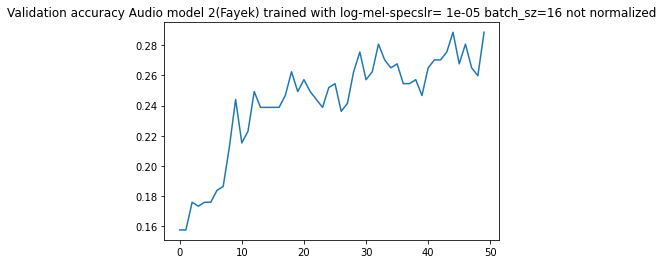

[[41  1  3 14  4  1  0]
 [ 7  3  0 12 17  1  0]
 [24  0  0 15  7  0  0]
 [ 7  0  0 33 17  6  0]
 [ 4  1  1 22 30  3  0]
 [15  0  0 17 26  3  0]
 [12  0  0 20 13  1  0]]

accuracy:  0.2887139107611549
f1 score: [0.47126437 0.13333333 0.         0.33673469 0.34285714 0.07894737
 0.        ]
f1 score weighted: 0.21637431437222795
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=16 not normalized


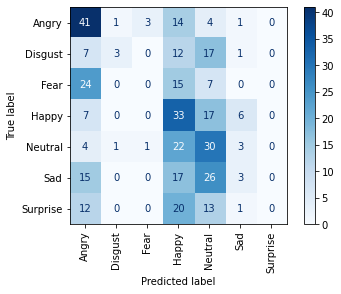

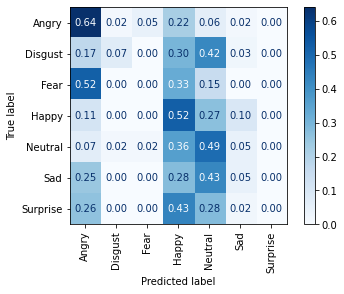

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  16
normalized audio?:  True
Epoch 1/50
49/49 [==============================] - 4s 42ms/step - loss: 2.1918 - categorical_accuracy: 0.1643 - accuracy: 0.1643 - val_loss: 2.1745 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 2/50
49/49 [==============================] - 2s 34ms/step - loss: 2.1792 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1722 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 3/50
49/49 [==============================] - 2s 38ms/step - loss: 2.1784 - categorical_accuracy: 0.1552 - accuracy: 0.1552 - val_loss: 2.1703 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 4/50
49/49 [==============================] - 2s 37ms/step - loss: 2.1624 - categorical_accuracy: 0.1734 - accuracy: 0.1734 - val_loss: 2.1673 - val_categorical_accuracy: 0.1995 - val_accuracy: 0.1995
Epoch 5/50
49/49 [==============================] - 2s 34ms/step - loss

<Figure size 432x288 with 0 Axes>

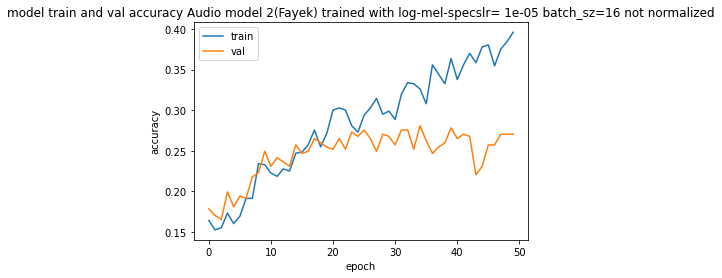

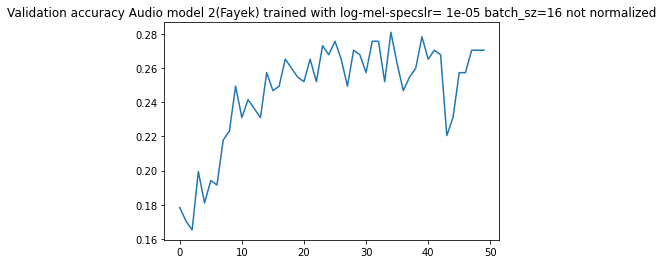

[[32  0  1 14 15  2  0]
 [ 0  0  1  8 29  2  0]
 [15  0  0 16 14  0  1]
 [ 5  1  0 26 29  2  0]
 [ 1  1  1 14 42  2  0]
 [ 6  0  0 13 39  3  0]
 [ 8  0  0 18 18  2  0]]

accuracy:  0.27034120734908135
f1 score: [0.48854962 0.         0.         0.30232558 0.34008097 0.08108108
 0.        ]
f1 score weighted: 0.19948706671293195
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=16 not normalized


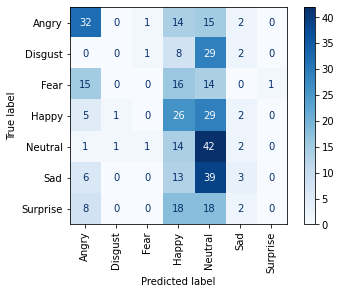

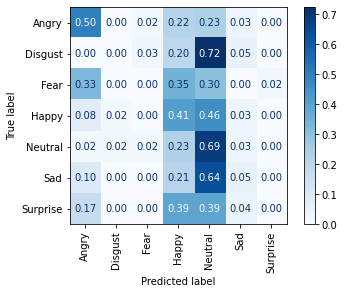

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  32
normalized audio?:  False
Epoch 1/50
25/25 [==============================] - 4s 58ms/step - loss: 2.1956 - categorical_accuracy: 0.1320 - accuracy: 0.1320 - val_loss: 2.1737 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 2/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1775 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1717 - val_categorical_accuracy: 0.1732 - val_accuracy: 0.1732
Epoch 3/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1755 - categorical_accuracy: 0.1501 - accuracy: 0.1501 - val_loss: 2.1698 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 4/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1779 - categorical_accuracy: 0.1410 - accuracy: 0.1410 - val_loss: 2.1678 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 5/50
25/25 [==============================] - 1s 42ms/step - los

<Figure size 432x288 with 0 Axes>

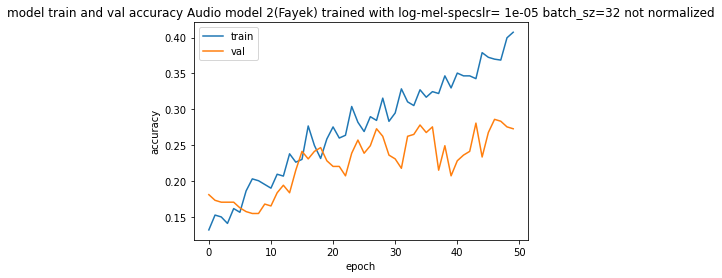

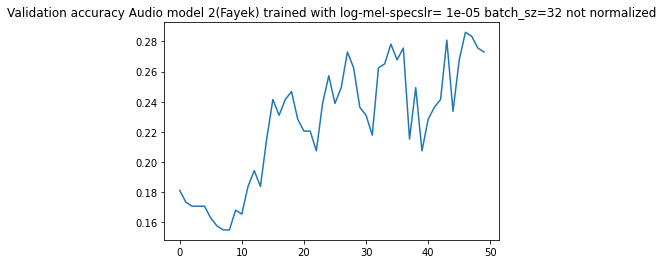

[[34  1  0 19 10  0  0]
 [ 3  3  0 10 24  0  0]
 [11  0  0 21 13  1  0]
 [ 4  3  0 29 25  2  0]
 [ 1  1  0 20 36  3  0]
 [ 6  2  0 16 36  1  0]
 [ 6  0  1 22 15  1  1]]

accuracy:  0.27296587926509186
f1 score: [0.52713178 0.12       0.         0.29       0.32727273 0.02898551
 0.04255319]
f1 score weighted: 0.21127462788111054
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=32 not normalized


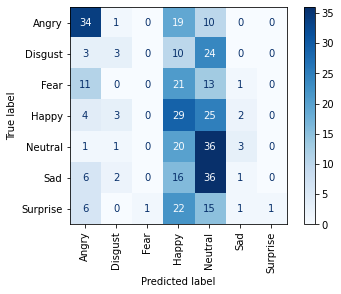

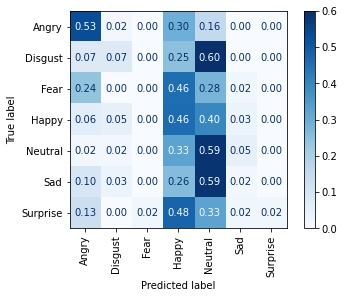

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  32
normalized audio?:  True
Epoch 1/50
25/25 [==============================] - 4s 58ms/step - loss: 2.1887 - categorical_accuracy: 0.1501 - accuracy: 0.1501 - val_loss: 2.1766 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1815 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 2.1760 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
25/25 [==============================] - 1s 43ms/step - loss: 2.1731 - categorical_accuracy: 0.1514 - accuracy: 0.1514 - val_loss: 2.1757 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 42ms/step - loss: 2.1698 - categorical_accuracy: 0.1630 - accuracy: 0.1630 - val_loss: 2.1751 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
25/25 [==============================] - 1s 42ms/step - loss

<Figure size 432x288 with 0 Axes>

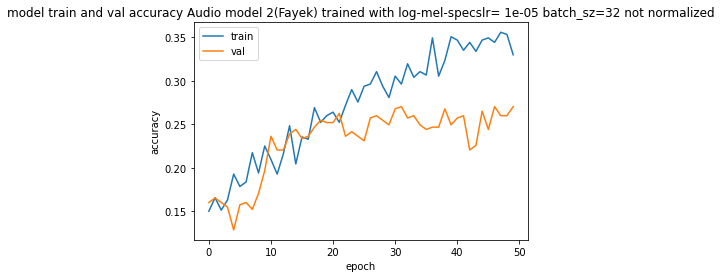

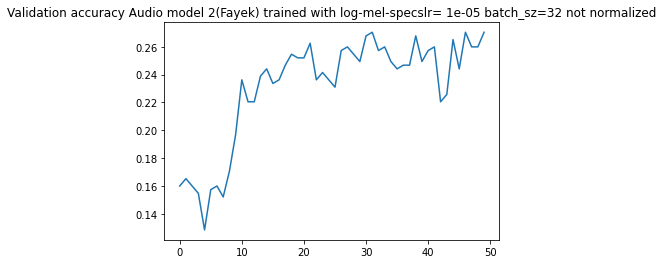

[[37  0  3 14  7  3  0]
 [ 2  0  0  8 24  6  0]
 [18  0  3 17  7  1  0]
 [ 7  1  2 27 21  5  0]
 [ 4  0  0 22 32  3  0]
 [12  0  0 14 31  4  0]
 [ 9  0  3 18 14  2  0]]

accuracy:  0.27034120734908135
f1 score: [0.48366013 0.         0.10526316 0.29508197 0.3248731  0.09411765
 0.        ]
f1 score weighted: 0.20982927274917104
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=32 not normalized


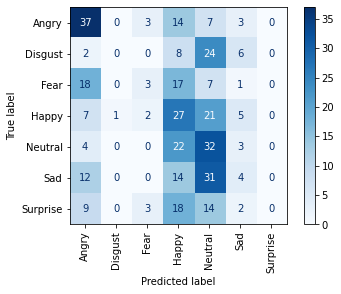

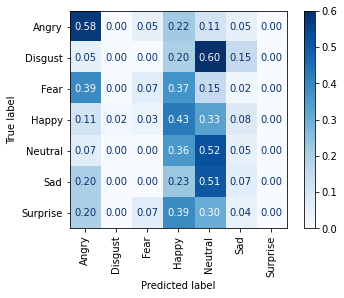

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  64
normalized audio?:  False
Epoch 1/50
13/13 [==============================] - 4s 97ms/step - loss: 2.1964 - categorical_accuracy: 0.1345 - accuracy: 0.1345 - val_loss: 2.1747 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 2/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1779 - categorical_accuracy: 0.1514 - accuracy: 0.1514 - val_loss: 2.1746 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1733 - categorical_accuracy: 0.1992 - accuracy: 0.1992 - val_loss: 2.1743 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 4/50
13/13 [==============================] - 1s 59ms/step - loss: 2.1748 - categorical_accuracy: 0.1734 - accuracy: 0.1734 - val_loss: 2.1737 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
13/13 [==============================] - 1s 62ms/step - los

<Figure size 432x288 with 0 Axes>

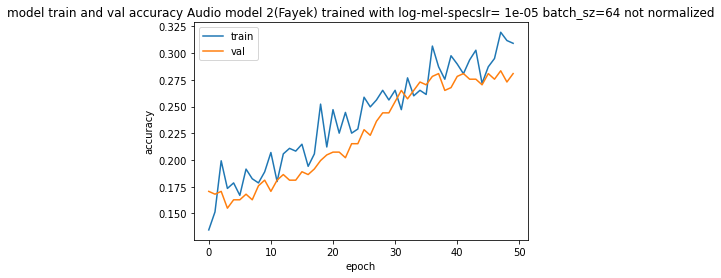

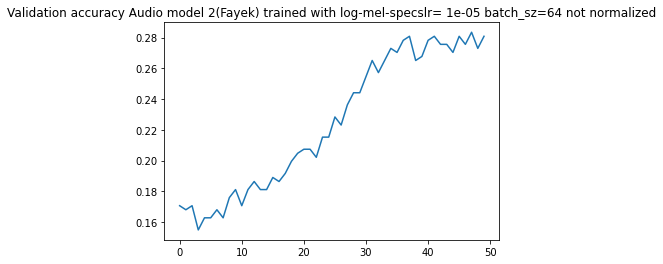

[[40  2  2 12  6  2  0]
 [ 5  1  0 10 19  5  0]
 [24  0  2 14  6  0  0]
 [10  2  0 31 17  3  0]
 [ 4  2  0 23 29  3  0]
 [12  0  0 18 27  4  0]
 [11  0  0 22 12  1  0]]

accuracy:  0.28083989501312334
f1 score: [0.47058824 0.04255319 0.08       0.32124352 0.32768362 0.10126582
 0.        ]
f1 score weighted: 0.21497121375893727
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=64 not normalized


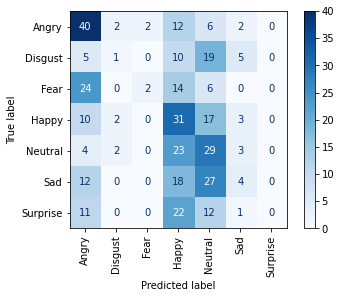

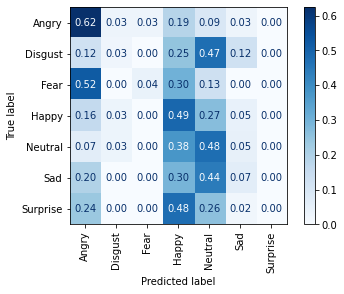

<Figure size 432x288 with 0 Axes>


-------------------------------------
learnig rate:  1e-05
batch size:  64
normalized audio?:  True
Epoch 1/50
13/13 [==============================] - 4s 97ms/step - loss: 2.1966 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1788 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1881 - categorical_accuracy: 0.1552 - accuracy: 0.1552 - val_loss: 2.1782 - val_categorical_accuracy: 0.1234 - val_accuracy: 0.1234
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1940 - categorical_accuracy: 0.1527 - accuracy: 0.1527 - val_loss: 2.1778 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 4/50
13/13 [==============================] - 1s 61ms/step - loss: 2.1966 - categorical_accuracy: 0.1488 - accuracy: 0.1488 - val_loss: 2.1774 - val_categorical_accuracy: 0.1706 - val_accuracy: 0.1706
Epoch 5/50
13/13 [==============================] - 1s 59ms/step - loss

<Figure size 432x288 with 0 Axes>

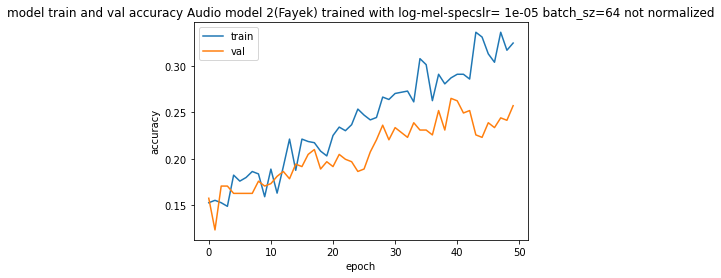

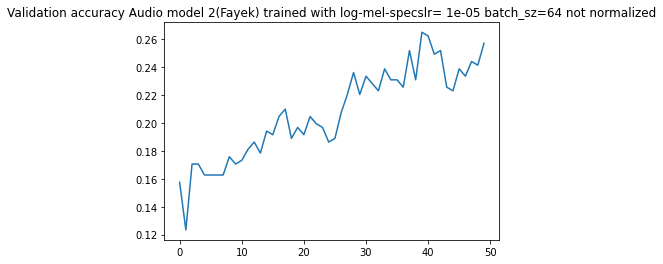

[[37  0  0 17  7  3  0]
 [ 6  0  0 12 19  3  0]
 [15  0  3 19  9  0  0]
 [ 8  0  0 30 21  4  0]
 [ 5  0  0 27 27  2  0]
 [13  0  1 19 27  0  1]
 [10  0  0 23 12  0  1]]

accuracy:  0.2572178477690289
f1 score: [0.46835443 0.         0.12       0.28571429 0.29508197 0.
 0.04166667]
f1 score weighted: 0.19268070921514557
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-specslr= 1e-05 batch_sz=64 not normalized


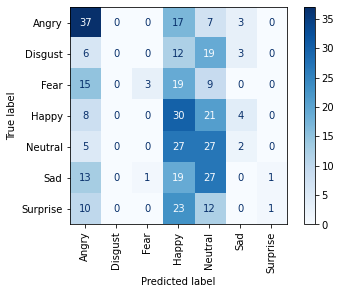

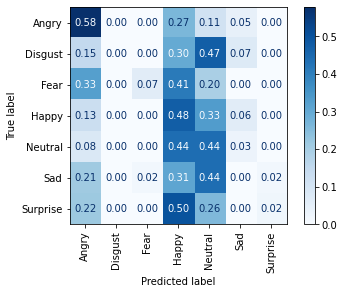

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
# X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

# xtrain = tf.expand_dims(X_tr_arr, axis=-1)
# xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=16
lr=0.0001

lr_rates=[0.0001,0.00005,0.00001]
batch_szs=[8,16,32,64]
norm=[0,1]

for lr in lr_rates:
  for batch_size in batch_szs:
    for normalized in norm:
      print("-------------------------------------")
      print("learnig rate: ",lr)
      print("batch size: ",batch_size)
      print("normalized audio?: ",normalized==1)
      if norm==1:
        X_tr_arr=asarray(new_data_train)
        X_te_arr=asarray(new_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="normalized"
      else:
        X_tr_arr=asarray(x_data_train)
        X_te_arr=asarray(x_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="not normalized"

      audio_model2_fayek = Classifier()
      optimizer = tf.keras.optimizers.RMSprop(lr=lr)
      audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

      E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
      callbacks_list=[E_stopping]

      history=audio_model2_fayek.fit(xtrain, y_train_arr,
                        epochs=epochs,
                        validation_data=(xtest, y_te_arr),
                        batch_size=batch_size,
                      #  class_weight=class_weight_dict,
                        callbacks=callbacks_list)
      path=""
      title="Audio model 2(Fayek) trained with log-mel-specs"+"lr= "+str(lr)+" batch_sz="+str(batch_size)+" "+norm_str
      plot_model(history,title)
      plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
      plt.figure()

(773, 40, 624, 1)
(381, 40, 624, 1)
(773, 7)
(381, 7)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
49/49 [==============================] - 4s 39ms/step - loss: 2.1742 - categorical_accuracy: 0.1669 - accuracy: 0.1669 - val_loss: 2.1561 - val_categorical_accuracy: 0.1785 - val_accuracy: 0.1785
Epoch 2/50
49/49 [==============================] - 1s 30ms/step - loss: 2.1419 - categorical_accuracy: 0.2057 - accuracy: 0.2057 - val_loss: 2.1496 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 3/50
49/49 [==============================] - 2s 31ms/step - loss: 2.1159 - categorical_accuracy: 0.2031 - accuracy: 0.2031 - val_loss: 2.1392 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 4/50
49/49 [==============================] - 1s 30ms/step - loss: 2.0872 - categorical_accuracy: 0.2419 - accuracy: 0.2419 - val_loss: 2.1267 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 5/50
49/49 [==============================] - 1s 30ms/step - loss: 2.0714 - categorical_accuracy: 0.2458 - accuracy: 0.2458 - val_loss: 2.1208 - val_categorical_accur

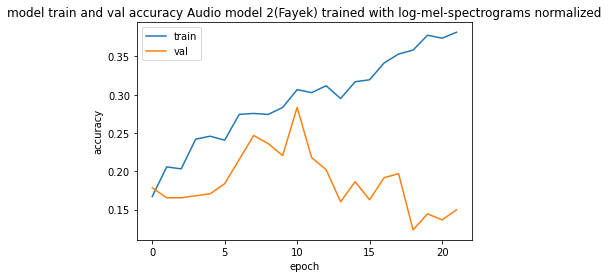

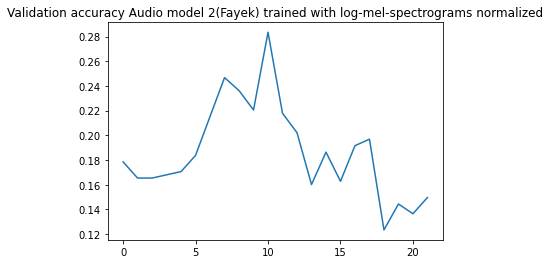

[[60  0  0  1  3  0  0]
 [25  0  0  4  9  2  0]
 [40  0  0  3  3  0  0]
 [43  0  0  8  7  5  0]
 [30  0  0 15 11  5  0]
 [37  0  0  8 12  4  0]
 [29  0  0 10  6  1  0]]

accuracy:  0.2178477690288714
f1 score: [0.36585366 0.         0.         0.14285714 0.19642857 0.1025641
 0.        ]
f1 score weighted: 0.13294799805746607
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-spectrograms normalized


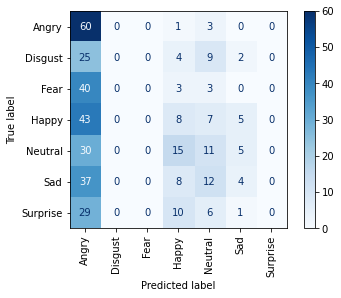

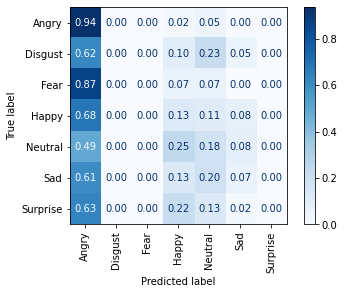

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#Test sin normalizar los spectrogramas 
X_tr_arr=asarray(x_data_train)
y_train_arr=asarray(y_data_train)
X_te_arr=asarray(x_data_test)
y_te_arr=asarray(y_data_test)

xtrain = tf.expand_dims(X_tr_arr, axis=-1)
xtest= tf.expand_dims(X_te_arr, axis=-1)

print(xtrain.shape)
print(xtest.shape)
print(y_train_arr.shape)
print(y_te_arr.shape)

epochs=50
batch_size=16
lr=0.0001
audio_model2_fayek = Classifier()

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

optimizer = tf.keras.optimizers.RMSprop(lr=lr)
audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

history=audio_model2_fayek.fit(xtrain, y_train_arr,
                  epochs=epochs,
                  validation_data=(xtest, y_te_arr),
                  batch_size=batch_size,
                #  class_weight=class_weight_dict,
                  callbacks=callbacks_list)
path=""
title="Audio model 2(Fayek) trained with log-mel-spectrograms normalized"
plot_model(history,"Audio model 2(Fayek) trained with log-mel-spectrograms normalized")
plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
plt.figure()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 40, 624, 32)       320       
_________________________________________________________________
activation (Activation)      (None, 40, 624, 32)       0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 38, 622, 64)       18496     
_________________________________________________________________
activation_1 (Activation)    (None, 38, 622, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 311, 64)       0         
_________________________________________________________________
dropout_195 (Dropout)        (None, 19, 311, 64)       0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 19, 311, 64)     

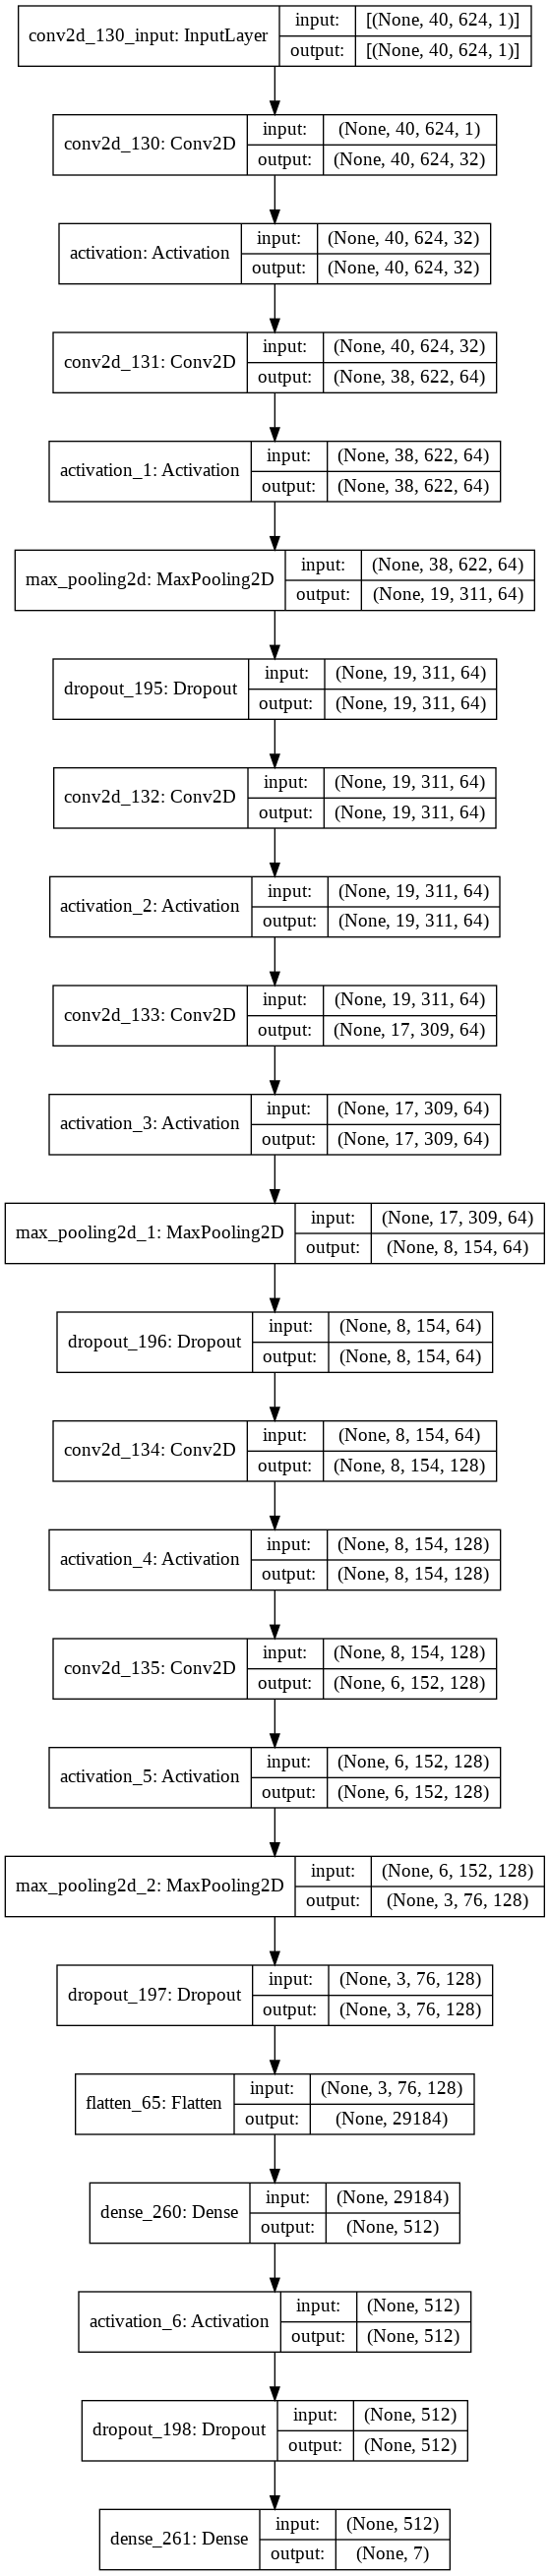

In [ ]:
#UrbandSoundmodel:

from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
def model2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=input_shape
                  ))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))
  return model
model=model2()
# model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='audio_model0_US_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
# X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

# xtrain = tf.expand_dims(X_tr_arr, axis=-1)
# xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=16
lr=0.0001

lr_rates=[0.0001,0.00005,0.00001]
batch_szs=[8,16,32,64]
norm=[0,1]

for lr in lr_rates:
  for batch_size in batch_szs:
    for normalized in norm:
      print("-------------------------------------")
      print("learnig rate: ",lr)
      print("batch size: ",batch_size)
      print("normalized audio?: ",normalized==1)
      if norm==1:
        X_tr_arr=asarray(new_data_train)
        X_te_arr=asarray(new_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="normalized"
      else:
        X_tr_arr=asarray(x_data_train)
        X_te_arr=asarray(x_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="not normalized"

      model_US=model2()
      optimizer = tf.keras.optimizers.RMSprop(lr=lr,decay=1e-6)
      model_US.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

      E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=15,verbose=1,mode="auto",restore_best_weights=True)
      callbacks_list=[E_stopping]

      history=model_US.fit(xtrain, y_train_arr,
                        epochs=epochs,
                        validation_data=(xtest, y_te_arr),
                        batch_size=batch_size,
                      #  class_weight=class_weight_dict,
                        callbacks=callbacks_list)
      path=""
      title="Audio model 1(US) trained with log-mel-specs"+"lr= "+str(lr)+" batch_sz="+str(batch_size)+" "+norm_str
      plot_model(history,title)
      plot_conf_matrix(xtest,y_te_arr,model_US,path,title,standard_format=True,percentages=True,save_plot=True)
      plt.figure()

-------------------------------------
learnig rate:  0.0001
batch size:  8
normalized audio?:  False


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
97/97 [==============================] - 11s 89ms/step - loss: 5.8281 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 1.9442 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 2/50
97/97 [==============================] - 8s 80ms/step - loss: 1.9858 - categorical_accuracy: 0.1708 - accuracy: 0.1708 - val_loss: 1.9446 - val_categorical_accuracy: 0.1627 - val_accuracy: 0.1627
Epoch 3/50
97/97 [==============================] - 8s 81ms/step - loss: 1.9394 - categorical_accuracy: 0.1811 - accuracy: 0.1811 - val_loss: 1.9448 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 4/50
97/97 [==============================] - 8s 82ms/step - loss: 1.9304 - categorical_accuracy: 0.1940 - accuracy: 0.1940 - val_loss: 1.9451 - val_categorical_accuracy: 0.1759 - val_accuracy: 0.1759
Epoch 5/50
97/97 [==============================] - 8s 81ms/step - loss: 1.9367 - categorical_accuracy: 0.1708 - accuracy: 0.1708 - val_loss: 1.9426 - val_categorical_accu

AttributeError: ignored

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            list(emo_dict.keys()), 
            train_labels)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
49/49 [==============================] - 4s 39ms/step - loss: 2.1709 - categorical_accuracy: 0.1798 - accuracy: 0.1798 - val_loss: 2.1711 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 2/50
49/49 [==============================] - 1s 31ms/step - loss: 2.1289 - categorical_accuracy: 0.2316 - accuracy: 0.2316 - val_loss: 2.1620 - val_categorical_accuracy: 0.1916 - val_accuracy: 0.1916
Epoch 3/50
49/49 [==============================] - 2s 31ms/step - loss: 2.1240 - categorical_accuracy: 0.2354 - accuracy: 0.2354 - val_loss: 2.1528 - val_categorical_accuracy: 0.1864 - val_accuracy: 0.1864
Epoch 4/50
49/49 [==============================] - 2s 33ms/step - loss: 2.0941 - categorical_accuracy: 0.2497 - accuracy: 0.2497 - val_loss: 2.1451 - val_categorical_accuracy: 0.2205 - val_accuracy: 0.2205
Epoch 5/50
49/49 [==============================] - 1s 30ms/step - loss: 2.0865 - categorical_accuracy: 0.2794 - accuracy: 0.2794 - val_loss: 2.1345 - val_categorical_accur

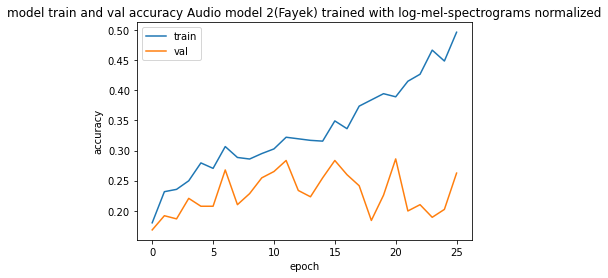

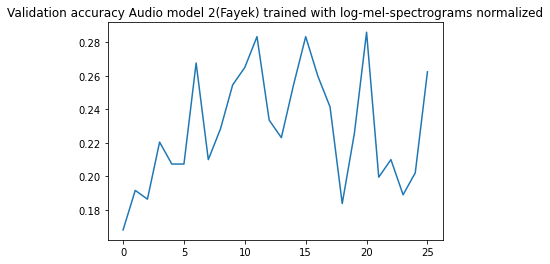

[[47  0  0  9  6  1  1]
 [ 8  0  1  8 22  1  0]
 [34  0  0  5  7  0  0]
 [16  0  0 23 23  1  0]
 [ 8  0  0 16 33  4  0]
 [17  0  0 10 29  5  0]
 [18  0  0 16 12  0  0]]

accuracy:  0.28346456692913385
f1 score: [0.44339623 0.         0.         0.30666667 0.34196891 0.1369863
 0.        ]
f1 score weighted: 0.20187303543588106
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-spectrograms normalized


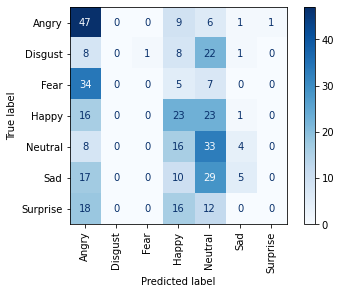

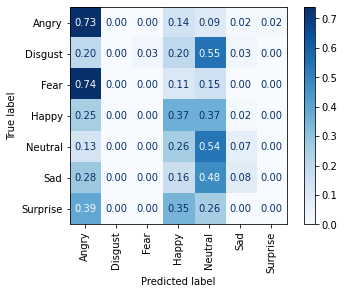

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
# X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

# xtrain = tf.expand_dims(X_tr_arr, axis=-1)
# xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=16
lr=0.0001

lr_rates=[0.0001,0.00005,0.00001]
batch_szs=[8,16,32,64]
norm=[0,1]

for lr in lr_rates:
  for batch_size in batch_szs:
    for normalized in norm:
      print("-------------------------------------")
      print("learnig rate: ",lr)
      print("batch size: ",batch_size)
      print("normalized audio?: ",normalized==1)
      if norm==1:
        X_tr_arr=asarray(new_data_train)
        X_te_arr=asarray(new_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="normalized"
      else:
        X_tr_arr=asarray(x_data_train)
        X_te_arr=asarray(x_data_test)
        xtrain = tf.expand_dims(X_tr_arr, axis=-1)
        xtest= tf.expand_dims(X_te_arr, axis=-1)
        norm_str="not normalized"

      audio_model2_fayek = Classifier()
      optimizer = tf.keras.optimizers.RMSprop(lr=lr)
      audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

      E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
      callbacks_list=[E_stopping]

      history=audio_model2_fayek.fit(xtrain, y_train_arr,
                        epochs=epochs,
                        validation_data=(xtest, y_te_arr),
                        batch_size=batch_size,
                      #  class_weight=class_weight_dict,
                        callbacks=callbacks_list)
      path=""
      title="Audio model 2(Fayek) trained with log-mel-specs"+"lr= "+str(lr)+" batch_sz="+str(batch_size)+" "+norm_str
      plot_model(history,title)
      plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
      plt.figure()



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
25/25 [==============================] - 4s 53ms/step - loss: 2.1861 - categorical_accuracy: 0.1656 - accuracy: 0.1656 - val_loss: 2.1775 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1712 - categorical_accuracy: 0.1876 - accuracy: 0.1876 - val_loss: 2.1771 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 3/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1714 - categorical_accuracy: 0.1902 - accuracy: 0.1902 - val_loss: 2.1767 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1763 - categorical_accuracy: 0.1604 - accuracy: 0.1604 - val_loss: 2.1763 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 5/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1651 - categorical_accuracy: 0.1630 - accuracy: 0.1630 - val_loss: 2.1758 - val_categorical_accur

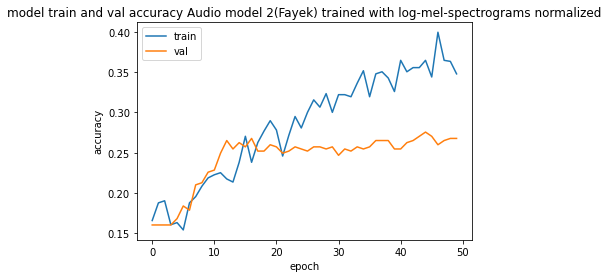

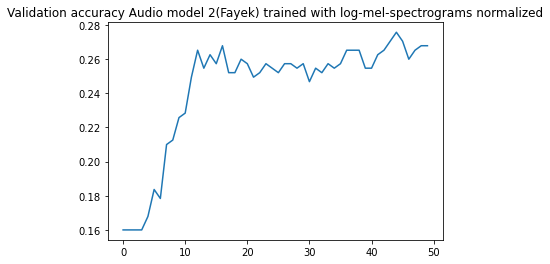

[[46  1  3 10  4  0  0]
 [10  1  1 10 17  1  0]
 [33  0  0  7  6  0  0]
 [16  3  0 25 17  2  0]
 [ 8  1  0 21 26  5  0]
 [19  1  0 14 23  4  0]
 [17  0  1 17 10  1  0]]

accuracy:  0.2677165354330709
f1 score: [0.43192488 0.04255319 0.         0.2994012  0.31707317 0.10810811
 0.        ]
f1 score weighted: 0.19460276537051946
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-spectrograms normalized


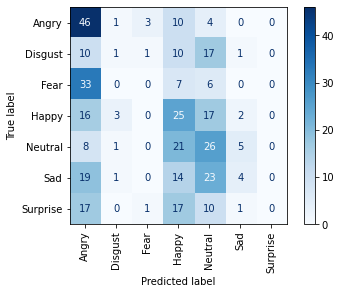

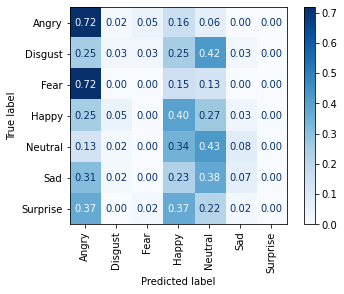

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
X_tr_arr=asarray(new_data_train)
y_train_arr=asarray(y_data_train)
X_te_arr=asarray(new_data_test)
y_te_arr=asarray(y_data_test)

xtrain = tf.expand_dims(X_tr_arr, axis=-1)
xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=32
lr=0.00001
audio_model2_fayek = Classifier()

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

optimizer = tf.keras.optimizers.RMSprop(lr=lr)
audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

history=audio_model2_fayek.fit(xtrain, y_train_arr,
                  epochs=epochs,
                  validation_data=(xtest, y_te_arr),
                  batch_size=batch_size,
                #  class_weight=class_weight_dict,
                  callbacks=callbacks_list)
path=""
title="Audio model 2(Fayek) trained with log-mel-spectrograms normalized"
plot_model(history,"Audio model 2(Fayek) trained with log-mel-spectrograms normalized")
plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
plt.figure()



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
25/25 [==============================] - 4s 55ms/step - loss: 2.1930 - categorical_accuracy: 0.1449 - accuracy: 0.1449 - val_loss: 2.1745 - val_categorical_accuracy: 0.1575 - val_accuracy: 0.1575
Epoch 2/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1815 - categorical_accuracy: 0.1462 - accuracy: 0.1462 - val_loss: 2.1732 - val_categorical_accuracy: 0.1811 - val_accuracy: 0.1811
Epoch 3/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1708 - categorical_accuracy: 0.1539 - accuracy: 0.1539 - val_loss: 2.1718 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 4/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1779 - categorical_accuracy: 0.1617 - accuracy: 0.1617 - val_loss: 2.1703 - val_categorical_accuracy: 0.1549 - val_accuracy: 0.1549
Epoch 5/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1662 - categorical_accuracy: 0.1630 - accuracy: 0.1630 - val_loss: 2.1688 - val_categorical_accur

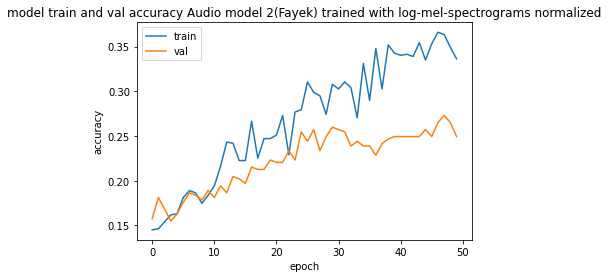

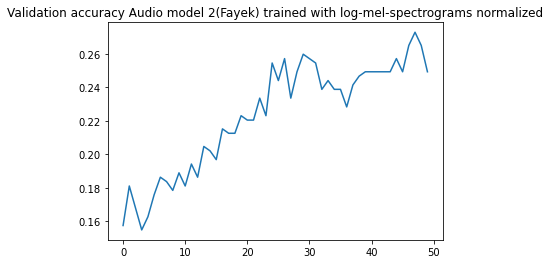

[[48  0  1 10  2  3  0]
 [16  0  0  9 11  4  0]
 [29  1  0 10  5  1  0]
 [18  2  1 26 13  3  0]
 [11  2  0 27 17  4  0]
 [18  0  1 19 19  4  0]
 [15  0  0 22  7  2  0]]

accuracy:  0.24934383202099739
f1 score: [0.43835616 0.         0.         0.27956989 0.25185185 0.09756098
 0.        ]
f1 score weighted: 0.17580545989898289
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-spectrograms normalized


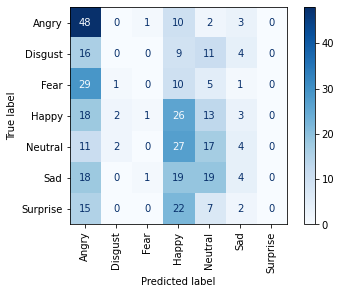

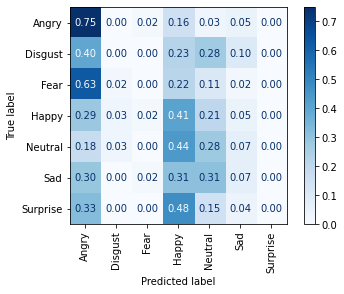

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#test sin normalizar
X_tr_arr=asarray(x_data_train)
y_train_arr=asarray(y_data_train)
X_te_arr=asarray(x_data_test)
y_te_arr=asarray(y_data_test)

xtrain = tf.expand_dims(X_tr_arr, axis=-1)
xtest= tf.expand_dims(X_te_arr, axis=-1)

epochs=50
batch_size=32
lr=0.00001
audio_model2_fayek = Classifier()

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

optimizer = tf.keras.optimizers.RMSprop(lr=lr)
audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

history=audio_model2_fayek.fit(xtrain, y_train_arr,
                  epochs=epochs,
                  validation_data=(xtest, y_te_arr),
                  batch_size=batch_size,
                #  class_weight=class_weight_dict,
                  callbacks=callbacks_list)
path=""
title="Audio model 2(Fayek) trained with log-mel-spectrograms normalized"
plot_model(history,"Audio model 2(Fayek) trained with log-mel-spectrograms normalized")
plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
plt.figure()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
25/25 [==============================] - 4s 54ms/step - loss: 2.2052 - categorical_accuracy: 0.1307 - accuracy: 0.1307 - val_loss: 2.1763 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 2/50
25/25 [==============================] - 1s 38ms/step - loss: 2.1842 - categorical_accuracy: 0.1604 - accuracy: 0.1604 - val_loss: 2.1752 - val_categorical_accuracy: 0.1680 - val_accuracy: 0.1680
Epoch 3/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1830 - categorical_accuracy: 0.1449 - accuracy: 0.1449 - val_loss: 2.1743 - val_categorical_accuracy: 0.1601 - val_accuracy: 0.1601
Epoch 4/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1984 - categorical_accuracy: 0.1462 - accuracy: 0.1462 - val_loss: 2.1734 - val_categorical_accuracy: 0.1654 - val_accuracy: 0.1654
Epoch 5/50
25/25 [==============================] - 1s 37ms/step - loss: 2.1846 - categorical_accuracy: 0.1501 - accuracy: 0.1501 - val_loss: 2.1724 - val_categorical_accur

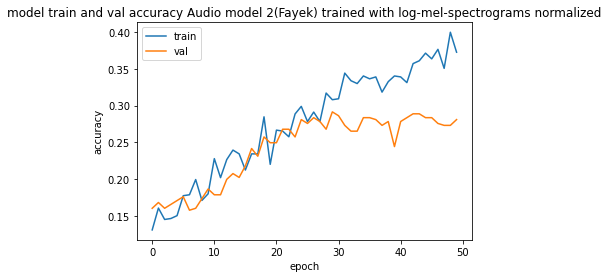

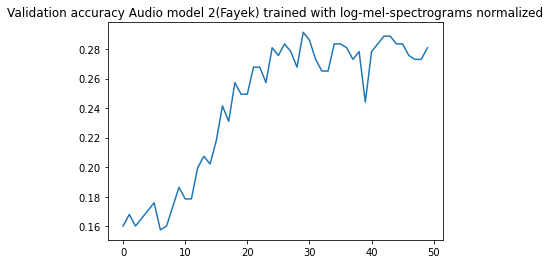

[[45  0  3  9  6  1  0]
 [ 9  0  0 11 18  2  0]
 [23  0  3 12  8  0  0]
 [11  1  2 24 21  4  0]
 [ 9  1  1 19 30  1  0]
 [12  0  1 16 27  5  0]
 [11  0  1 21 11  2  0]]

accuracy:  0.28083989501312334
f1 score: [0.48913043 0.         0.10526316 0.27428571 0.32967033 0.13157895
 0.        ]
f1 score weighted: 0.21407522044254237
---------------------------------------------------------
Audio model 2(Fayek) trained with log-mel-spectrograms normalized


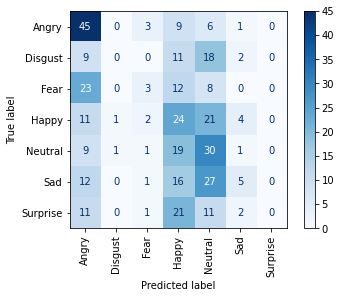

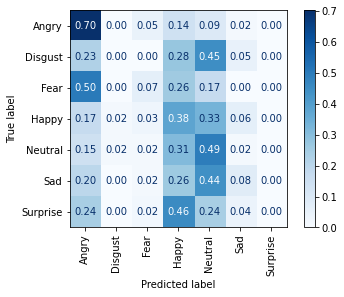

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#Test normalizado 
epochs=50
batch_size=32
lr=0.00001
audio_model2_fayek = Classifier()

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=0,patience=10,verbose=1,mode="auto",restore_best_weights=True)
callbacks_list=[E_stopping]

optimizer = tf.keras.optimizers.RMSprop(lr=lr)
audio_model2_fayek.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

history=audio_model2_fayek.fit(xtrain, y_train_arr,
                  epochs=epochs,
                  validation_data=(xtest, y_te_arr),
                  batch_size=batch_size,
                #  class_weight=class_weight_dict,
                  callbacks=callbacks_list)
path=""
title="Audio model 2(Fayek) trained with log-mel-spectrograms normalized"
plot_model(history,"Audio model 2(Fayek) trained with log-mel-spectrograms normalized")
plot_conf_matrix(xtest,y_te_arr,audio_model2_fayek,path,title,standard_format=True,percentages=True,save_plot=True)
plt.figure()


In [ ]:
def compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.001):
  optimizer = tf.keras.optimizers.RMSprop(lr=lr)
  model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
  
  logdir = chkpoint_filepath + "corrected_test"
  
  if not os.path.exists(logdir):
      os.mkdir(logdir)
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  
  # filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  
  # csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
  csv_logger = CSVLogger(csv_log_file)
  
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=30,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=False)

  # callbacks_list = [checkpoint,csv_logger]
  callbacks_list = [E_stopping]
  # callback_list = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35)
  # history=model.fit(xtrain, Y_train,
  #                  epochs=epochs,
  #                  validation_data=(xtest, Y_test),
  #                  batch_size=batch_size,
  #                  class_weight=class_weight_dict,
  #                  callbacks=callback_list)

  history=model.fit(xtrain, y_train_new,
                   epochs=epochs,
                   validation_data=(xval, y_val_new),
                   batch_size=batch_size,
                  #  class_weight=class_weight_dict,
                   callbacks=callbacks_list)

  return history,model


In [ ]:
# def training_loop(title, chkpoint_filepath, csv_log_file, epochs, batch_size, lr=0.01):
#   audio_model = Classifier()
#   history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.01)
#   model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba2/prueba2.h5")
#   plot_model(history,title)
#   return history

In [ ]:
print(xtrain.shape)
print(y_val_new.shape)
print(xval.shape)
print(y_train_new.shape)

(618, 40, 624, 1)
(155, 7)
(155, 40, 624, 1)
(618, 7)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
39/39 [==============================] - 56s 189ms/step - loss: 2.1740 - categorical_accuracy: 0.1716 - accuracy: 0.1716 - val_loss: 2.1696 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 2/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1521 - categorical_accuracy: 0.1880 - accuracy: 0.1880 - val_loss: 2.1636 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 3/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1538 - categorical_accuracy: 0.1861 - accuracy: 0.1861 - val_loss: 2.1570 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 4/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1210 - categorical_accuracy: 0.2586 - accuracy: 0.2586 - val_loss: 2.1496 - val_categorical_accuracy: 0.1613 - val_accuracy: 0.1613
Epoch 5/50
39/39 [==============================] - 6s 156ms/step - loss: 2.1288 - categorical_accuracy: 0.2551 - accuracy: 0.2551 - val_loss: 2.1413 - val_categorical

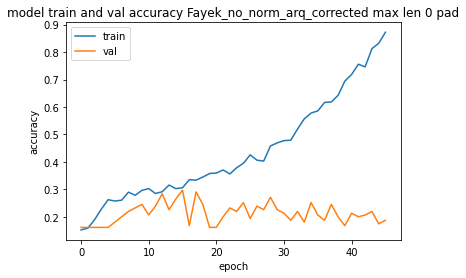

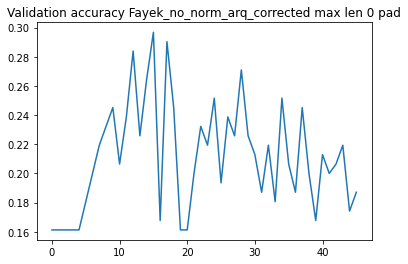

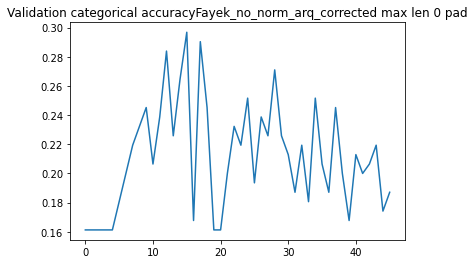

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# Sin normalizar


chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/train_P4v2_audio.log'


# X_train=asarray(x_train)
# Y_train=asarray(y_train)
# X_test=asarray(x_test)
# Y_test=asarray(y_test)
# xtrain = tf.expand_dims(X_train, axis=-1)
# xtest= tf.expand_dims(X_test, axis=-1)

# print(xtrain.shape)
# X_train_=asarray(X_train)
# y_train_=asarray(y_train)
# X_val_=asarray(X_val)
# y_val_=asarray(y_val)
# xtrain = tf.expand_dims(X_train_, axis=-1)
# xval= tf.expand_dims(X_val_, axis=-1)


audio_model = Classifier()
history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Fayek_no_norm_arq_corrected.h5")
plot_model(history,"Fayek_no_norm_arq_corrected max len 0 pad")

In [ ]:
# spec_vals=asarray(spec_values).flatten()
# train_mean=np.mean(spec_vals)
# train_std=np.std(spec_vals)
# # spec_values.flatten()
# print(train_mean)
# print(train_std)

-80.70755563843169
22.2797843560173


In [ ]:
print(asarray(X_train).shape)
print(asarray(y_train).shape)
print(asarray(x_data_train).shape)
print(asarray(X_val).shape)
x_train[-1]

(618, 40, 624)
(618, 7)
(773, 40, 624)
(155, 40, 624)


array([[-0.85924903, -0.85924903,  0.14738448, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.85924903,  0.40581917, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.85924903,  0.38113154, ..., -0.85924903,
        -0.85924903, -0.85924903],
       ...,
       [-0.81229913, -0.23445259,  0.34011358, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.83186218, -0.33521581,  0.18347238, ..., -0.85924903,
        -0.85924903, -0.85924903],
       [-0.85924903, -0.44743524, -0.1152997 , ..., -0.85924903,
        -0.85924903, -0.85924903]])

In [ ]:
# X_train, X_val, y_train, y_val = train_test_split(new_data_train, y_data_train, test_size=0.20, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
train_labels=[get_emo_from_categorical(label) for label in y_train]
# train_labels

NameError: ignored

In [ ]:
list(emo_dict.keys())

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            list(emo_dict.keys()), 
            train_labels)
class_weights
indices=[0,1,2,3,4,5,6]
class_weight_dict=dict(zip(indices,class_weights))
class_weight_dict

{0: 0.8408163265306122,
 1: 1.4473067915690867,
 2: 1.279503105590062,
 3: 0.7357142857142858,
 4: 0.8251001335113485,
 5: 0.9493087557603687,
 6: 1.401360544217687}

In [ ]:
new_data_train=[]
for spec in x_data_train:
  norm_spec=(spec-train_mean)/train_std+1e-10
  new_data_train.append(norm_spec)

In [ ]:
new_data_test=[]
for spec in x_data_test:
  norm_spec=(spec-train_mean)/train_std+1e-10
  new_data_test.append(norm_spec)

In [ ]:
print(asarray(new_data_train).shape)
asarray(y_data_train).shape

(773, 40, 624)


(773, 7)

In [ ]:
print(asarray(new_data_test).shape)
asarray(y_data_test).shape

(381, 40, 624)


(381, 7)

In [ ]:
new_data_train[-1]

array([[-0.67131459, -0.67131459,  0.12119899, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.67131459, -0.67131459,  0.75075965, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.67131459, -0.67131459,  1.09354827, ..., -0.67131459,
        -0.67131459, -0.67131459],
       ...,
       [-0.66829813, -0.10636446,  1.4975113 , ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.53587206,  0.01449921,  1.59042267, ..., -0.67131459,
        -0.67131459, -0.67131459],
       [-0.64602179, -0.0998281 ,  1.40000354, ..., -0.67131459,
        -0.67131459, -0.67131459]])

In [ ]:
#Fayek model
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     input_shape= [624,40 , 1], kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))


    model.add(Conv2D(filters=32,
                     kernel_size=(10, 10),
                     strides=2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
   
    model.add(BatchNormalization())
    # model.add(Dropout(DROPOUT))

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))


    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()
audio_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 615, 31, 16)       1616      
_________________________________________________________________
batch_normalization_25 (Batc (None, 615, 31, 16)       64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 606, 22, 32)       51232     
_________________________________________________________________
batch_normalization_26 (Batc (None, 606, 22, 32)       128       
_________________________________________________________________
flatten_5 (Flatten)          (None, 426624)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 716)               305463500 
_________________________________________________________________
batch_normalization_27 (Batc (None, 716)              

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(new_data_train,y_data_train)
x_test,y_test=shuffle(new_data_test,y_data_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42) # 0.25 x 0.8 = 0.2

In [ ]:
#Va mal

In [ ]:
def save_plot(history,title,filename):
  fig = plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title("model train and val accuracy "+title)
  plt.show()
  new_filename  = Path(filename +'/'+title+'.jpg')
  fig.savefig(new_filename, dpi=400, bbox_inches='tight',pad_inches=0)

In [ ]:
save_plot(history,"P4v2 Fayek spec no normalized",filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results")

In [ ]:
#PARAMS:
params={}
params["num_prueba"]="P4v2 Fayek con espectrogramas"
params["description"]="longitud maxima"
params["DROPOUT"]=DROPOUT
params["l2_regul"]=l2_regul
params["learning rate"]=lr
params["N_OUTPUT_LABELS"]=N_OUTPUT_LABELS
params["batch_size"]=batch_size
params["epochs"]=epochs
params["desired_audio_len"]=desired_audio_len
params["preemphasis"]=preemphasis
params["normalize"]=normalize
params["input_shape"]=input_shape

with open("/content/gdrive/My Drive/TFM_MUSI/Audio/Results/results.csv", 'a') as f: 
  dictwriter_object = DictWriter(f, fieldnames=params.keys()) 
  dictwriter_object .writeheader()
  dictwriter_object.writerow(params) 
  f.close()


In [ ]:
asarray(test_data.values())

In [ ]:
# x_data_test

In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)

In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)
y_test=[ emo_dict[get_emo_from_categorical(test_data[label])] for label in test_data.keys()]
# y_test

In [ ]:
def evaluate_model(model):
  predictions=audio_model.predict(TestX)
  print('Confusion Matrix')
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(ypred)
  print(confusion_matrix(y_test, ypred))
  # print(confusion_matrix(y_test, ypred))

evaluate_model(model)

In [ ]:
print(emo_dict)

In [ ]:
for emo in emo_dict.keys():
  print("emotion: ", emo)
  print("number of audios: ",list(dict_xy_afew.values()).count(emo))
  print("-----")

In [ ]:
# PROVA 2: MODEL DEL URBANDSOUND

In [ ]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
def model2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',
                  input_shape=input_shape
                  ))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation='softmax'))
  return model
model=model2()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='audio_model0_US_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: ignored

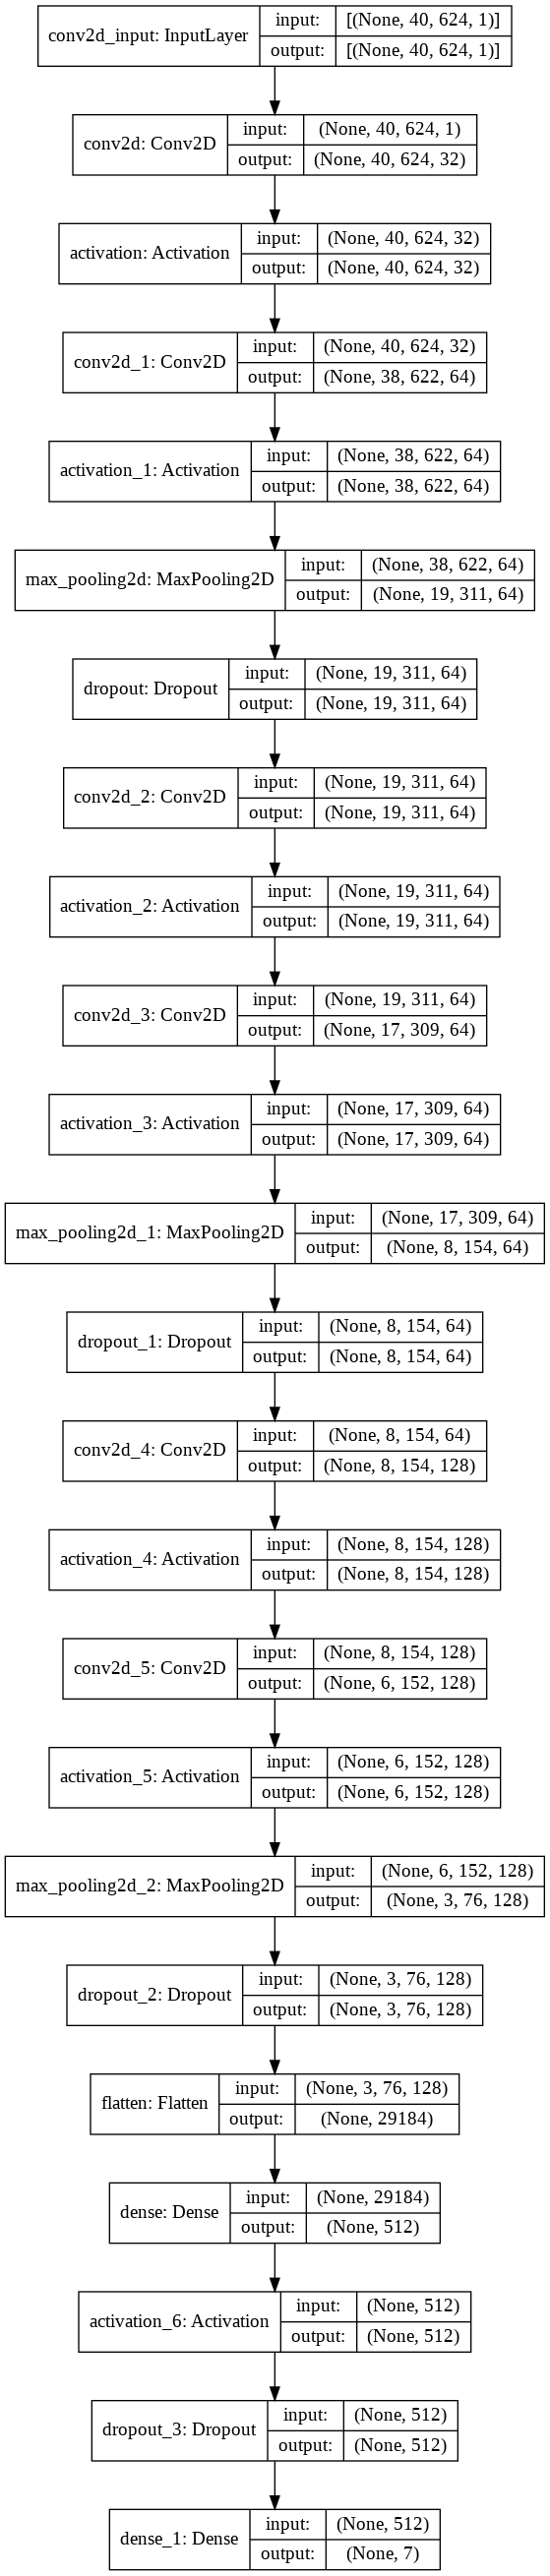

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='audio_model0_US_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!mkdir "/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/"

In [ ]:
chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/train_P4v3_audio.log'


# history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)


logdir = chkpoint_filepath + datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(logdir):
    os.mkdir(logdir)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
csv_logger = CSVLogger(csv_log_file)

callbacks_list = [checkpoint,csv_logger]
# history=model.fit(xtrain, Y_train,
#                   epochs=epochs,
#                   validation_data=(xtest, Y_test),
#                   batch_size=batch_size,
#                   callbacks=callbacks_list)

history=model.fit(xtrain, y_train_new,
                  epochs=epochs,
                  validation_data=(xtest, y_test_new),
                  batch_size=batch_size,
                  callbacks=callbacks_list)


model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v3/Fayek_spec.h5")


NameError: ignored

In [ ]:
save_plot(history,"P4v3 Fayek spec no normalized",filename="/content/gdrive/My Drive/TFM_MUSI/Audio/Results")


In [ ]:
testx=asarray(x_data_test)
TestX=tf.expand_dims(testx, axis=-1)
y_test=[ emo_dict[get_emo_from_categorical(test_data[label])] for label in test_data.keys()]
# y_test

In [ ]:
def evaluate_model(model):
  predictions=model.predict(TestX)
  print('Confusion Matrix')
  ypred=[round(list(i).index(max(i))) for i in predictions]
  print(ypred)
  print(confusion_matrix(y_test, ypred))
  # print(confusion_matrix(y_test, ypred))

evaluate_model(model)

In [ ]:
print(emo_dict)

In [ ]:
for emo in emo_dict.keys():
  print("emotion: ", emo)
  print("number of audios: ",list(dict_xy_afew.values()).count(emo))
  print("-----")

In [ ]:
###############################################################

In [ ]:
# prova restant la mitjana

normalize=True # alerta amb Nans
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

train_data={}
test_data={}

x_data_train,y_data_train = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)
x_data_test,y_data_test = create_set(urls_afew_test,    test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
x_data_train[-1]

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_data_train,y_data_train)
x_test,y_test=shuffle(x_data_test,y_data_test)

In [ ]:
print(asarray(x_train).shape)
print(asarray(x_data_train).shape)
x_train[-1]

In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
input_shape
epochs=50
batch_size=16
lr=0.0001

In [ ]:
def Classifier():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     input_shape=input_shape, kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    model.add(Conv2D(filters=16,
                     kernel_size=(10, 10),
                     strides=1,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_regul)))
    
    model.add(BatchNormalization())

    #Afegit això:
    # model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    
    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='relu'))

    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))

    model.add(Dense(units=716,activation='softmax'))
    
    model.add(BatchNormalization())
    model.add(Dropout(DROPOUT))
    # model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dense(units=N_OUTPUT_LABELS,
                    activation='softmax'))
    return model


audio_model = Classifier()


In [ ]:
def compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=0.001):
  optimizer = tf.keras.optimizers.RMSprop(lr=lr)
  model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
  
  logdir = chkpoint_filepath + datetime.now().strftime("%Y%m%d-%H%M%S")
  
  if not os.path.exists(logdir):
      os.mkdir(logdir)
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  
  # filepath="/content/gdrive/My Drive/TFM_MUSI/FACES6/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  chkpoint_filepath=chkpoint_filepath+":{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
  checkpoint = ModelCheckpoint(chkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  
  # csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
  csv_logger = CSVLogger(csv_log_file)
  E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                            min_delta=0,
                                            patience=35,
                                            verbose=1,
                                            mode="auto",
                                            restore_best_weights=False)
  callbacks_list=[E_stopping]

  # callbacks_list = [checkpoint,csv_logger]
  history=model.fit(xtrain, Y_train,
                   epochs=epochs,
                   validation_data=(xtest, Y_test),
                   batch_size=batch_size,
                   callbacks=callbacks_list)

  return history,model


In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)

  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.show()
  

Epoch 1/50
49/49 [==============================] - 5s 70ms/step - loss: 1.9594 - categorical_accuracy: 0.1860 - accuracy: 0.1860 - val_loss: 1.9364 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 2/50
49/49 [==============================] - 3s 52ms/step - loss: 1.9030 - categorical_accuracy: 0.2198 - accuracy: 0.2198 - val_loss: 1.9293 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 3/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8883 - categorical_accuracy: 0.2207 - accuracy: 0.2207 - val_loss: 1.9310 - val_categorical_accuracy: 0.2283 - val_accuracy: 0.2283
Epoch 4/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8665 - categorical_accuracy: 0.2629 - accuracy: 0.2629 - val_loss: 1.9211 - val_categorical_accuracy: 0.1916 - val_accuracy: 0.1916
Epoch 5/50
49/49 [==============================] - 3s 52ms/step - loss: 1.8664 - categorical_accuracy: 0.2724 - accuracy: 0.2724 - val_loss: 1.9287 - val_categorical_accur

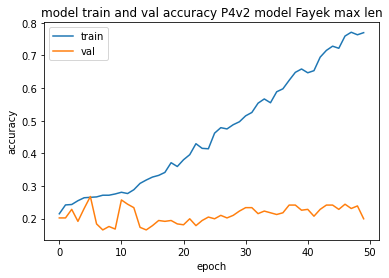

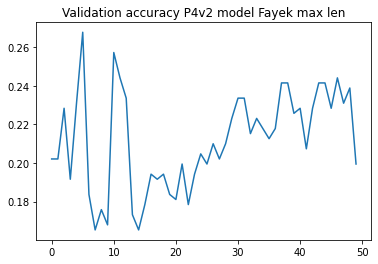

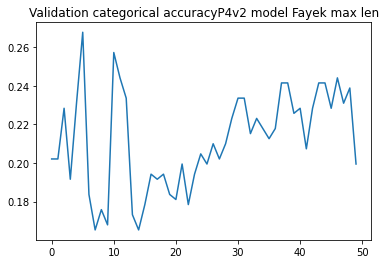

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# normalizado


# chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/"
# csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/train_P4v2_audio.log'

# X_train=asarray(x_train)
# Y_train=asarray(y_train)
# X_test=asarray(x_test)
# Y_test=asarray(y_test)
# xtrain = tf.expand_dims(X_train, axis=-1)
# xtest= tf.expand_dims(X_test, axis=-1)


# audio_model = Classifier()
history,model=compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/Fayek_spec_norm.h5")
plot_model(history,"P4v2 model Fayek max len")

In [ ]:
#Test amb el model de l'urbandsound
model=model2()
model.compile(optimizers.RMSprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
history,model=compile_and_fit(model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/US_spec_norm.h5")
plot_model(history,"P4v2 model US max len norm")

In [ ]:
# prova restant la mitjana

normalize=True # normalitzat normal
preemphasis=True
desired_audio_len=137063 #maximum len
num_classes=7

train_data={}
test_data={}

x_data_train,y_data_train = create_set(urls_afew_train, train_data, desired_audio_len ,normalize,preemphasis)
x_data_test,y_data_test = create_set(urls_afew_test,    test_data, desired_audio_len, normalize,preemphasis)

In [ ]:
x_data_train[-1]

In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_data_train,y_data_train)
x_test,y_test=shuffle(x_data_test,y_data_test)

In [ ]:
print(asarray(x_train).shape)
print(asarray(x_data_train).shape)
x_train[-1]

In [ ]:
#PARAMS:
DROPOUT=0.5
l2_regul=0.01
N_OUTPUT_LABELS=7
input_shape=asarray(x_data_train[0]).shape
input_shape=list(input_shape)
input_shape.append(1)
input_shape
epochs=50
batch_size=16
lr=0.0001

In [ ]:
audio_model = Classifier()

In [ ]:
#Test 1: Longitud de los audios= la longitud del audio más corto
# Sin pre-emphasis
# normalizado


chkpoint_filepath="/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/"
csv_log_file='/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/train_P4v2_audio.log'

X_train=asarray(x_train)
Y_train=asarray(y_train)
X_test=asarray(x_test)
Y_test=asarray(y_test)
xtrain = tf.expand_dims(X_train, axis=-1)
xtest= tf.expand_dims(X_test, axis=-1)


audio_model = Classifier()
history,model=compile_and_fit(audio_model,chkpoint_filepath,csv_log_file,epochs,batch_size,lr=lr)
model.save("/content/gdrive/My Drive/TFM_MUSI/Audio/Prueba4v2/Fayek_spec_norm.h5")
plot_model(history,"P4v2 model Fayek max len")